<h1>AIKoGAM: An AI-driven Knowledge Graph of the Antiquities market: toward automatised methods to identify illicit trafficking networks</h1>
<p>This notebook enables to replicate the methods described in: Giovanelli, R.,Traviglia, A., 2023. <i>AIKoGAM: An AI-driven Knowledge Graph of the Antiquities market: toward automatised methods to identify illicit trafficking networks</i>.</p>

<h2>Web Harvesting</h2>

In [1]:
from datetime import datetime
import time
import json
import logging
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx

from setup.config import PLOTS_FOLDER, GRAPH_FOLDER, DATASET_FOLDER, MERGES, EXCEPTIONSEQUAL, EXCEPTIONSIN
from src.utils.utils import saveJson, openJson, format_time, pR
from src.utils.harvesting import collect_sales, collect_sales_sothebys, collectPAA
from src.utils.mapping import remap_christies_data, map_sothebys_data, remap_paa_data, cleanSubdictionaries, hashAndClean
from src.utils.cleaning import cleanNeo, run_cypher_query, generalQuery, nodes_and_edges, remove_nodes_by_regex_and_label, changeLabel, mergingNodes, removeErrArtwork, mergingDuples, merge_nodes_same_name
from src.utils.statistical_analysis import plot_bar_chart, countLabelsData, read_centrality_data, find_common_nodes, statistics_graph, barDegree
from src.utils.similarity import similarityCheckRemoval, checkManual, find_similar_nodes, removePatterns

now = datetime.now()
date_and_hour = datetime.now().strftime("%d%m%Y_%H%M")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
C:\Users\rgiovanelli.IIT\PycharmProjects\AIKoGAM\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<h3>Christie's WA</h3>
In the input, insert the first year from wich to start the collection, and the last year. Before 1998 there are no data.</br>
Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</br>
The estimated time for storing data of a sale with around 80 objects and no images is 59 sec on a CPU.</br></p>

In [ ]:
start_year = int(input("Please, input the year from which to start scraping"))
end_year = int(input("Please, input the last year from which you want to scrape")) + 1
storingImage_christies = input("Do you want to store images? Y or N").lower()
if storingImage_christies == 'y':
    antiquities = collect_sales(start_year, end_year, log_file='data_collection.log', storeImage=True)
else:
    antiquities = collect_sales(start_year, end_year, log_file='data_collection.log', storeImage=False)

<h3>Sotheby's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>


In [ ]:
with open('auctionIds_sotheby.json','r',encoding='utf-8') as file:
    auctionIds_sotheby = json.load(file)
storingImage_sothebys = input("Do you want to store images? Y or N").lower()
if storingImage_sothebys == 'y':
    antiquities_sothebys = collect_sales_sothebys(auctionIds_sotheby, storeImage=True)
else:
    antiquities_sothebys = collect_sales_sothebys(auctionIds_sotheby, storeImage=False)

<h3>Phoenix Ancient Art's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>

In [ ]:
storingImage_paa = input("Do you want to store images? Y or N").lower()
if storingImage_paa == 'y':
    antiquities_paa = collectPAA(storeImage=True)
else:
    antiquities_paa = collectPAA(storeImage=False)

<h3>Bonham's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>

In [ ]:
storingImage_b = input("Do you want to store images? Y or N").lower()
if storingImage_b == 'y':
    antiquities_bonhams = collectBon(storeImage=True)
else:
    antiquities_bonhams = collectBon(storeImage=False)

<h2>Ontology mapping and Knowledge Graph database building</h2>

<h3>Ontology mapping</h3>
<p>The following cells will reload the datasets you stored from the previous cells and remap the datasets toward a single cleaned and postprocessed datasets, with only the relevant key-values pairs and a common taxonomy</p>

In [2]:
christies_data = openJson('christies_raw.json')
sothebys_data = openJson('sothebys_raw.json')
paa_data = openJson('paa_raw.json')
bonhams_data = openJson('bon_raw.json')
start_time = time.time()
logging.basicConfig(filename='error_log.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# Map Christie's data to the final keys
final_christies_data = remap_christies_data(christies_data)
# Map Sotheby's data to the final keys
final_sothebys_data = map_sothebys_data(sothebys_data)
# Map PAA's data to the final keys
final_paa_data = remap_paa_data(paa_data)
#Map Bonhams' data to the final keys
final_bonhams_data = remap_bon(bonhams_data)

Remapping Christie's data:   0%|          | 0/160 [00:00<?, ?it/s]

Mapping Sotheby's data:   0%|          | 0/210 [00:00<?, ?it/s]

C:\Users\rgiovanelli.IIT\PycharmProjects\AIKoGAM\src\utils\mapping.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(unescape(elem), 'lxml')


Remapping PAA data:   0%|          | 0/225 [00:00<?, ?it/s]

In [4]:
# Combine datasets into a single list
partial_output = final_sothebys_data + final_christies_data + final_paa_data + final_bonhams_data

# Hash and Reorder json file
final_output = cleanSubdictionaries(partial_output)
db = hashAndClean(final_output)

end_time = time.time()
execution_time = end_time - start_time

In [5]:
print(f"The remapping and cleaning of the original datasets in a single one took {format_time(70.18606495857239)} to complete with:\n1269.95 it/s for Christie's\n2.98it/s for Sotheby's\n14961.61it/s for PAA")

The remapping and cleaning of the original datasets in a single one took 01:10 minutes to complete with:
1269.95 it/s for Christie's
2.98it/s for Sotheby's
14961.61it/s for PAA


The following cell will save in a .json file inside datasets folder the complete data

In [46]:
os.makedirs(DATASET_FOLDER, exist_ok=True)
saveJson(db,f'{DATASET_FOLDER}db.json')

The following cell will reload the completa data file

<h3>Knowledge Graph database building</h3>
The following cells will generate a Neo4j Knowledge Graph from the .json dataset, extracting events from the provenance statements as collected and refactoring them into separate entities such as actors, dates, locations.</br>
Before running the following cells make sure to follow the Neo4j installation guidelines.</br>
<p>
<b>Neo4j Installation and setup</b></br>
Install Neo4J Desktop from <a href='https://neo4j.com/deployment-center/'> here </a> chosing the right os.</br>
<img src="imgs/n4jdsk.png" width='630'> </br>
Follow along the guide from Neo4j documentation <a href='https://neo4j.com/docs/desktop-manual/current/'>here</a>.</br>
When you first database is created, as described <a href='https://neo4j.com/docs/desktop-manual/current/operations/create-dbms/'>here</a>, you will need to adjust the configuration inside the <a href='setup/config.py'>config.py</a> file under 'setup' folder in this project, changing the uri and the password according to your Neo4j Desktop configurations. The default localhost and username are the following, the password is set by you upon creating your first database instance.

</p>
<p>
neo4j = {</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"uri":"bolt://localhost:7687",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"username": "neo4j",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"password": "admininstrator",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"encrypted": False</br>
}</br>
</p>
<p>When both Neo4j Desktop and the config file are set, click "Start" to start the Neo4j Database instance and then "Open".</p>
<p><img src='imgs/kgopen.png' width='630'></p>
<p></p>
<p><img src='imgs/kgstart.png' width='630'></p>
<p>This will open in a new window an empty database.</br>
<img src='imgs/newdb.png' width = '630'></br>
Making sure our database is <b>active</b>, we can procede and run the following cells.</p>

<h3> Event Extraction </h3>
The following cells will use event_extraction.py to analyse and split each provenance statement found in the raw data into different <i>events</i>. Each event ideally contains an actor, a location, and a time-span indication.
For testing, we utilise NER models of different languages from Spacy library. The output 'events/events.txt' will contain for each artwork the labeled entities found in each separated provenance event. </br>
The estimated time for extracting events from 39103 objects is 64 minutes on a CPU (nearly 10 objects/s)</br>

In [47]:
data = openJson(f'{DATASET_FOLDER}db.json')

In [48]:
from batch_detector import *
__name__ = "__main__"
start_time = time.time()
if __name__ == '__main__':
    main()
end_time = time.time()
execution_time = end_time-start_time

Processing Batches:   0%|                                                                                                                                                                                                     | 0/1347 [00:00<?, ?it/s]

None



Processing Batches:   0%|▏                                                                                                                                                                                          | 1/1347 [00:07<2:50:11,  7.59s/it]

1



Processing Batches:   0%|▎                                                                                                                                                                                          | 2/1347 [00:09<1:35:48,  4.27s/it]

2



Processing Batches:   0%|▍                                                                                                                                                                                          | 3/1347 [00:11<1:14:21,  3.32s/it]

3



Processing Batches:   0%|▌                                                                                                                                                                                            | 4/1347 [00:13<59:41,  2.67s/it]

4



Processing Batches:   0%|▋                                                                                                                                                                                            | 5/1347 [00:14<49:46,  2.23s/it]

5



Processing Batches:   0%|▊                                                                                                                                                                                            | 6/1347 [00:16<44:09,  1.98s/it]

6



Processing Batches:   1%|▉                                                                                                                                                                                            | 7/1347 [00:18<44:32,  1.99s/it]

7



Processing Batches:   1%|█                                                                                                                                                                                            | 8/1347 [00:20<43:59,  1.97s/it]

8



Processing Batches:   1%|█▎                                                                                                                                                                                           | 9/1347 [00:22<44:47,  2.01s/it]

9



Processing Batches:   1%|█▍                                                                                                                                                                                          | 10/1347 [00:24<46:24,  2.08s/it]

10



Processing Batches:   1%|█▌                                                                                                                                                                                          | 11/1347 [00:26<41:57,  1.88s/it]

11



Processing Batches:   1%|█▋                                                                                                                                                                                          | 12/1347 [00:27<40:00,  1.80s/it]

12



Processing Batches:   1%|█▊                                                                                                                                                                                          | 13/1347 [00:28<36:13,  1.63s/it]

13



Processing Batches:   1%|█▉                                                                                                                                                                                          | 14/1347 [00:30<35:01,  1.58s/it]

14



Processing Batches:   1%|██                                                                                                                                                                                          | 15/1347 [00:31<34:31,  1.56s/it]

15



Processing Batches:   1%|██▏                                                                                                                                                                                         | 16/1347 [00:33<36:31,  1.65s/it]

16



Processing Batches:   1%|██▎                                                                                                                                                                                         | 17/1347 [00:35<39:33,  1.78s/it]

17



Processing Batches:   1%|██▌                                                                                                                                                                                         | 18/1347 [00:38<43:44,  1.97s/it]

18



Processing Batches:   1%|██▋                                                                                                                                                                                         | 19/1347 [00:40<42:49,  1.93s/it]

19



Processing Batches:   1%|██▊                                                                                                                                                                                         | 20/1347 [00:42<43:23,  1.96s/it]

20



Processing Batches:   2%|██▉                                                                                                                                                                                         | 21/1347 [00:44<44:15,  2.00s/it]

21



Processing Batches:   2%|███                                                                                                                                                                                         | 22/1347 [00:46<47:07,  2.13s/it]

22



Processing Batches:   2%|███▏                                                                                                                                                                                        | 23/1347 [00:48<46:40,  2.12s/it]

23



Processing Batches:   2%|███▎                                                                                                                                                                                        | 24/1347 [00:50<44:34,  2.02s/it]

24



Processing Batches:   2%|███▍                                                                                                                                                                                        | 25/1347 [00:52<45:41,  2.07s/it]

25



Processing Batches:   2%|███▋                                                                                                                                                                                        | 26/1347 [00:54<44:01,  2.00s/it]

26



Processing Batches:   2%|███▊                                                                                                                                                                                        | 27/1347 [00:56<42:03,  1.91s/it]

27



Processing Batches:   2%|███▉                                                                                                                                                                                        | 28/1347 [00:58<41:08,  1.87s/it]

28



Processing Batches:   2%|████                                                                                                                                                                                        | 29/1347 [00:59<39:04,  1.78s/it]

29



Processing Batches:   2%|████▏                                                                                                                                                                                       | 30/1347 [01:01<37:46,  1.72s/it]

30



Processing Batches:   2%|████▎                                                                                                                                                                                       | 31/1347 [01:02<36:07,  1.65s/it]

31



Processing Batches:   2%|████▍                                                                                                                                                                                       | 32/1347 [01:04<34:40,  1.58s/it]

32



Processing Batches:   2%|████▌                                                                                                                                                                                       | 33/1347 [01:05<32:28,  1.48s/it]

33



Processing Batches:   3%|████▋                                                                                                                                                                                       | 34/1347 [01:06<31:17,  1.43s/it]

34



Processing Batches:   3%|████▉                                                                                                                                                                                       | 35/1347 [01:08<31:43,  1.45s/it]

35



Processing Batches:   3%|█████                                                                                                                                                                                       | 36/1347 [01:09<31:55,  1.46s/it]

36



Processing Batches:   3%|█████▏                                                                                                                                                                                      | 37/1347 [01:11<32:26,  1.49s/it]

37



Processing Batches:   3%|█████▎                                                                                                                                                                                      | 38/1347 [01:12<32:47,  1.50s/it]

38



Processing Batches:   3%|█████▍                                                                                                                                                                                      | 39/1347 [01:14<35:01,  1.61s/it]

39



Processing Batches:   3%|█████▌                                                                                                                                                                                      | 40/1347 [01:15<33:45,  1.55s/it]

40



Processing Batches:   3%|█████▋                                                                                                                                                                                      | 41/1347 [01:17<34:07,  1.57s/it]

41



Processing Batches:   3%|█████▊                                                                                                                                                                                      | 42/1347 [01:18<33:01,  1.52s/it]

42



Processing Batches:   3%|██████                                                                                                                                                                                      | 43/1347 [01:20<33:46,  1.55s/it]

43



Processing Batches:   3%|██████▏                                                                                                                                                                                     | 44/1347 [01:22<33:29,  1.54s/it]

44



Processing Batches:   3%|██████▎                                                                                                                                                                                     | 45/1347 [01:23<33:15,  1.53s/it]

45



Processing Batches:   3%|██████▍                                                                                                                                                                                     | 46/1347 [01:25<33:14,  1.53s/it]

46



Processing Batches:   3%|██████▌                                                                                                                                                                                     | 47/1347 [01:27<35:38,  1.64s/it]

47



Processing Batches:   4%|██████▋                                                                                                                                                                                     | 48/1347 [01:28<37:02,  1.71s/it]

48



Processing Batches:   4%|██████▊                                                                                                                                                                                     | 49/1347 [01:30<34:54,  1.61s/it]

49



Processing Batches:   4%|██████▉                                                                                                                                                                                     | 50/1347 [01:32<35:37,  1.65s/it]

50



Processing Batches:   4%|███████                                                                                                                                                                                     | 51/1347 [01:33<35:50,  1.66s/it]

51



Processing Batches:   4%|███████▎                                                                                                                                                                                    | 52/1347 [01:35<38:12,  1.77s/it]

52



Processing Batches:   4%|███████▍                                                                                                                                                                                    | 53/1347 [01:37<35:53,  1.66s/it]

53



Processing Batches:   4%|███████▌                                                                                                                                                                                    | 54/1347 [01:38<32:47,  1.52s/it]

54



Processing Batches:   4%|███████▋                                                                                                                                                                                    | 55/1347 [01:39<30:18,  1.41s/it]

55



Processing Batches:   4%|███████▊                                                                                                                                                                                    | 56/1347 [01:40<29:44,  1.38s/it]

56



Processing Batches:   4%|███████▉                                                                                                                                                                                    | 57/1347 [01:42<30:51,  1.43s/it]

57



Processing Batches:   4%|████████                                                                                                                                                                                    | 58/1347 [01:43<31:41,  1.48s/it]

58



Processing Batches:   4%|████████▏                                                                                                                                                                                   | 59/1347 [01:45<31:32,  1.47s/it]

59



Processing Batches:   4%|████████▎                                                                                                                                                                                   | 60/1347 [01:47<32:15,  1.50s/it]

60



Processing Batches:   5%|████████▌                                                                                                                                                                                   | 61/1347 [01:48<33:02,  1.54s/it]

61



Processing Batches:   5%|████████▋                                                                                                                                                                                   | 62/1347 [01:50<35:48,  1.67s/it]

62



Processing Batches:   5%|████████▊                                                                                                                                                                                   | 63/1347 [01:51<32:23,  1.51s/it]

63



Processing Batches:   5%|████████▉                                                                                                                                                                                   | 64/1347 [01:53<30:58,  1.45s/it]

64



Processing Batches:   5%|█████████                                                                                                                                                                                   | 65/1347 [01:54<29:17,  1.37s/it]

65



Processing Batches:   5%|█████████▏                                                                                                                                                                                  | 66/1347 [01:55<31:20,  1.47s/it]

66



Processing Batches:   5%|█████████▎                                                                                                                                                                                  | 67/1347 [01:57<34:58,  1.64s/it]

67



Processing Batches:   5%|█████████▍                                                                                                                                                                                  | 68/1347 [01:59<36:49,  1.73s/it]

68



Processing Batches:   5%|█████████▋                                                                                                                                                                                  | 69/1347 [02:01<36:27,  1.71s/it]

69



Processing Batches:   5%|█████████▊                                                                                                                                                                                  | 70/1347 [02:03<38:45,  1.82s/it]

70



Processing Batches:   5%|█████████▉                                                                                                                                                                                  | 71/1347 [02:05<36:40,  1.72s/it]

71



Processing Batches:   5%|██████████                                                                                                                                                                                  | 72/1347 [02:06<32:36,  1.53s/it]

72



Processing Batches:   5%|██████████▏                                                                                                                                                                                 | 73/1347 [02:07<30:52,  1.45s/it]

73



Processing Batches:   5%|██████████▎                                                                                                                                                                                 | 74/1347 [02:08<30:07,  1.42s/it]

74



Processing Batches:   6%|██████████▍                                                                                                                                                                                 | 75/1347 [02:10<30:46,  1.45s/it]

75



Processing Batches:   6%|██████████▌                                                                                                                                                                                 | 76/1347 [02:12<32:29,  1.53s/it]

76



Processing Batches:   6%|██████████▋                                                                                                                                                                                 | 77/1347 [02:13<32:46,  1.55s/it]

77



Processing Batches:   6%|██████████▉                                                                                                                                                                                 | 78/1347 [02:15<31:09,  1.47s/it]

78



Processing Batches:   6%|███████████                                                                                                                                                                                 | 79/1347 [02:16<30:10,  1.43s/it]

79



Processing Batches:   6%|███████████▏                                                                                                                                                                                | 80/1347 [02:17<29:56,  1.42s/it]

80



Processing Batches:   6%|███████████▎                                                                                                                                                                                | 81/1347 [02:19<34:27,  1.63s/it]

81



Processing Batches:   6%|███████████▍                                                                                                                                                                                | 82/1347 [02:22<38:15,  1.81s/it]

82



Processing Batches:   6%|███████████▌                                                                                                                                                                                | 83/1347 [02:23<36:18,  1.72s/it]

83



Processing Batches:   6%|███████████▋                                                                                                                                                                                | 84/1347 [02:25<34:25,  1.64s/it]

84



Processing Batches:   6%|███████████▊                                                                                                                                                                                | 85/1347 [02:26<35:50,  1.70s/it]

85



Processing Batches:   6%|████████████                                                                                                                                                                                | 86/1347 [02:29<42:12,  2.01s/it]

86



Processing Batches:   6%|████████████▏                                                                                                                                                                               | 87/1347 [02:32<46:47,  2.23s/it]

87



Processing Batches:   7%|████████████▎                                                                                                                                                                               | 88/1347 [02:34<43:24,  2.07s/it]

88



Processing Batches:   7%|████████████▍                                                                                                                                                                               | 89/1347 [02:36<44:48,  2.14s/it]

89



Processing Batches:   7%|████████████▌                                                                                                                                                                               | 90/1347 [02:38<45:26,  2.17s/it]

90



Processing Batches:   7%|████████████▋                                                                                                                                                                               | 91/1347 [02:40<45:12,  2.16s/it]

91



Processing Batches:   7%|████████████▊                                                                                                                                                                               | 92/1347 [02:42<43:23,  2.07s/it]

92



Processing Batches:   7%|████████████▉                                                                                                                                                                               | 93/1347 [02:44<45:04,  2.16s/it]

93



Processing Batches:   7%|█████████████                                                                                                                                                                               | 94/1347 [02:46<41:05,  1.97s/it]

94



Processing Batches:   7%|█████████████▎                                                                                                                                                                              | 95/1347 [02:47<36:39,  1.76s/it]

95



Processing Batches:   7%|█████████████▍                                                                                                                                                                              | 96/1347 [02:49<34:07,  1.64s/it]

96



Processing Batches:   7%|█████████████▌                                                                                                                                                                              | 97/1347 [02:50<33:50,  1.62s/it]

97



Processing Batches:   7%|█████████████▋                                                                                                                                                                              | 98/1347 [02:51<30:51,  1.48s/it]

98



Processing Batches:   7%|█████████████▊                                                                                                                                                                              | 99/1347 [02:53<32:14,  1.55s/it]

99



Processing Batches:   7%|█████████████▉                                                                                                                                                                             | 100/1347 [02:55<31:46,  1.53s/it]

100



Processing Batches:   7%|██████████████                                                                                                                                                                             | 101/1347 [02:56<30:41,  1.48s/it]

101



Processing Batches:   8%|██████████████▏                                                                                                                                                                            | 102/1347 [02:57<31:03,  1.50s/it]

102



Processing Batches:   8%|██████████████▎                                                                                                                                                                            | 103/1347 [02:59<30:00,  1.45s/it]

103



Processing Batches:   8%|██████████████▍                                                                                                                                                                            | 104/1347 [03:00<31:08,  1.50s/it]

104



Processing Batches:   8%|██████████████▌                                                                                                                                                                            | 105/1347 [03:02<30:21,  1.47s/it]

105



Processing Batches:   8%|██████████████▋                                                                                                                                                                            | 106/1347 [03:03<30:13,  1.46s/it]

106



Processing Batches:   8%|██████████████▊                                                                                                                                                                            | 107/1347 [03:05<29:11,  1.41s/it]

107



Processing Batches:   8%|██████████████▉                                                                                                                                                                            | 108/1347 [03:06<29:37,  1.43s/it]

108



Processing Batches:   8%|███████████████▏                                                                                                                                                                           | 109/1347 [03:07<29:45,  1.44s/it]

109



Processing Batches:   8%|███████████████▎                                                                                                                                                                           | 110/1347 [03:09<30:57,  1.50s/it]

110



Processing Batches:   8%|███████████████▍                                                                                                                                                                           | 111/1347 [03:11<32:19,  1.57s/it]

111



Processing Batches:   8%|███████████████▌                                                                                                                                                                           | 112/1347 [03:13<38:39,  1.88s/it]

112



Processing Batches:   8%|███████████████▋                                                                                                                                                                           | 113/1347 [03:16<39:47,  1.93s/it]

113



Processing Batches:   8%|███████████████▊                                                                                                                                                                           | 114/1347 [03:17<36:04,  1.76s/it]

114



Processing Batches:   9%|███████████████▉                                                                                                                                                                           | 115/1347 [03:18<33:11,  1.62s/it]

115



Processing Batches:   9%|████████████████                                                                                                                                                                           | 116/1347 [03:19<30:49,  1.50s/it]

116



Processing Batches:   9%|████████████████▏                                                                                                                                                                          | 117/1347 [03:21<29:28,  1.44s/it]

117



Processing Batches:   9%|████████████████▍                                                                                                                                                                          | 118/1347 [03:22<30:09,  1.47s/it]

118



Processing Batches:   9%|████████████████▌                                                                                                                                                                          | 119/1347 [03:24<34:46,  1.70s/it]

119



Processing Batches:   9%|████████████████▋                                                                                                                                                                          | 120/1347 [03:26<36:44,  1.80s/it]

120



Processing Batches:   9%|████████████████▊                                                                                                                                                                          | 121/1347 [03:28<34:49,  1.70s/it]

121



Processing Batches:   9%|████████████████▉                                                                                                                                                                          | 122/1347 [03:30<34:28,  1.69s/it]

122



Processing Batches:   9%|█████████████████                                                                                                                                                                          | 123/1347 [03:31<35:31,  1.74s/it]

123



Processing Batches:   9%|█████████████████▏                                                                                                                                                                         | 124/1347 [03:33<32:39,  1.60s/it]

124



Processing Batches:   9%|█████████████████▎                                                                                                                                                                         | 125/1347 [03:34<29:48,  1.46s/it]

125



Processing Batches:   9%|█████████████████▍                                                                                                                                                                         | 126/1347 [03:35<27:48,  1.37s/it]

126



Processing Batches:   9%|█████████████████▋                                                                                                                                                                         | 127/1347 [03:36<26:49,  1.32s/it]

127



Processing Batches:  10%|█████████████████▊                                                                                                                                                                         | 128/1347 [03:38<27:25,  1.35s/it]

128



Processing Batches:  10%|█████████████████▉                                                                                                                                                                         | 129/1347 [03:39<28:42,  1.41s/it]

129



Processing Batches:  10%|██████████████████                                                                                                                                                                         | 130/1347 [03:41<28:49,  1.42s/it]

130



Processing Batches:  10%|██████████████████▏                                                                                                                                                                        | 131/1347 [03:42<27:59,  1.38s/it]

131



Processing Batches:  10%|██████████████████▎                                                                                                                                                                        | 132/1347 [03:43<27:21,  1.35s/it]

132



Processing Batches:  10%|██████████████████▍                                                                                                                                                                        | 133/1347 [03:45<27:16,  1.35s/it]

133



Processing Batches:  10%|██████████████████▌                                                                                                                                                                        | 134/1347 [03:46<26:54,  1.33s/it]

134



Processing Batches:  10%|██████████████████▋                                                                                                                                                                        | 135/1347 [03:47<26:16,  1.30s/it]

135



Processing Batches:  10%|██████████████████▉                                                                                                                                                                        | 136/1347 [03:48<25:49,  1.28s/it]

136



Processing Batches:  10%|███████████████████                                                                                                                                                                        | 137/1347 [03:50<25:42,  1.27s/it]

137



Processing Batches:  10%|███████████████████▏                                                                                                                                                                       | 138/1347 [03:51<26:07,  1.30s/it]

138



Processing Batches:  10%|███████████████████▎                                                                                                                                                                       | 139/1347 [03:52<25:48,  1.28s/it]

139



Processing Batches:  10%|███████████████████▍                                                                                                                                                                       | 140/1347 [03:53<25:42,  1.28s/it]

140



Processing Batches:  10%|███████████████████▌                                                                                                                                                                       | 141/1347 [03:56<31:54,  1.59s/it]

141



Processing Batches:  11%|███████████████████▋                                                                                                                                                                       | 142/1347 [03:58<37:39,  1.88s/it]

142



Processing Batches:  11%|███████████████████▊                                                                                                                                                                       | 143/1347 [04:01<40:54,  2.04s/it]

143



Processing Batches:  11%|███████████████████▉                                                                                                                                                                       | 144/1347 [04:03<42:13,  2.11s/it]

144



Processing Batches:  11%|████████████████████▏                                                                                                                                                                      | 145/1347 [04:05<43:22,  2.16s/it]

145



Processing Batches:  11%|████████████████████▎                                                                                                                                                                      | 146/1347 [04:07<39:22,  1.97s/it]

146



Processing Batches:  11%|████████████████████▍                                                                                                                                                                      | 147/1347 [04:08<37:10,  1.86s/it]

147



Processing Batches:  11%|████████████████████▌                                                                                                                                                                      | 148/1347 [04:10<36:53,  1.85s/it]

148



Processing Batches:  11%|████████████████████▋                                                                                                                                                                      | 149/1347 [04:12<35:18,  1.77s/it]

149



Processing Batches:  11%|████████████████████▊                                                                                                                                                                      | 150/1347 [04:13<34:39,  1.74s/it]

150



Processing Batches:  11%|████████████████████▉                                                                                                                                                                      | 151/1347 [04:15<32:48,  1.65s/it]

151



Processing Batches:  11%|█████████████████████                                                                                                                                                                      | 152/1347 [04:16<32:03,  1.61s/it]

152



Processing Batches:  11%|█████████████████████▏                                                                                                                                                                     | 153/1347 [04:18<31:01,  1.56s/it]

153



Processing Batches:  11%|█████████████████████▍                                                                                                                                                                     | 154/1347 [04:19<31:21,  1.58s/it]

154



Processing Batches:  12%|█████████████████████▌                                                                                                                                                                     | 155/1347 [04:21<30:20,  1.53s/it]

155



Processing Batches:  12%|█████████████████████▋                                                                                                                                                                     | 156/1347 [04:22<29:03,  1.46s/it]

156



Processing Batches:  12%|█████████████████████▊                                                                                                                                                                     | 157/1347 [04:24<28:20,  1.43s/it]

157



Processing Batches:  12%|█████████████████████▉                                                                                                                                                                     | 158/1347 [04:26<31:43,  1.60s/it]

158



Processing Batches:  12%|██████████████████████                                                                                                                                                                     | 159/1347 [04:27<29:58,  1.51s/it]

159



Processing Batches:  12%|██████████████████████▏                                                                                                                                                                    | 160/1347 [04:28<28:26,  1.44s/it]

160



Processing Batches:  12%|██████████████████████▎                                                                                                                                                                    | 161/1347 [04:29<27:40,  1.40s/it]

161



Processing Batches:  12%|██████████████████████▍                                                                                                                                                                    | 162/1347 [04:31<30:03,  1.52s/it]

162



Processing Batches:  12%|██████████████████████▋                                                                                                                                                                    | 163/1347 [04:33<30:36,  1.55s/it]

163



Processing Batches:  12%|██████████████████████▊                                                                                                                                                                    | 164/1347 [04:35<32:01,  1.62s/it]

164



Processing Batches:  12%|██████████████████████▉                                                                                                                                                                    | 165/1347 [04:36<31:36,  1.60s/it]

165



Processing Batches:  12%|███████████████████████                                                                                                                                                                    | 166/1347 [04:38<31:00,  1.58s/it]

166



Processing Batches:  12%|███████████████████████▏                                                                                                                                                                   | 167/1347 [04:39<30:20,  1.54s/it]

167



Processing Batches:  12%|███████████████████████▎                                                                                                                                                                   | 168/1347 [04:40<28:17,  1.44s/it]

168



Processing Batches:  13%|███████████████████████▍                                                                                                                                                                   | 169/1347 [04:42<28:56,  1.47s/it]

169



Processing Batches:  13%|███████████████████████▌                                                                                                                                                                   | 170/1347 [04:43<28:40,  1.46s/it]

170



Processing Batches:  13%|███████████████████████▋                                                                                                                                                                   | 171/1347 [04:45<26:52,  1.37s/it]

171



Processing Batches:  13%|███████████████████████▉                                                                                                                                                                   | 172/1347 [04:46<27:31,  1.41s/it]

172



Processing Batches:  13%|████████████████████████                                                                                                                                                                   | 173/1347 [04:47<27:28,  1.40s/it]

173



Processing Batches:  13%|████████████████████████▏                                                                                                                                                                  | 174/1347 [04:49<27:31,  1.41s/it]

174



Processing Batches:  13%|████████████████████████▎                                                                                                                                                                  | 175/1347 [04:50<28:42,  1.47s/it]

175



Processing Batches:  13%|████████████████████████▍                                                                                                                                                                  | 176/1347 [04:52<29:04,  1.49s/it]

176



Processing Batches:  13%|████████████████████████▌                                                                                                                                                                  | 177/1347 [04:54<32:45,  1.68s/it]

177



Processing Batches:  13%|████████████████████████▋                                                                                                                                                                  | 178/1347 [04:56<32:56,  1.69s/it]

178



Processing Batches:  13%|████████████████████████▊                                                                                                                                                                  | 179/1347 [04:58<33:43,  1.73s/it]

179



Processing Batches:  13%|████████████████████████▉                                                                                                                                                                  | 180/1347 [04:59<31:10,  1.60s/it]

180



Processing Batches:  13%|█████████████████████████▏                                                                                                                                                                 | 181/1347 [05:00<28:57,  1.49s/it]

181



Processing Batches:  14%|█████████████████████████▎                                                                                                                                                                 | 182/1347 [05:01<27:49,  1.43s/it]

182



Processing Batches:  14%|█████████████████████████▍                                                                                                                                                                 | 183/1347 [05:03<30:37,  1.58s/it]

183



Processing Batches:  14%|█████████████████████████▌                                                                                                                                                                 | 184/1347 [05:05<30:16,  1.56s/it]

184



Processing Batches:  14%|█████████████████████████▋                                                                                                                                                                 | 185/1347 [05:06<29:20,  1.52s/it]

185



Processing Batches:  14%|█████████████████████████▊                                                                                                                                                                 | 186/1347 [05:08<29:48,  1.54s/it]

186



Processing Batches:  14%|█████████████████████████▉                                                                                                                                                                 | 187/1347 [05:10<29:55,  1.55s/it]

187



Processing Batches:  14%|██████████████████████████                                                                                                                                                                 | 188/1347 [05:11<29:47,  1.54s/it]

188



Processing Batches:  14%|██████████████████████████▏                                                                                                                                                                | 189/1347 [05:13<29:28,  1.53s/it]

189



Processing Batches:  14%|██████████████████████████▍                                                                                                                                                                | 190/1347 [05:14<28:17,  1.47s/it]

190



Processing Batches:  14%|██████████████████████████▌                                                                                                                                                                | 191/1347 [05:15<27:46,  1.44s/it]

191



Processing Batches:  14%|██████████████████████████▋                                                                                                                                                                | 192/1347 [05:16<26:23,  1.37s/it]

192



Processing Batches:  14%|██████████████████████████▊                                                                                                                                                                | 193/1347 [05:18<25:16,  1.31s/it]

193



Processing Batches:  14%|██████████████████████████▉                                                                                                                                                                | 194/1347 [05:19<24:15,  1.26s/it]

194



Processing Batches:  14%|███████████████████████████                                                                                                                                                                | 195/1347 [05:20<23:52,  1.24s/it]

195



Processing Batches:  15%|███████████████████████████▏                                                                                                                                                               | 196/1347 [05:22<28:42,  1.50s/it]

196



Processing Batches:  15%|███████████████████████████▎                                                                                                                                                               | 197/1347 [05:23<27:39,  1.44s/it]

197



Processing Batches:  15%|███████████████████████████▍                                                                                                                                                               | 198/1347 [05:25<27:25,  1.43s/it]

198



Processing Batches:  15%|███████████████████████████▋                                                                                                                                                               | 199/1347 [05:26<27:19,  1.43s/it]

199



Processing Batches:  15%|███████████████████████████▊                                                                                                                                                               | 200/1347 [05:28<28:16,  1.48s/it]

200



Processing Batches:  15%|███████████████████████████▉                                                                                                                                                               | 201/1347 [05:30<29:59,  1.57s/it]

201



Processing Batches:  15%|████████████████████████████                                                                                                                                                               | 202/1347 [05:31<31:42,  1.66s/it]

202



Processing Batches:  15%|████████████████████████████▏                                                                                                                                                              | 203/1347 [05:33<29:33,  1.55s/it]

203



Processing Batches:  15%|████████████████████████████▎                                                                                                                                                              | 204/1347 [05:34<28:02,  1.47s/it]

204



Processing Batches:  15%|████████████████████████████▍                                                                                                                                                              | 205/1347 [05:35<27:16,  1.43s/it]

205



Processing Batches:  15%|████████████████████████████▌                                                                                                                                                              | 206/1347 [05:37<26:25,  1.39s/it]

206



Processing Batches:  15%|████████████████████████████▋                                                                                                                                                              | 207/1347 [05:38<26:29,  1.39s/it]

207



Processing Batches:  15%|████████████████████████████▉                                                                                                                                                              | 208/1347 [05:40<26:39,  1.40s/it]

208



Processing Batches:  16%|█████████████████████████████                                                                                                                                                              | 209/1347 [05:41<27:09,  1.43s/it]

209



Processing Batches:  16%|█████████████████████████████▏                                                                                                                                                             | 210/1347 [05:42<26:22,  1.39s/it]

210



Processing Batches:  16%|█████████████████████████████▎                                                                                                                                                             | 211/1347 [05:44<27:48,  1.47s/it]

211



Processing Batches:  16%|█████████████████████████████▍                                                                                                                                                             | 212/1347 [05:45<27:41,  1.46s/it]

212



Processing Batches:  16%|█████████████████████████████▌                                                                                                                                                             | 213/1347 [05:47<28:40,  1.52s/it]

213



Processing Batches:  16%|█████████████████████████████▋                                                                                                                                                             | 214/1347 [05:49<30:08,  1.60s/it]

214



Processing Batches:  16%|█████████████████████████████▊                                                                                                                                                             | 215/1347 [05:50<29:39,  1.57s/it]

215



Processing Batches:  16%|█████████████████████████████▉                                                                                                                                                             | 216/1347 [05:52<29:14,  1.55s/it]

216



Processing Batches:  16%|██████████████████████████████▏                                                                                                                                                            | 217/1347 [05:54<29:51,  1.59s/it]

217



Processing Batches:  16%|██████████████████████████████▎                                                                                                                                                            | 218/1347 [05:55<30:50,  1.64s/it]

218



Processing Batches:  16%|██████████████████████████████▍                                                                                                                                                            | 219/1347 [05:57<30:58,  1.65s/it]

219



Processing Batches:  16%|██████████████████████████████▌                                                                                                                                                            | 220/1347 [05:58<29:03,  1.55s/it]

220



Processing Batches:  16%|██████████████████████████████▋                                                                                                                                                            | 221/1347 [06:00<28:51,  1.54s/it]

221



Processing Batches:  16%|██████████████████████████████▊                                                                                                                                                            | 222/1347 [06:01<28:37,  1.53s/it]

222



Processing Batches:  17%|██████████████████████████████▉                                                                                                                                                            | 223/1347 [06:03<28:38,  1.53s/it]

223



Processing Batches:  17%|███████████████████████████████                                                                                                                                                            | 224/1347 [06:05<30:34,  1.63s/it]

224



Processing Batches:  17%|███████████████████████████████▏                                                                                                                                                           | 225/1347 [06:06<31:07,  1.66s/it]

225



Processing Batches:  17%|███████████████████████████████▎                                                                                                                                                           | 226/1347 [06:08<30:22,  1.63s/it]

226



Processing Batches:  17%|███████████████████████████████▌                                                                                                                                                           | 227/1347 [06:09<29:17,  1.57s/it]

227



Processing Batches:  17%|███████████████████████████████▋                                                                                                                                                           | 228/1347 [06:11<27:48,  1.49s/it]

228



Processing Batches:  17%|███████████████████████████████▊                                                                                                                                                           | 229/1347 [06:12<27:19,  1.47s/it]

229



Processing Batches:  17%|███████████████████████████████▉                                                                                                                                                           | 230/1347 [06:13<26:44,  1.44s/it]

230



Processing Batches:  17%|████████████████████████████████                                                                                                                                                           | 231/1347 [06:15<26:02,  1.40s/it]

231



Processing Batches:  17%|████████████████████████████████▏                                                                                                                                                          | 232/1347 [06:16<26:49,  1.44s/it]

232



Processing Batches:  17%|████████████████████████████████▎                                                                                                                                                          | 233/1347 [06:18<26:37,  1.43s/it]

233



Processing Batches:  17%|████████████████████████████████▍                                                                                                                                                          | 234/1347 [06:19<25:51,  1.39s/it]

234



Processing Batches:  17%|████████████████████████████████▌                                                                                                                                                          | 235/1347 [06:21<26:45,  1.44s/it]

235



Processing Batches:  18%|████████████████████████████████▊                                                                                                                                                          | 236/1347 [06:22<26:54,  1.45s/it]

236



Processing Batches:  18%|████████████████████████████████▉                                                                                                                                                          | 237/1347 [06:24<27:08,  1.47s/it]

237



Processing Batches:  18%|█████████████████████████████████                                                                                                                                                          | 238/1347 [06:25<27:49,  1.51s/it]

238



Processing Batches:  18%|█████████████████████████████████▏                                                                                                                                                         | 239/1347 [06:27<27:09,  1.47s/it]

239



Processing Batches:  18%|█████████████████████████████████▎                                                                                                                                                         | 240/1347 [06:28<25:54,  1.40s/it]

240



Processing Batches:  18%|█████████████████████████████████▍                                                                                                                                                         | 241/1347 [06:29<25:38,  1.39s/it]

241



Processing Batches:  18%|█████████████████████████████████▌                                                                                                                                                         | 242/1347 [06:31<29:18,  1.59s/it]

242



Processing Batches:  18%|█████████████████████████████████▋                                                                                                                                                         | 243/1347 [06:33<32:11,  1.75s/it]

243



Processing Batches:  18%|█████████████████████████████████▊                                                                                                                                                         | 244/1347 [06:35<33:43,  1.83s/it]

244



Processing Batches:  18%|██████████████████████████████████                                                                                                                                                         | 245/1347 [06:37<34:19,  1.87s/it]

245



Processing Batches:  18%|██████████████████████████████████▏                                                                                                                                                        | 246/1347 [06:39<33:46,  1.84s/it]

246



Processing Batches:  18%|██████████████████████████████████▎                                                                                                                                                        | 247/1347 [06:41<33:55,  1.85s/it]

247



Processing Batches:  18%|██████████████████████████████████▍                                                                                                                                                        | 248/1347 [06:43<33:27,  1.83s/it]

248



Processing Batches:  18%|██████████████████████████████████▌                                                                                                                                                        | 249/1347 [06:45<33:40,  1.84s/it]

249



Processing Batches:  19%|██████████████████████████████████▋                                                                                                                                                        | 250/1347 [06:46<32:47,  1.79s/it]

250



Processing Batches:  19%|██████████████████████████████████▊                                                                                                                                                        | 251/1347 [06:48<32:21,  1.77s/it]

251



Processing Batches:  19%|██████████████████████████████████▉                                                                                                                                                        | 252/1347 [06:50<35:43,  1.96s/it]

252



Processing Batches:  19%|███████████████████████████████████                                                                                                                                                        | 253/1347 [06:53<37:46,  2.07s/it]

253



Processing Batches:  19%|███████████████████████████████████▎                                                                                                                                                       | 254/1347 [06:55<39:20,  2.16s/it]

254



Processing Batches:  19%|███████████████████████████████████▍                                                                                                                                                       | 255/1347 [06:57<39:10,  2.15s/it]

255



Processing Batches:  19%|███████████████████████████████████▌                                                                                                                                                       | 256/1347 [06:59<38:22,  2.11s/it]

256



Processing Batches:  19%|███████████████████████████████████▋                                                                                                                                                       | 257/1347 [07:02<39:14,  2.16s/it]

257



Processing Batches:  19%|███████████████████████████████████▊                                                                                                                                                       | 258/1347 [07:05<43:41,  2.41s/it]

258



Processing Batches:  19%|███████████████████████████████████▉                                                                                                                                                       | 259/1347 [07:07<46:02,  2.54s/it]

259



Processing Batches:  19%|████████████████████████████████████                                                                                                                                                       | 260/1347 [07:10<46:44,  2.58s/it]

260



Processing Batches:  19%|████████████████████████████████████▏                                                                                                                                                      | 261/1347 [07:13<46:56,  2.59s/it]

261



Processing Batches:  19%|████████████████████████████████████▎                                                                                                                                                      | 262/1347 [07:15<47:58,  2.65s/it]

262



Processing Batches:  20%|████████████████████████████████████▌                                                                                                                                                      | 263/1347 [07:19<50:25,  2.79s/it]

263



Processing Batches:  20%|████████████████████████████████████▋                                                                                                                                                      | 264/1347 [07:21<49:06,  2.72s/it]

264



Processing Batches:  20%|████████████████████████████████████▊                                                                                                                                                      | 265/1347 [07:23<46:02,  2.55s/it]

265



Processing Batches:  20%|████████████████████████████████████▉                                                                                                                                                      | 266/1347 [07:25<43:00,  2.39s/it]

266



Processing Batches:  20%|█████████████████████████████████████                                                                                                                                                      | 267/1347 [07:27<39:10,  2.18s/it]

267



Processing Batches:  20%|█████████████████████████████████████▏                                                                                                                                                     | 268/1347 [07:29<37:52,  2.11s/it]

268



Processing Batches:  20%|█████████████████████████████████████▎                                                                                                                                                     | 269/1347 [07:31<35:40,  1.99s/it]

269



Processing Batches:  20%|█████████████████████████████████████▍                                                                                                                                                     | 270/1347 [07:32<34:25,  1.92s/it]

270



Processing Batches:  20%|█████████████████████████████████████▌                                                                                                                                                     | 271/1347 [07:35<38:20,  2.14s/it]

271



Processing Batches:  20%|█████████████████████████████████████▊                                                                                                                                                     | 272/1347 [07:37<37:41,  2.10s/it]

272



Processing Batches:  20%|█████████████████████████████████████▉                                                                                                                                                     | 273/1347 [07:39<34:57,  1.95s/it]

273



Processing Batches:  20%|██████████████████████████████████████                                                                                                                                                     | 274/1347 [07:40<32:51,  1.84s/it]

274



Processing Batches:  20%|██████████████████████████████████████▏                                                                                                                                                    | 275/1347 [07:42<30:57,  1.73s/it]

275



Processing Batches:  20%|██████████████████████████████████████▎                                                                                                                                                    | 276/1347 [07:44<31:33,  1.77s/it]

276



Processing Batches:  21%|██████████████████████████████████████▍                                                                                                                                                    | 277/1347 [07:45<32:08,  1.80s/it]

277



Processing Batches:  21%|██████████████████████████████████████▌                                                                                                                                                    | 278/1347 [07:47<32:40,  1.83s/it]

278



Processing Batches:  21%|██████████████████████████████████████▋                                                                                                                                                    | 279/1347 [07:50<34:16,  1.93s/it]

279



Processing Batches:  21%|██████████████████████████████████████▊                                                                                                                                                    | 280/1347 [07:51<33:15,  1.87s/it]

280



Processing Batches:  21%|███████████████████████████████████████                                                                                                                                                    | 281/1347 [07:53<32:13,  1.81s/it]

281



Processing Batches:  21%|███████████████████████████████████████▏                                                                                                                                                   | 282/1347 [07:55<31:06,  1.75s/it]

282



Processing Batches:  21%|███████████████████████████████████████▎                                                                                                                                                   | 283/1347 [07:56<29:53,  1.69s/it]

283



Processing Batches:  21%|███████████████████████████████████████▍                                                                                                                                                   | 284/1347 [07:58<28:52,  1.63s/it]

284



Processing Batches:  21%|███████████████████████████████████████▌                                                                                                                                                   | 285/1347 [07:59<27:22,  1.55s/it]

285



Processing Batches:  21%|███████████████████████████████████████▋                                                                                                                                                   | 286/1347 [08:00<26:02,  1.47s/it]

286



Processing Batches:  21%|███████████████████████████████████████▊                                                                                                                                                   | 287/1347 [08:01<24:02,  1.36s/it]

287



Processing Batches:  21%|███████████████████████████████████████▉                                                                                                                                                   | 288/1347 [08:03<23:32,  1.33s/it]

288



Processing Batches:  21%|████████████████████████████████████████                                                                                                                                                   | 289/1347 [08:04<24:03,  1.36s/it]

289



Processing Batches:  22%|████████████████████████████████████████▎                                                                                                                                                  | 290/1347 [08:05<24:02,  1.36s/it]

290



Processing Batches:  22%|████████████████████████████████████████▍                                                                                                                                                  | 291/1347 [08:07<23:12,  1.32s/it]

291



Processing Batches:  22%|████████████████████████████████████████▌                                                                                                                                                  | 292/1347 [08:08<22:55,  1.30s/it]

292



Processing Batches:  22%|████████████████████████████████████████▋                                                                                                                                                  | 293/1347 [08:09<21:58,  1.25s/it]

293



Processing Batches:  22%|████████████████████████████████████████▊                                                                                                                                                  | 294/1347 [08:10<21:36,  1.23s/it]

294



Processing Batches:  22%|████████████████████████████████████████▉                                                                                                                                                  | 295/1347 [08:11<21:44,  1.24s/it]

295



Processing Batches:  22%|█████████████████████████████████████████                                                                                                                                                  | 296/1347 [08:13<22:04,  1.26s/it]

296



Processing Batches:  22%|█████████████████████████████████████████▏                                                                                                                                                 | 297/1347 [08:14<23:18,  1.33s/it]

297



Processing Batches:  22%|█████████████████████████████████████████▎                                                                                                                                                 | 298/1347 [08:16<24:30,  1.40s/it]

298



Processing Batches:  22%|█████████████████████████████████████████▌                                                                                                                                                 | 299/1347 [08:17<24:49,  1.42s/it]

299



Processing Batches:  22%|█████████████████████████████████████████▋                                                                                                                                                 | 300/1347 [08:19<24:00,  1.38s/it]

300



Processing Batches:  22%|█████████████████████████████████████████▊                                                                                                                                                 | 301/1347 [08:20<23:06,  1.33s/it]

301



Processing Batches:  22%|█████████████████████████████████████████▉                                                                                                                                                 | 302/1347 [08:21<22:17,  1.28s/it]

302



Processing Batches:  22%|██████████████████████████████████████████                                                                                                                                                 | 303/1347 [08:22<22:00,  1.26s/it]

303



Processing Batches:  23%|██████████████████████████████████████████▏                                                                                                                                                | 304/1347 [08:23<21:36,  1.24s/it]

304



Processing Batches:  23%|██████████████████████████████████████████▎                                                                                                                                                | 305/1347 [08:25<21:39,  1.25s/it]

305



Processing Batches:  23%|██████████████████████████████████████████▍                                                                                                                                                | 306/1347 [08:26<22:29,  1.30s/it]

306



Processing Batches:  23%|██████████████████████████████████████████▌                                                                                                                                                | 307/1347 [08:27<22:07,  1.28s/it]

307



Processing Batches:  23%|██████████████████████████████████████████▊                                                                                                                                                | 308/1347 [08:28<21:49,  1.26s/it]

308



Processing Batches:  23%|██████████████████████████████████████████▉                                                                                                                                                | 309/1347 [08:30<21:56,  1.27s/it]

309



Processing Batches:  23%|███████████████████████████████████████████                                                                                                                                                | 310/1347 [08:31<22:31,  1.30s/it]

310



Processing Batches:  23%|███████████████████████████████████████████▏                                                                                                                                               | 311/1347 [08:33<22:59,  1.33s/it]

311



Processing Batches:  23%|███████████████████████████████████████████▎                                                                                                                                               | 312/1347 [08:34<23:05,  1.34s/it]

312



Processing Batches:  23%|███████████████████████████████████████████▍                                                                                                                                               | 313/1347 [08:35<22:57,  1.33s/it]

313



Processing Batches:  23%|███████████████████████████████████████████▌                                                                                                                                               | 314/1347 [08:37<24:05,  1.40s/it]

314



Processing Batches:  23%|███████████████████████████████████████████▋                                                                                                                                               | 315/1347 [08:38<23:23,  1.36s/it]

315



Processing Batches:  23%|███████████████████████████████████████████▊                                                                                                                                               | 316/1347 [08:39<23:38,  1.38s/it]

316



Processing Batches:  24%|████████████████████████████████████████████                                                                                                                                               | 317/1347 [08:41<23:32,  1.37s/it]

317



Processing Batches:  24%|████████████████████████████████████████████▏                                                                                                                                              | 318/1347 [08:42<23:27,  1.37s/it]

318



Processing Batches:  24%|████████████████████████████████████████████▎                                                                                                                                              | 319/1347 [08:44<23:19,  1.36s/it]

319



Processing Batches:  24%|████████████████████████████████████████████▍                                                                                                                                              | 320/1347 [08:45<23:00,  1.34s/it]

320



Processing Batches:  24%|████████████████████████████████████████████▌                                                                                                                                              | 321/1347 [08:46<22:40,  1.33s/it]

321



Processing Batches:  24%|████████████████████████████████████████████▋                                                                                                                                              | 322/1347 [08:47<22:22,  1.31s/it]

322



Processing Batches:  24%|████████████████████████████████████████████▊                                                                                                                                              | 323/1347 [08:49<22:12,  1.30s/it]

323



Processing Batches:  24%|████████████████████████████████████████████▉                                                                                                                                              | 324/1347 [08:50<22:45,  1.33s/it]

324



Processing Batches:  24%|█████████████████████████████████████████████                                                                                                                                              | 325/1347 [08:51<22:41,  1.33s/it]

325



Processing Batches:  24%|█████████████████████████████████████████████▎                                                                                                                                             | 326/1347 [08:53<21:53,  1.29s/it]

326



Processing Batches:  24%|█████████████████████████████████████████████▍                                                                                                                                             | 327/1347 [08:54<21:23,  1.26s/it]

327



Processing Batches:  24%|█████████████████████████████████████████████▌                                                                                                                                             | 328/1347 [08:55<21:30,  1.27s/it]

328



Processing Batches:  24%|█████████████████████████████████████████████▋                                                                                                                                             | 329/1347 [08:56<21:42,  1.28s/it]

329



Processing Batches:  24%|█████████████████████████████████████████████▊                                                                                                                                             | 330/1347 [08:58<21:55,  1.29s/it]

330



Processing Batches:  25%|█████████████████████████████████████████████▉                                                                                                                                             | 331/1347 [08:59<22:23,  1.32s/it]

331



Processing Batches:  25%|██████████████████████████████████████████████                                                                                                                                             | 332/1347 [09:00<22:08,  1.31s/it]

332



Processing Batches:  25%|██████████████████████████████████████████████▏                                                                                                                                            | 333/1347 [09:02<22:00,  1.30s/it]

333



Processing Batches:  25%|██████████████████████████████████████████████▎                                                                                                                                            | 334/1347 [09:03<21:23,  1.27s/it]

334



Processing Batches:  25%|██████████████████████████████████████████████▌                                                                                                                                            | 335/1347 [09:04<20:27,  1.21s/it]

335



Processing Batches:  25%|██████████████████████████████████████████████▋                                                                                                                                            | 336/1347 [09:05<20:12,  1.20s/it]

336



Processing Batches:  25%|██████████████████████████████████████████████▊                                                                                                                                            | 337/1347 [09:06<20:19,  1.21s/it]

337



Processing Batches:  25%|██████████████████████████████████████████████▉                                                                                                                                            | 338/1347 [09:08<20:17,  1.21s/it]

338



Processing Batches:  25%|███████████████████████████████████████████████                                                                                                                                            | 339/1347 [09:09<20:21,  1.21s/it]

339



Processing Batches:  25%|███████████████████████████████████████████████▏                                                                                                                                           | 340/1347 [09:10<19:48,  1.18s/it]

340



Processing Batches:  25%|███████████████████████████████████████████████▎                                                                                                                                           | 341/1347 [09:11<19:41,  1.17s/it]

341



Processing Batches:  25%|███████████████████████████████████████████████▍                                                                                                                                           | 342/1347 [09:12<19:27,  1.16s/it]

342



Processing Batches:  25%|███████████████████████████████████████████████▌                                                                                                                                           | 343/1347 [09:13<19:30,  1.17s/it]

343



Processing Batches:  26%|███████████████████████████████████████████████▊                                                                                                                                           | 344/1347 [09:15<19:40,  1.18s/it]

344



Processing Batches:  26%|███████████████████████████████████████████████▉                                                                                                                                           | 345/1347 [09:16<19:27,  1.16s/it]

345



Processing Batches:  26%|████████████████████████████████████████████████                                                                                                                                           | 346/1347 [09:17<19:16,  1.16s/it]

346



Processing Batches:  26%|████████████████████████████████████████████████▏                                                                                                                                          | 347/1347 [09:18<19:03,  1.14s/it]

347



Processing Batches:  26%|████████████████████████████████████████████████▎                                                                                                                                          | 348/1347 [09:19<18:56,  1.14s/it]

348



Processing Batches:  26%|████████████████████████████████████████████████▍                                                                                                                                          | 349/1347 [09:20<19:01,  1.14s/it]

349



Processing Batches:  26%|████████████████████████████████████████████████▌                                                                                                                                          | 350/1347 [09:21<19:12,  1.16s/it]

350



Processing Batches:  26%|████████████████████████████████████████████████▋                                                                                                                                          | 351/1347 [09:23<19:06,  1.15s/it]

351



Processing Batches:  26%|████████████████████████████████████████████████▊                                                                                                                                          | 352/1347 [09:24<18:57,  1.14s/it]

352



Processing Batches:  26%|█████████████████████████████████████████████████                                                                                                                                          | 353/1347 [09:25<19:36,  1.18s/it]

353



Processing Batches:  26%|█████████████████████████████████████████████████▏                                                                                                                                         | 354/1347 [09:26<21:16,  1.29s/it]

354



Processing Batches:  26%|█████████████████████████████████████████████████▎                                                                                                                                         | 355/1347 [09:28<21:16,  1.29s/it]

355



Processing Batches:  26%|█████████████████████████████████████████████████▍                                                                                                                                         | 356/1347 [09:29<20:56,  1.27s/it]

356



Processing Batches:  27%|█████████████████████████████████████████████████▌                                                                                                                                         | 357/1347 [09:30<21:08,  1.28s/it]

357



Processing Batches:  27%|█████████████████████████████████████████████████▋                                                                                                                                         | 358/1347 [09:32<21:24,  1.30s/it]

358



Processing Batches:  27%|█████████████████████████████████████████████████▊                                                                                                                                         | 359/1347 [09:33<20:55,  1.27s/it]

359



Processing Batches:  27%|█████████████████████████████████████████████████▉                                                                                                                                         | 360/1347 [09:34<20:19,  1.24s/it]

360



Processing Batches:  27%|██████████████████████████████████████████████████                                                                                                                                         | 361/1347 [09:35<19:51,  1.21s/it]

361



Processing Batches:  27%|██████████████████████████████████████████████████▎                                                                                                                                        | 362/1347 [09:36<19:47,  1.21s/it]

362



Processing Batches:  27%|██████████████████████████████████████████████████▍                                                                                                                                        | 363/1347 [09:37<19:09,  1.17s/it]

363



Processing Batches:  27%|██████████████████████████████████████████████████▌                                                                                                                                        | 364/1347 [09:39<19:23,  1.18s/it]

364



Processing Batches:  27%|██████████████████████████████████████████████████▋                                                                                                                                        | 365/1347 [09:40<19:49,  1.21s/it]

365



Processing Batches:  27%|██████████████████████████████████████████████████▊                                                                                                                                        | 366/1347 [09:41<19:37,  1.20s/it]

366



Processing Batches:  27%|██████████████████████████████████████████████████▉                                                                                                                                        | 367/1347 [09:42<20:04,  1.23s/it]

367



Processing Batches:  27%|███████████████████████████████████████████████████                                                                                                                                        | 368/1347 [09:44<20:02,  1.23s/it]

368



Processing Batches:  27%|███████████████████████████████████████████████████▏                                                                                                                                       | 369/1347 [09:45<20:10,  1.24s/it]

369



Processing Batches:  27%|███████████████████████████████████████████████████▎                                                                                                                                       | 370/1347 [09:46<21:59,  1.35s/it]

370



Processing Batches:  28%|███████████████████████████████████████████████████▌                                                                                                                                       | 371/1347 [09:48<21:55,  1.35s/it]

371



Processing Batches:  28%|███████████████████████████████████████████████████▋                                                                                                                                       | 372/1347 [09:49<21:57,  1.35s/it]

372



Processing Batches:  28%|███████████████████████████████████████████████████▊                                                                                                                                       | 373/1347 [09:50<21:38,  1.33s/it]

373



Processing Batches:  28%|███████████████████████████████████████████████████▉                                                                                                                                       | 374/1347 [09:52<21:07,  1.30s/it]

374



Processing Batches:  28%|████████████████████████████████████████████████████                                                                                                                                       | 375/1347 [09:53<20:49,  1.29s/it]

375



Processing Batches:  28%|████████████████████████████████████████████████████▏                                                                                                                                      | 376/1347 [09:54<21:04,  1.30s/it]

376



Processing Batches:  28%|████████████████████████████████████████████████████▎                                                                                                                                      | 377/1347 [09:56<20:53,  1.29s/it]

377



Processing Batches:  28%|████████████████████████████████████████████████████▍                                                                                                                                      | 378/1347 [09:57<20:34,  1.27s/it]

378



Processing Batches:  28%|████████████████████████████████████████████████████▌                                                                                                                                      | 379/1347 [09:58<20:20,  1.26s/it]

379



Processing Batches:  28%|████████████████████████████████████████████████████▊                                                                                                                                      | 380/1347 [09:59<20:06,  1.25s/it]

380



Processing Batches:  28%|████████████████████████████████████████████████████▉                                                                                                                                      | 381/1347 [10:00<19:58,  1.24s/it]

381



Processing Batches:  28%|█████████████████████████████████████████████████████                                                                                                                                      | 382/1347 [10:02<19:41,  1.22s/it]

382



Processing Batches:  28%|█████████████████████████████████████████████████████▏                                                                                                                                     | 383/1347 [10:03<19:26,  1.21s/it]

383



Processing Batches:  29%|█████████████████████████████████████████████████████▎                                                                                                                                     | 384/1347 [10:04<19:26,  1.21s/it]

384



Processing Batches:  29%|█████████████████████████████████████████████████████▍                                                                                                                                     | 385/1347 [10:05<20:07,  1.25s/it]

385



Processing Batches:  29%|█████████████████████████████████████████████████████▌                                                                                                                                     | 386/1347 [10:07<21:00,  1.31s/it]

386



Processing Batches:  29%|█████████████████████████████████████████████████████▋                                                                                                                                     | 387/1347 [10:08<21:16,  1.33s/it]

387



Processing Batches:  29%|█████████████████████████████████████████████████████▊                                                                                                                                     | 388/1347 [10:09<21:00,  1.31s/it]

388



Processing Batches:  29%|██████████████████████████████████████████████████████                                                                                                                                     | 389/1347 [10:11<20:57,  1.31s/it]

389



Processing Batches:  29%|██████████████████████████████████████████████████████▏                                                                                                                                    | 390/1347 [10:12<20:35,  1.29s/it]

390



Processing Batches:  29%|██████████████████████████████████████████████████████▎                                                                                                                                    | 391/1347 [10:13<20:11,  1.27s/it]

391



Processing Batches:  29%|██████████████████████████████████████████████████████▍                                                                                                                                    | 392/1347 [10:14<19:35,  1.23s/it]

392



Processing Batches:  29%|██████████████████████████████████████████████████████▌                                                                                                                                    | 393/1347 [10:16<19:24,  1.22s/it]

393



Processing Batches:  29%|██████████████████████████████████████████████████████▋                                                                                                                                    | 394/1347 [10:17<19:07,  1.20s/it]

394



Processing Batches:  29%|██████████████████████████████████████████████████████▊                                                                                                                                    | 395/1347 [10:18<19:49,  1.25s/it]

395



Processing Batches:  29%|██████████████████████████████████████████████████████▉                                                                                                                                    | 396/1347 [10:20<20:45,  1.31s/it]

396



Processing Batches:  29%|███████████████████████████████████████████████████████                                                                                                                                    | 397/1347 [10:21<20:48,  1.31s/it]

397



Processing Batches:  30%|███████████████████████████████████████████████████████▎                                                                                                                                   | 398/1347 [10:22<20:36,  1.30s/it]

398



Processing Batches:  30%|███████████████████████████████████████████████████████▍                                                                                                                                   | 399/1347 [10:23<20:26,  1.29s/it]

399



Processing Batches:  30%|███████████████████████████████████████████████████████▌                                                                                                                                   | 400/1347 [10:25<20:18,  1.29s/it]

400



Processing Batches:  30%|███████████████████████████████████████████████████████▋                                                                                                                                   | 401/1347 [10:26<20:22,  1.29s/it]

401



Processing Batches:  30%|███████████████████████████████████████████████████████▊                                                                                                                                   | 402/1347 [10:27<20:52,  1.33s/it]

402



Processing Batches:  30%|███████████████████████████████████████████████████████▉                                                                                                                                   | 403/1347 [10:29<20:41,  1.31s/it]

403



Processing Batches:  30%|████████████████████████████████████████████████████████                                                                                                                                   | 404/1347 [10:30<20:32,  1.31s/it]

404



Processing Batches:  30%|████████████████████████████████████████████████████████▏                                                                                                                                  | 405/1347 [10:31<20:37,  1.31s/it]

405



Processing Batches:  30%|████████████████████████████████████████████████████████▎                                                                                                                                  | 406/1347 [10:33<20:49,  1.33s/it]

406



Processing Batches:  30%|████████████████████████████████████████████████████████▌                                                                                                                                  | 407/1347 [10:34<20:55,  1.34s/it]

407



Processing Batches:  30%|████████████████████████████████████████████████████████▋                                                                                                                                  | 408/1347 [10:35<20:58,  1.34s/it]

408



Processing Batches:  30%|████████████████████████████████████████████████████████▊                                                                                                                                  | 409/1347 [10:37<21:01,  1.34s/it]

409



Processing Batches:  30%|████████████████████████████████████████████████████████▉                                                                                                                                  | 410/1347 [10:38<20:58,  1.34s/it]

410



Processing Batches:  31%|█████████████████████████████████████████████████████████                                                                                                                                  | 411/1347 [10:39<21:14,  1.36s/it]

411



Processing Batches:  31%|█████████████████████████████████████████████████████████▏                                                                                                                                 | 412/1347 [10:41<21:30,  1.38s/it]

412



Processing Batches:  31%|█████████████████████████████████████████████████████████▎                                                                                                                                 | 413/1347 [10:42<21:10,  1.36s/it]

413



Processing Batches:  31%|█████████████████████████████████████████████████████████▍                                                                                                                                 | 414/1347 [10:44<20:57,  1.35s/it]

414



Processing Batches:  31%|█████████████████████████████████████████████████████████▌                                                                                                                                 | 415/1347 [10:45<20:41,  1.33s/it]

415



Processing Batches:  31%|█████████████████████████████████████████████████████████▊                                                                                                                                 | 416/1347 [10:46<20:52,  1.35s/it]

416



Processing Batches:  31%|█████████████████████████████████████████████████████████▉                                                                                                                                 | 417/1347 [10:48<21:01,  1.36s/it]

417



Processing Batches:  31%|██████████████████████████████████████████████████████████                                                                                                                                 | 418/1347 [10:49<20:50,  1.35s/it]

418



Processing Batches:  31%|██████████████████████████████████████████████████████████▏                                                                                                                                | 419/1347 [10:50<21:39,  1.40s/it]

419



Processing Batches:  31%|██████████████████████████████████████████████████████████▎                                                                                                                                | 420/1347 [10:52<22:01,  1.43s/it]

420



Processing Batches:  31%|██████████████████████████████████████████████████████████▍                                                                                                                                | 421/1347 [10:53<22:36,  1.46s/it]

421



Processing Batches:  31%|██████████████████████████████████████████████████████████▌                                                                                                                                | 422/1347 [10:55<22:37,  1.47s/it]

422



Processing Batches:  31%|██████████████████████████████████████████████████████████▋                                                                                                                                | 423/1347 [10:57<23:27,  1.52s/it]

423



Processing Batches:  31%|██████████████████████████████████████████████████████████▊                                                                                                                                | 424/1347 [10:58<23:24,  1.52s/it]

424



Processing Batches:  32%|███████████████████████████████████████████████████████████                                                                                                                                | 425/1347 [11:00<22:53,  1.49s/it]

425



Processing Batches:  32%|███████████████████████████████████████████████████████████▏                                                                                                                               | 426/1347 [11:01<22:25,  1.46s/it]

426



Processing Batches:  32%|███████████████████████████████████████████████████████████▎                                                                                                                               | 427/1347 [11:02<22:37,  1.48s/it]

427



Processing Batches:  32%|███████████████████████████████████████████████████████████▍                                                                                                                               | 428/1347 [11:04<23:27,  1.53s/it]

428



Processing Batches:  32%|███████████████████████████████████████████████████████████▌                                                                                                                               | 429/1347 [11:05<21:51,  1.43s/it]

429



Processing Batches:  32%|███████████████████████████████████████████████████████████▋                                                                                                                               | 430/1347 [11:06<20:54,  1.37s/it]

430



Processing Batches:  32%|███████████████████████████████████████████████████████████▊                                                                                                                               | 431/1347 [11:08<20:17,  1.33s/it]

431



Processing Batches:  32%|███████████████████████████████████████████████████████████▉                                                                                                                               | 432/1347 [11:09<19:32,  1.28s/it]

432



Processing Batches:  32%|████████████████████████████████████████████████████████████                                                                                                                               | 433/1347 [11:10<19:02,  1.25s/it]

433



Processing Batches:  32%|████████████████████████████████████████████████████████████▎                                                                                                                              | 434/1347 [11:11<18:42,  1.23s/it]

434



Processing Batches:  32%|████████████████████████████████████████████████████████████▍                                                                                                                              | 435/1347 [11:13<19:10,  1.26s/it]

435



Processing Batches:  32%|████████████████████████████████████████████████████████████▌                                                                                                                              | 436/1347 [11:14<19:06,  1.26s/it]

436



Processing Batches:  32%|████████████████████████████████████████████████████████████▋                                                                                                                              | 437/1347 [11:15<18:39,  1.23s/it]

437



Processing Batches:  33%|████████████████████████████████████████████████████████████▊                                                                                                                              | 438/1347 [11:16<18:06,  1.20s/it]

438



Processing Batches:  33%|████████████████████████████████████████████████████████████▉                                                                                                                              | 439/1347 [11:17<17:43,  1.17s/it]

439



Processing Batches:  33%|█████████████████████████████████████████████████████████████                                                                                                                              | 440/1347 [11:18<17:45,  1.17s/it]

440



Processing Batches:  33%|█████████████████████████████████████████████████████████████▏                                                                                                                             | 441/1347 [11:20<17:34,  1.16s/it]

441



Processing Batches:  33%|█████████████████████████████████████████████████████████████▎                                                                                                                             | 442/1347 [11:21<17:43,  1.17s/it]

442



Processing Batches:  33%|█████████████████████████████████████████████████████████████▌                                                                                                                             | 443/1347 [11:22<18:02,  1.20s/it]

443



Processing Batches:  33%|█████████████████████████████████████████████████████████████▋                                                                                                                             | 444/1347 [11:23<18:07,  1.20s/it]

444



Processing Batches:  33%|█████████████████████████████████████████████████████████████▊                                                                                                                             | 445/1347 [11:24<18:04,  1.20s/it]

445



Processing Batches:  33%|█████████████████████████████████████████████████████████████▉                                                                                                                             | 446/1347 [11:26<18:22,  1.22s/it]

446



Processing Batches:  33%|██████████████████████████████████████████████████████████████                                                                                                                             | 447/1347 [11:27<18:59,  1.27s/it]

447



Processing Batches:  33%|██████████████████████████████████████████████████████████████▏                                                                                                                            | 448/1347 [11:28<19:14,  1.28s/it]

448



Processing Batches:  33%|██████████████████████████████████████████████████████████████▎                                                                                                                            | 449/1347 [11:30<18:58,  1.27s/it]

449



Processing Batches:  33%|██████████████████████████████████████████████████████████████▍                                                                                                                            | 450/1347 [11:31<18:29,  1.24s/it]

450



Processing Batches:  33%|██████████████████████████████████████████████████████████████▌                                                                                                                            | 451/1347 [11:32<18:47,  1.26s/it]

451



Processing Batches:  34%|██████████████████████████████████████████████████████████████▋                                                                                                                            | 452/1347 [11:33<19:00,  1.27s/it]

452



Processing Batches:  34%|██████████████████████████████████████████████████████████████▉                                                                                                                            | 453/1347 [11:35<18:50,  1.26s/it]

453



Processing Batches:  34%|███████████████████████████████████████████████████████████████                                                                                                                            | 454/1347 [11:36<19:09,  1.29s/it]

454



Processing Batches:  34%|███████████████████████████████████████████████████████████████▏                                                                                                                           | 455/1347 [11:37<19:50,  1.33s/it]

455



Processing Batches:  34%|███████████████████████████████████████████████████████████████▎                                                                                                                           | 456/1347 [11:39<19:36,  1.32s/it]

456



Processing Batches:  34%|███████████████████████████████████████████████████████████████▍                                                                                                                           | 457/1347 [11:40<19:30,  1.32s/it]

457



Processing Batches:  34%|███████████████████████████████████████████████████████████████▌                                                                                                                           | 458/1347 [11:41<20:00,  1.35s/it]

458



Processing Batches:  34%|███████████████████████████████████████████████████████████████▋                                                                                                                           | 459/1347 [11:43<19:49,  1.34s/it]

459



Processing Batches:  34%|███████████████████████████████████████████████████████████████▊                                                                                                                           | 460/1347 [11:44<19:35,  1.33s/it]

460



Processing Batches:  34%|███████████████████████████████████████████████████████████████▉                                                                                                                           | 461/1347 [11:46<20:09,  1.37s/it]

461



Processing Batches:  34%|████████████████████████████████████████████████████████████████▏                                                                                                                          | 462/1347 [11:47<20:15,  1.37s/it]

462



Processing Batches:  34%|████████████████████████████████████████████████████████████████▎                                                                                                                          | 463/1347 [11:48<20:30,  1.39s/it]

463



Processing Batches:  34%|████████████████████████████████████████████████████████████████▍                                                                                                                          | 464/1347 [11:50<20:51,  1.42s/it]

464



Processing Batches:  35%|████████████████████████████████████████████████████████████████▌                                                                                                                          | 465/1347 [11:51<20:57,  1.43s/it]

465



Processing Batches:  35%|████████████████████████████████████████████████████████████████▋                                                                                                                          | 466/1347 [11:53<20:20,  1.39s/it]

466



Processing Batches:  35%|████████████████████████████████████████████████████████████████▊                                                                                                                          | 467/1347 [11:54<20:29,  1.40s/it]

467



Processing Batches:  35%|████████████████████████████████████████████████████████████████▉                                                                                                                          | 468/1347 [11:55<20:27,  1.40s/it]

468



Processing Batches:  35%|█████████████████████████████████████████████████████████████████                                                                                                                          | 469/1347 [11:57<20:27,  1.40s/it]

469



Processing Batches:  35%|█████████████████████████████████████████████████████████████████▏                                                                                                                         | 470/1347 [11:58<19:57,  1.37s/it]

470



Processing Batches:  35%|█████████████████████████████████████████████████████████████████▍                                                                                                                         | 471/1347 [11:59<19:27,  1.33s/it]

471



Processing Batches:  35%|█████████████████████████████████████████████████████████████████▌                                                                                                                         | 472/1347 [12:01<19:22,  1.33s/it]

472



Processing Batches:  35%|█████████████████████████████████████████████████████████████████▋                                                                                                                         | 473/1347 [12:02<19:28,  1.34s/it]

473



Processing Batches:  35%|█████████████████████████████████████████████████████████████████▊                                                                                                                         | 474/1347 [12:03<19:34,  1.35s/it]

474



Processing Batches:  35%|█████████████████████████████████████████████████████████████████▉                                                                                                                         | 475/1347 [12:05<19:19,  1.33s/it]

475



Processing Batches:  35%|██████████████████████████████████████████████████████████████████                                                                                                                         | 476/1347 [12:06<19:25,  1.34s/it]

476



Processing Batches:  35%|██████████████████████████████████████████████████████████████████▏                                                                                                                        | 477/1347 [12:07<19:09,  1.32s/it]

477



Processing Batches:  35%|██████████████████████████████████████████████████████████████████▎                                                                                                                        | 478/1347 [12:09<18:56,  1.31s/it]

478



Processing Batches:  36%|██████████████████████████████████████████████████████████████████▍                                                                                                                        | 479/1347 [12:10<18:54,  1.31s/it]

479



Processing Batches:  36%|██████████████████████████████████████████████████████████████████▋                                                                                                                        | 480/1347 [12:11<19:05,  1.32s/it]

480



Processing Batches:  36%|██████████████████████████████████████████████████████████████████▊                                                                                                                        | 481/1347 [12:13<19:09,  1.33s/it]

481



Processing Batches:  36%|██████████████████████████████████████████████████████████████████▉                                                                                                                        | 482/1347 [12:14<19:07,  1.33s/it]

482



Processing Batches:  36%|███████████████████████████████████████████████████████████████████                                                                                                                        | 483/1347 [12:15<19:17,  1.34s/it]

483



Processing Batches:  36%|███████████████████████████████████████████████████████████████████▏                                                                                                                       | 484/1347 [12:17<19:31,  1.36s/it]

484



Processing Batches:  36%|███████████████████████████████████████████████████████████████████▎                                                                                                                       | 485/1347 [12:18<19:40,  1.37s/it]

485



Processing Batches:  36%|███████████████████████████████████████████████████████████████████▍                                                                                                                       | 486/1347 [12:19<19:49,  1.38s/it]

486



Processing Batches:  36%|███████████████████████████████████████████████████████████████████▌                                                                                                                       | 487/1347 [12:21<19:59,  1.39s/it]

487



Processing Batches:  36%|███████████████████████████████████████████████████████████████████▋                                                                                                                       | 488/1347 [12:22<19:29,  1.36s/it]

488



Processing Batches:  36%|███████████████████████████████████████████████████████████████████▉                                                                                                                       | 489/1347 [12:24<19:32,  1.37s/it]

489



Processing Batches:  36%|████████████████████████████████████████████████████████████████████                                                                                                                       | 490/1347 [12:25<19:43,  1.38s/it]

490



Processing Batches:  36%|████████████████████████████████████████████████████████████████████▏                                                                                                                      | 491/1347 [12:26<19:27,  1.36s/it]

491



Processing Batches:  37%|████████████████████████████████████████████████████████████████████▎                                                                                                                      | 492/1347 [12:28<19:33,  1.37s/it]

492



Processing Batches:  37%|████████████████████████████████████████████████████████████████████▍                                                                                                                      | 493/1347 [12:29<19:26,  1.37s/it]

493



Processing Batches:  37%|████████████████████████████████████████████████████████████████████▌                                                                                                                      | 494/1347 [12:30<19:25,  1.37s/it]

494



Processing Batches:  37%|████████████████████████████████████████████████████████████████████▋                                                                                                                      | 495/1347 [12:32<19:14,  1.35s/it]

495



Processing Batches:  37%|████████████████████████████████████████████████████████████████████▊                                                                                                                      | 496/1347 [12:33<18:48,  1.33s/it]

496



Processing Batches:  37%|████████████████████████████████████████████████████████████████████▉                                                                                                                      | 497/1347 [12:34<18:32,  1.31s/it]

497



Processing Batches:  37%|█████████████████████████████████████████████████████████████████████▏                                                                                                                     | 498/1347 [12:35<17:59,  1.27s/it]

498



Processing Batches:  37%|█████████████████████████████████████████████████████████████████████▎                                                                                                                     | 499/1347 [12:37<18:19,  1.30s/it]

499



Processing Batches:  37%|█████████████████████████████████████████████████████████████████████▍                                                                                                                     | 500/1347 [12:38<19:05,  1.35s/it]

500



Processing Batches:  37%|█████████████████████████████████████████████████████████████████████▌                                                                                                                     | 501/1347 [12:40<18:54,  1.34s/it]

501



Processing Batches:  37%|█████████████████████████████████████████████████████████████████████▋                                                                                                                     | 502/1347 [12:41<19:06,  1.36s/it]

502



Processing Batches:  37%|█████████████████████████████████████████████████████████████████████▊                                                                                                                     | 503/1347 [12:42<18:48,  1.34s/it]

503



Processing Batches:  37%|█████████████████████████████████████████████████████████████████████▉                                                                                                                     | 504/1347 [12:44<19:17,  1.37s/it]

504



Processing Batches:  37%|██████████████████████████████████████████████████████████████████████                                                                                                                     | 505/1347 [12:45<19:54,  1.42s/it]

505



Processing Batches:  38%|██████████████████████████████████████████████████████████████████████▏                                                                                                                    | 506/1347 [12:47<19:51,  1.42s/it]

506



Processing Batches:  38%|██████████████████████████████████████████████████████████████████████▍                                                                                                                    | 507/1347 [12:48<20:29,  1.46s/it]

507



Processing Batches:  38%|██████████████████████████████████████████████████████████████████████▌                                                                                                                    | 508/1347 [12:50<20:44,  1.48s/it]

508



Processing Batches:  38%|██████████████████████████████████████████████████████████████████████▋                                                                                                                    | 509/1347 [12:51<20:21,  1.46s/it]

509



Processing Batches:  38%|██████████████████████████████████████████████████████████████████████▊                                                                                                                    | 510/1347 [12:53<20:31,  1.47s/it]

510



Processing Batches:  38%|██████████████████████████████████████████████████████████████████████▉                                                                                                                    | 511/1347 [12:54<20:44,  1.49s/it]

511



Processing Batches:  38%|███████████████████████████████████████████████████████████████████████                                                                                                                    | 512/1347 [12:56<20:50,  1.50s/it]

512



Processing Batches:  38%|███████████████████████████████████████████████████████████████████████▏                                                                                                                   | 513/1347 [12:57<20:14,  1.46s/it]

513



Processing Batches:  38%|███████████████████████████████████████████████████████████████████████▎                                                                                                                   | 514/1347 [12:58<19:38,  1.41s/it]

514



Processing Batches:  38%|███████████████████████████████████████████████████████████████████████▍                                                                                                                   | 515/1347 [13:00<19:27,  1.40s/it]

515



Processing Batches:  38%|███████████████████████████████████████████████████████████████████████▋                                                                                                                   | 516/1347 [13:01<19:12,  1.39s/it]

516



Processing Batches:  38%|███████████████████████████████████████████████████████████████████████▊                                                                                                                   | 517/1347 [13:03<19:30,  1.41s/it]

517



Processing Batches:  38%|███████████████████████████████████████████████████████████████████████▉                                                                                                                   | 518/1347 [13:04<19:35,  1.42s/it]

518



Processing Batches:  39%|████████████████████████████████████████████████████████████████████████                                                                                                                   | 519/1347 [13:06<19:48,  1.44s/it]

519



Processing Batches:  39%|████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 520/1347 [13:07<20:42,  1.50s/it]

520



Processing Batches:  39%|████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 521/1347 [13:09<21:02,  1.53s/it]

521



Processing Batches:  39%|████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 522/1347 [13:10<20:41,  1.51s/it]

522



Processing Batches:  39%|████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 523/1347 [13:11<19:28,  1.42s/it]

523



Processing Batches:  39%|████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 524/1347 [13:13<18:38,  1.36s/it]

524



Processing Batches:  39%|████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 525/1347 [13:14<17:58,  1.31s/it]

525



Processing Batches:  39%|█████████████████████████████████████████████████████████████████████████                                                                                                                  | 526/1347 [13:15<18:10,  1.33s/it]

526



Processing Batches:  39%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 527/1347 [13:17<18:43,  1.37s/it]

527



Processing Batches:  39%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 528/1347 [13:18<19:18,  1.41s/it]

528



Processing Batches:  39%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 529/1347 [13:20<20:12,  1.48s/it]

529



Processing Batches:  39%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 530/1347 [13:21<20:13,  1.49s/it]

530



Processing Batches:  39%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 531/1347 [13:23<20:09,  1.48s/it]

531



Processing Batches:  39%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 532/1347 [13:24<20:32,  1.51s/it]

532



Processing Batches:  40%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 533/1347 [13:26<20:44,  1.53s/it]

533



Processing Batches:  40%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                | 534/1347 [13:28<20:46,  1.53s/it]

534



Processing Batches:  40%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                | 535/1347 [13:29<20:14,  1.50s/it]

535



Processing Batches:  40%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                | 536/1347 [13:30<19:45,  1.46s/it]

536



Processing Batches:  40%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                | 537/1347 [13:32<20:19,  1.51s/it]

537



Processing Batches:  40%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                | 538/1347 [13:34<20:58,  1.56s/it]

538



Processing Batches:  40%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                | 539/1347 [13:35<20:26,  1.52s/it]

539



Processing Batches:  40%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                | 540/1347 [13:37<20:19,  1.51s/it]

540



Processing Batches:  40%|███████████████████████████████████████████████████████████████████████████                                                                                                                | 541/1347 [13:38<20:19,  1.51s/it]

541



Processing Batches:  40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                               | 542/1347 [13:40<21:16,  1.59s/it]

542



Processing Batches:  40%|███████████████████████████████████████████████████████████████████████████▍                                                                                                               | 543/1347 [13:41<21:14,  1.59s/it]

543



Processing Batches:  40%|███████████████████████████████████████████████████████████████████████████▌                                                                                                               | 544/1347 [13:43<21:39,  1.62s/it]

544



Processing Batches:  40%|███████████████████████████████████████████████████████████████████████████▋                                                                                                               | 545/1347 [13:45<21:41,  1.62s/it]

545



Processing Batches:  41%|███████████████████████████████████████████████████████████████████████████▊                                                                                                               | 546/1347 [13:46<21:30,  1.61s/it]

546



Processing Batches:  41%|███████████████████████████████████████████████████████████████████████████▉                                                                                                               | 547/1347 [13:48<20:36,  1.55s/it]

547



Processing Batches:  41%|████████████████████████████████████████████████████████████████████████████                                                                                                               | 548/1347 [13:49<20:04,  1.51s/it]

548



Processing Batches:  41%|████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 549/1347 [13:51<20:00,  1.50s/it]

549



Processing Batches:  41%|████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 550/1347 [13:52<20:10,  1.52s/it]

550



Processing Batches:  41%|████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 551/1347 [13:54<20:53,  1.57s/it]

551



Processing Batches:  41%|████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 552/1347 [13:55<20:46,  1.57s/it]

552



Processing Batches:  41%|████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 553/1347 [13:57<20:46,  1.57s/it]

553



Processing Batches:  41%|████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 554/1347 [13:58<19:36,  1.48s/it]

554



Processing Batches:  41%|█████████████████████████████████████████████████████████████████████████████                                                                                                              | 555/1347 [14:00<19:16,  1.46s/it]

555



Processing Batches:  41%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 556/1347 [14:01<18:32,  1.41s/it]

556



Processing Batches:  41%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 557/1347 [14:02<17:42,  1.34s/it]

557



Processing Batches:  41%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 558/1347 [14:04<17:58,  1.37s/it]

558



Processing Batches:  41%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 559/1347 [14:05<18:17,  1.39s/it]

559



Processing Batches:  42%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 560/1347 [14:07<19:00,  1.45s/it]

560



Processing Batches:  42%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 561/1347 [14:08<18:37,  1.42s/it]

561



Processing Batches:  42%|██████████████████████████████████████████████████████████████████████████████                                                                                                             | 562/1347 [14:09<18:18,  1.40s/it]

562



Processing Batches:  42%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 563/1347 [14:11<19:06,  1.46s/it]

563



Processing Batches:  42%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 564/1347 [14:12<19:27,  1.49s/it]

564



Processing Batches:  42%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 565/1347 [14:14<20:19,  1.56s/it]

565



Processing Batches:  42%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 566/1347 [14:15<19:13,  1.48s/it]

566



Processing Batches:  42%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 567/1347 [14:17<18:22,  1.41s/it]

567



Processing Batches:  42%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 568/1347 [14:18<18:42,  1.44s/it]

568



Processing Batches:  42%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 569/1347 [14:20<19:09,  1.48s/it]

569



Processing Batches:  42%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 570/1347 [14:21<19:48,  1.53s/it]

570



Processing Batches:  42%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 571/1347 [14:23<18:49,  1.46s/it]

571



Processing Batches:  42%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 572/1347 [14:24<18:28,  1.43s/it]

572



Processing Batches:  43%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 573/1347 [14:26<18:45,  1.45s/it]

573



Processing Batches:  43%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 574/1347 [14:27<18:08,  1.41s/it]

574



Processing Batches:  43%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 575/1347 [14:28<17:08,  1.33s/it]

575



Processing Batches:  43%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 576/1347 [14:29<16:41,  1.30s/it]

576



Processing Batches:  43%|████████████████████████████████████████████████████████████████████████████████                                                                                                           | 577/1347 [14:31<17:51,  1.39s/it]

577



Processing Batches:  43%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 578/1347 [14:32<18:32,  1.45s/it]

578



Processing Batches:  43%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 579/1347 [14:34<18:50,  1.47s/it]

579



Processing Batches:  43%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 580/1347 [14:36<19:33,  1.53s/it]

580



Processing Batches:  43%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 581/1347 [14:38<21:04,  1.65s/it]

581



Processing Batches:  43%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 582/1347 [14:39<21:17,  1.67s/it]

582



Processing Batches:  43%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 583/1347 [14:41<21:26,  1.68s/it]

583



Processing Batches:  43%|█████████████████████████████████████████████████████████████████████████████████                                                                                                          | 584/1347 [14:43<21:54,  1.72s/it]

584



Processing Batches:  43%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 585/1347 [14:45<21:47,  1.72s/it]

585



Processing Batches:  44%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 586/1347 [14:46<22:14,  1.75s/it]

586



Processing Batches:  44%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 587/1347 [14:48<22:11,  1.75s/it]

587



Processing Batches:  44%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 588/1347 [14:50<20:59,  1.66s/it]

588



Processing Batches:  44%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 589/1347 [14:51<19:26,  1.54s/it]

589



Processing Batches:  44%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 590/1347 [14:52<19:12,  1.52s/it]

590



Processing Batches:  44%|██████████████████████████████████████████████████████████████████████████████████                                                                                                         | 591/1347 [14:54<19:43,  1.57s/it]

591



Processing Batches:  44%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 592/1347 [14:55<18:59,  1.51s/it]

592



Processing Batches:  44%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 593/1347 [14:57<18:39,  1.48s/it]

593



Processing Batches:  44%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 594/1347 [14:59<19:33,  1.56s/it]

594



Processing Batches:  44%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 595/1347 [15:00<19:30,  1.56s/it]

595



Processing Batches:  44%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 596/1347 [15:01<18:33,  1.48s/it]

596



Processing Batches:  44%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 597/1347 [15:03<20:03,  1.60s/it]

597



Processing Batches:  44%|███████████████████████████████████████████████████████████████████████████████████                                                                                                        | 598/1347 [15:05<20:19,  1.63s/it]

598



Processing Batches:  44%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 599/1347 [15:07<20:09,  1.62s/it]

599



Processing Batches:  45%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 600/1347 [15:08<20:22,  1.64s/it]

600



Processing Batches:  45%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 601/1347 [15:10<20:37,  1.66s/it]

601



Processing Batches:  45%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 602/1347 [15:12<21:26,  1.73s/it]

602



Processing Batches:  45%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 603/1347 [15:13<20:48,  1.68s/it]

603



Processing Batches:  45%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 604/1347 [15:15<20:14,  1.63s/it]

604



Processing Batches:  45%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 605/1347 [15:16<19:31,  1.58s/it]

605



Processing Batches:  45%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 606/1347 [15:18<19:07,  1.55s/it]

606



Processing Batches:  45%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 607/1347 [15:19<18:58,  1.54s/it]

607



Processing Batches:  45%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 608/1347 [15:21<18:42,  1.52s/it]

608



Processing Batches:  45%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 609/1347 [15:22<17:32,  1.43s/it]

609



Processing Batches:  45%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 610/1347 [15:23<16:01,  1.30s/it]

610



Processing Batches:  45%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 611/1347 [15:24<14:58,  1.22s/it]

611



Processing Batches:  45%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 612/1347 [15:25<14:06,  1.15s/it]

612



Processing Batches:  46%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 613/1347 [15:26<13:27,  1.10s/it]

613



Processing Batches:  46%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 614/1347 [15:27<12:57,  1.06s/it]

614



Processing Batches:  46%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 615/1347 [15:28<12:58,  1.06s/it]

615



Processing Batches:  46%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 616/1347 [15:29<12:37,  1.04s/it]

616



Processing Batches:  46%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 617/1347 [15:30<12:48,  1.05s/it]

617



Processing Batches:  46%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 618/1347 [15:31<12:34,  1.04s/it]

618



Processing Batches:  46%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 619/1347 [15:32<12:26,  1.02s/it]

619



Processing Batches:  46%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 620/1347 [15:33<13:01,  1.07s/it]

620



Processing Batches:  46%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 621/1347 [15:34<13:11,  1.09s/it]

621



Processing Batches:  46%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 622/1347 [15:36<12:54,  1.07s/it]

622



Processing Batches:  46%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 623/1347 [15:37<12:49,  1.06s/it]

623



Processing Batches:  46%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 624/1347 [15:38<12:35,  1.04s/it]

624



Processing Batches:  46%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 625/1347 [15:39<12:24,  1.03s/it]

625



Processing Batches:  46%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 626/1347 [15:40<12:28,  1.04s/it]

626



Processing Batches:  47%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 627/1347 [15:41<12:31,  1.04s/it]

627



Processing Batches:  47%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 628/1347 [15:42<12:28,  1.04s/it]

628



Processing Batches:  47%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 629/1347 [15:43<12:18,  1.03s/it]

629



Processing Batches:  47%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 630/1347 [15:44<12:10,  1.02s/it]

630



Processing Batches:  47%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 631/1347 [15:45<12:05,  1.01s/it]

631



Processing Batches:  47%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 632/1347 [15:46<12:08,  1.02s/it]

632



Processing Batches:  47%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 633/1347 [15:47<12:04,  1.01s/it]

633



Processing Batches:  47%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 634/1347 [15:48<12:00,  1.01s/it]

634



Processing Batches:  47%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 635/1347 [15:49<12:01,  1.01s/it]

635



Processing Batches:  47%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 636/1347 [15:50<12:05,  1.02s/it]

636



Processing Batches:  47%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 637/1347 [15:51<12:12,  1.03s/it]

637



Processing Batches:  47%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 638/1347 [15:52<12:12,  1.03s/it]

638



Processing Batches:  47%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 639/1347 [15:53<13:49,  1.17s/it]

639



Processing Batches:  48%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 640/1347 [15:55<13:48,  1.17s/it]

640



Processing Batches:  48%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 641/1347 [15:56<13:07,  1.12s/it]

641



Processing Batches:  48%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 642/1347 [15:57<12:36,  1.07s/it]

642



Processing Batches:  48%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 643/1347 [15:57<12:14,  1.04s/it]

643



Processing Batches:  48%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 644/1347 [15:59<12:14,  1.05s/it]

644



Processing Batches:  48%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 645/1347 [16:00<11:57,  1.02s/it]

645



Processing Batches:  48%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 646/1347 [16:00<11:47,  1.01s/it]

646



Processing Batches:  48%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 647/1347 [16:01<11:47,  1.01s/it]

647



Processing Batches:  48%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 648/1347 [16:02<11:43,  1.01s/it]

648



Processing Batches:  48%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 649/1347 [16:04<11:44,  1.01s/it]

649



Processing Batches:  48%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 650/1347 [16:05<11:46,  1.01s/it]

650



Processing Batches:  48%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 651/1347 [16:06<11:37,  1.00s/it]

651



Processing Batches:  48%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 652/1347 [16:07<11:34,  1.00it/s]

652



Processing Batches:  48%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 653/1347 [16:08<11:34,  1.00s/it]

653



Processing Batches:  49%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 654/1347 [16:09<11:37,  1.01s/it]

654



Processing Batches:  49%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 655/1347 [16:10<11:42,  1.02s/it]

655



Processing Batches:  49%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 656/1347 [16:11<11:44,  1.02s/it]

656



Processing Batches:  49%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 657/1347 [16:12<11:42,  1.02s/it]

657



Processing Batches:  49%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 658/1347 [16:13<11:35,  1.01s/it]

658



Processing Batches:  49%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 659/1347 [16:14<11:31,  1.00s/it]

659



Processing Batches:  49%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 660/1347 [16:15<11:33,  1.01s/it]

660



Processing Batches:  49%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 661/1347 [16:16<11:30,  1.01s/it]

661



Processing Batches:  49%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 662/1347 [16:17<11:33,  1.01s/it]

662



Processing Batches:  49%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 663/1347 [16:18<11:32,  1.01s/it]

663



Processing Batches:  49%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 664/1347 [16:19<11:26,  1.00s/it]

664



Processing Batches:  49%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 665/1347 [16:20<11:26,  1.01s/it]

665



Processing Batches:  49%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 666/1347 [16:21<11:26,  1.01s/it]

666



Processing Batches:  50%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 667/1347 [16:22<11:27,  1.01s/it]

667



Processing Batches:  50%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 668/1347 [16:23<11:15,  1.01it/s]

668



Processing Batches:  50%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 669/1347 [16:24<11:29,  1.02s/it]

669



Processing Batches:  50%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 670/1347 [16:25<11:34,  1.03s/it]

670



Processing Batches:  50%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 671/1347 [16:26<11:35,  1.03s/it]

671



Processing Batches:  50%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 672/1347 [16:27<11:25,  1.02s/it]

672



Processing Batches:  50%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 673/1347 [16:28<11:16,  1.00s/it]

673



Processing Batches:  50%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 674/1347 [16:29<11:30,  1.03s/it]

674



Processing Batches:  50%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 675/1347 [16:30<11:18,  1.01s/it]

675



Processing Batches:  50%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 676/1347 [16:31<11:08,  1.00it/s]

676



Processing Batches:  50%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 677/1347 [16:32<11:10,  1.00s/it]

677



Processing Batches:  50%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 678/1347 [16:33<11:15,  1.01s/it]

678



Processing Batches:  50%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 679/1347 [16:34<11:20,  1.02s/it]

679



Processing Batches:  50%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 680/1347 [16:35<11:21,  1.02s/it]

680



Processing Batches:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 681/1347 [16:36<11:10,  1.01s/it]

681



Processing Batches:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 682/1347 [16:37<11:06,  1.00s/it]

682



Processing Batches:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 683/1347 [16:38<11:20,  1.03s/it]

683



Processing Batches:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 684/1347 [16:39<11:08,  1.01s/it]

684



Processing Batches:  51%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 685/1347 [16:40<11:12,  1.02s/it]

685



Processing Batches:  51%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 686/1347 [16:41<11:05,  1.01s/it]

686



Processing Batches:  51%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 687/1347 [16:42<11:05,  1.01s/it]

687



Processing Batches:  51%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 688/1347 [16:43<11:03,  1.01s/it]

688



Processing Batches:  51%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 689/1347 [16:44<11:12,  1.02s/it]

689



Processing Batches:  51%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 690/1347 [16:45<11:07,  1.02s/it]

690



Processing Batches:  51%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 691/1347 [16:46<11:01,  1.01s/it]

691



Processing Batches:  51%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 692/1347 [16:47<10:56,  1.00s/it]

692



Processing Batches:  51%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 693/1347 [16:48<10:58,  1.01s/it]

693



Processing Batches:  52%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 694/1347 [16:49<10:52,  1.00it/s]

694



Processing Batches:  52%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 695/1347 [16:50<10:56,  1.01s/it]

695



Processing Batches:  52%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 696/1347 [16:51<10:58,  1.01s/it]

696



Processing Batches:  52%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 697/1347 [16:52<11:02,  1.02s/it]

697



Processing Batches:  52%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 698/1347 [16:53<11:00,  1.02s/it]

698



Processing Batches:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 699/1347 [16:54<10:56,  1.01s/it]

699



Processing Batches:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 700/1347 [16:55<10:57,  1.02s/it]

700



Processing Batches:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 701/1347 [16:56<10:50,  1.01s/it]

701



Processing Batches:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 702/1347 [16:57<10:44,  1.00it/s]

702



Processing Batches:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 703/1347 [16:58<10:44,  1.00s/it]

703



Processing Batches:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 704/1347 [16:59<10:39,  1.01it/s]

704



Processing Batches:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 705/1347 [17:00<10:51,  1.01s/it]

705



Processing Batches:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 706/1347 [17:01<10:54,  1.02s/it]

706



Processing Batches:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 707/1347 [17:02<10:52,  1.02s/it]

707



Processing Batches:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 708/1347 [17:03<10:53,  1.02s/it]

708



Processing Batches:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 709/1347 [17:04<10:50,  1.02s/it]

709



Processing Batches:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 710/1347 [17:05<10:50,  1.02s/it]

710



Processing Batches:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 711/1347 [17:06<10:45,  1.02s/it]

711



Processing Batches:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 712/1347 [17:07<10:45,  1.02s/it]

712



Processing Batches:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 713/1347 [17:08<10:43,  1.02s/it]

713



Processing Batches:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 714/1347 [17:09<10:36,  1.01s/it]

714



Processing Batches:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 715/1347 [17:10<10:36,  1.01s/it]

715



Processing Batches:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 716/1347 [17:11<10:36,  1.01s/it]

716



Processing Batches:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 717/1347 [17:12<10:39,  1.02s/it]

717



Processing Batches:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 718/1347 [17:13<10:38,  1.02s/it]

718



Processing Batches:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 719/1347 [17:14<10:40,  1.02s/it]

719



Processing Batches:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 720/1347 [17:15<10:38,  1.02s/it]

720



Processing Batches:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 721/1347 [17:16<10:39,  1.02s/it]

721



Processing Batches:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 722/1347 [17:17<10:43,  1.03s/it]

722



Processing Batches:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 723/1347 [17:18<10:35,  1.02s/it]

723



Processing Batches:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 724/1347 [17:19<10:30,  1.01s/it]

724



Processing Batches:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 725/1347 [17:20<10:23,  1.00s/it]

725



Processing Batches:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 726/1347 [17:21<10:31,  1.02s/it]

726



Processing Batches:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 727/1347 [17:22<10:30,  1.02s/it]

727



Processing Batches:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 728/1347 [17:23<10:27,  1.01s/it]

728



Processing Batches:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 729/1347 [17:24<10:21,  1.01s/it]

729



Processing Batches:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 730/1347 [17:25<10:22,  1.01s/it]

730



Processing Batches:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 731/1347 [17:26<10:25,  1.01s/it]

731



Processing Batches:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 732/1347 [17:27<10:19,  1.01s/it]

732



Processing Batches:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 733/1347 [17:28<10:12,  1.00it/s]

733



Processing Batches:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 734/1347 [17:29<10:11,  1.00it/s]

734



Processing Batches:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 735/1347 [17:30<10:12,  1.00s/it]

735



Processing Batches:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 736/1347 [17:31<10:06,  1.01it/s]

736



Processing Batches:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 737/1347 [17:32<10:02,  1.01it/s]

737



Processing Batches:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 738/1347 [17:33<10:07,  1.00it/s]

738



Processing Batches:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 739/1347 [17:34<10:06,  1.00it/s]

739



Processing Batches:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 740/1347 [17:35<10:10,  1.01s/it]

740



Processing Batches:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 741/1347 [17:36<10:03,  1.00it/s]

741



Processing Batches:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 742/1347 [17:37<10:04,  1.00it/s]

742



Processing Batches:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 743/1347 [17:38<10:07,  1.01s/it]

743



Processing Batches:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 744/1347 [17:39<10:03,  1.00s/it]

744



Processing Batches:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 745/1347 [17:40<10:07,  1.01s/it]

745



Processing Batches:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 746/1347 [17:42<10:21,  1.03s/it]

746



Processing Batches:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 747/1347 [17:43<10:22,  1.04s/it]

747



Processing Batches:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 748/1347 [17:44<10:17,  1.03s/it]

748



Processing Batches:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 749/1347 [17:45<10:08,  1.02s/it]

749



Processing Batches:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 750/1347 [17:46<10:08,  1.02s/it]

750



Processing Batches:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 751/1347 [17:47<10:09,  1.02s/it]

751



Processing Batches:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 752/1347 [17:48<10:08,  1.02s/it]

752



Processing Batches:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 753/1347 [17:49<10:11,  1.03s/it]

753



Processing Batches:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 754/1347 [17:50<10:12,  1.03s/it]

754



Processing Batches:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 755/1347 [17:51<10:07,  1.03s/it]

755



Processing Batches:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 756/1347 [17:52<10:06,  1.03s/it]

756



Processing Batches:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 757/1347 [17:53<10:03,  1.02s/it]

757



Processing Batches:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 758/1347 [17:54<10:01,  1.02s/it]

758



Processing Batches:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 759/1347 [17:55<09:56,  1.01s/it]

759



Processing Batches:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 760/1347 [17:56<09:57,  1.02s/it]

760



Processing Batches:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 761/1347 [17:57<09:58,  1.02s/it]

761



Processing Batches:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 762/1347 [17:58<09:49,  1.01s/it]

762



Processing Batches:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 763/1347 [17:59<09:59,  1.03s/it]

763



Processing Batches:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 764/1347 [18:00<09:56,  1.02s/it]

764



Processing Batches:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 765/1347 [18:01<10:05,  1.04s/it]

765



Processing Batches:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 766/1347 [18:02<10:06,  1.04s/it]

766



Processing Batches:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 767/1347 [18:03<10:02,  1.04s/it]

767



Processing Batches:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 768/1347 [18:04<09:59,  1.04s/it]

768



Processing Batches:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 769/1347 [18:05<09:57,  1.03s/it]

769



Processing Batches:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 770/1347 [18:06<09:56,  1.03s/it]

770



Processing Batches:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 771/1347 [18:07<09:56,  1.04s/it]

771



Processing Batches:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 772/1347 [18:08<09:59,  1.04s/it]

772



Processing Batches:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 773/1347 [18:09<09:56,  1.04s/it]

773



Processing Batches:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 774/1347 [18:10<10:12,  1.07s/it]

774



Processing Batches:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 775/1347 [18:12<10:24,  1.09s/it]

775



Processing Batches:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 776/1347 [18:13<10:12,  1.07s/it]

776



Processing Batches:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 777/1347 [18:14<10:06,  1.06s/it]

777



Processing Batches:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 778/1347 [18:15<09:56,  1.05s/it]

778



Processing Batches:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 779/1347 [18:16<10:00,  1.06s/it]

779



Processing Batches:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 780/1347 [18:17<09:58,  1.06s/it]

780



Processing Batches:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 781/1347 [18:18<09:50,  1.04s/it]

781



Processing Batches:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 782/1347 [18:19<09:54,  1.05s/it]

782



Processing Batches:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 783/1347 [18:20<09:52,  1.05s/it]

783



Processing Batches:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 784/1347 [18:21<09:48,  1.05s/it]

784



Processing Batches:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 785/1347 [18:22<09:50,  1.05s/it]

785



Processing Batches:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 786/1347 [18:23<09:58,  1.07s/it]

786



Processing Batches:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 787/1347 [18:24<09:53,  1.06s/it]

787



Processing Batches:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 788/1347 [18:25<09:44,  1.05s/it]

788



Processing Batches:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 789/1347 [18:26<09:42,  1.04s/it]

789



Processing Batches:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 790/1347 [18:27<10:01,  1.08s/it]

790



Processing Batches:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 791/1347 [18:28<09:43,  1.05s/it]

791



Processing Batches:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 792/1347 [18:29<09:33,  1.03s/it]

792



Processing Batches:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 793/1347 [18:31<09:52,  1.07s/it]

793



Processing Batches:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 794/1347 [18:32<10:28,  1.14s/it]

794



Processing Batches:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 795/1347 [18:33<10:56,  1.19s/it]

795



Processing Batches:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 796/1347 [18:34<11:07,  1.21s/it]

796



Processing Batches:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 797/1347 [18:36<11:24,  1.25s/it]

797



Processing Batches:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 798/1347 [18:37<11:44,  1.28s/it]

798



Processing Batches:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 799/1347 [18:38<11:47,  1.29s/it]

799



Processing Batches:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 800/1347 [18:40<11:36,  1.27s/it]

800



Processing Batches:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 801/1347 [18:41<11:36,  1.28s/it]

801



Processing Batches:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 802/1347 [18:42<11:02,  1.22s/it]

802



Processing Batches:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 803/1347 [18:43<10:24,  1.15s/it]

803



Processing Batches:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 804/1347 [18:44<10:00,  1.11s/it]

804



Processing Batches:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 805/1347 [18:45<09:54,  1.10s/it]

805



Processing Batches:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 806/1347 [18:46<09:54,  1.10s/it]

806



Processing Batches:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 807/1347 [18:47<09:51,  1.10s/it]

807



Processing Batches:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 808/1347 [18:48<09:38,  1.07s/it]

808



Processing Batches:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 809/1347 [18:49<09:37,  1.07s/it]

809



Processing Batches:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 810/1347 [18:50<09:26,  1.05s/it]

810



Processing Batches:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 811/1347 [18:51<09:22,  1.05s/it]

811



Processing Batches:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 812/1347 [18:52<09:16,  1.04s/it]

812



Processing Batches:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 813/1347 [18:53<09:13,  1.04s/it]

813



Processing Batches:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 814/1347 [18:55<09:14,  1.04s/it]

814



Processing Batches:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 815/1347 [18:56<09:25,  1.06s/it]

815



Processing Batches:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 816/1347 [18:57<10:02,  1.13s/it]

816



Processing Batches:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 817/1347 [18:58<10:00,  1.13s/it]

817



Processing Batches:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 818/1347 [18:59<09:52,  1.12s/it]

818



Processing Batches:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 819/1347 [19:00<10:18,  1.17s/it]

819



Processing Batches:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 820/1347 [19:02<10:39,  1.21s/it]

820



Processing Batches:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 821/1347 [19:03<10:31,  1.20s/it]

821



Processing Batches:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 822/1347 [19:04<10:17,  1.18s/it]

822



Processing Batches:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 823/1347 [19:05<10:09,  1.16s/it]

823



Processing Batches:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 824/1347 [19:06<10:02,  1.15s/it]

824



Processing Batches:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 825/1347 [19:07<09:55,  1.14s/it]

825



Processing Batches:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 826/1347 [19:09<10:10,  1.17s/it]

826



Processing Batches:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 827/1347 [19:10<09:56,  1.15s/it]

827



Processing Batches:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 828/1347 [19:11<11:10,  1.29s/it]

828



Processing Batches:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 829/1347 [19:13<12:09,  1.41s/it]

829



Processing Batches:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 830/1347 [19:14<11:28,  1.33s/it]

830



Processing Batches:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 831/1347 [19:15<11:09,  1.30s/it]

831



Processing Batches:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 832/1347 [19:17<10:32,  1.23s/it]

832



Processing Batches:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 833/1347 [19:18<10:05,  1.18s/it]

833



Processing Batches:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 834/1347 [19:19<09:49,  1.15s/it]

834



Processing Batches:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 835/1347 [19:20<09:58,  1.17s/it]

835



Processing Batches:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 836/1347 [19:21<10:05,  1.19s/it]

836



Processing Batches:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 837/1347 [19:22<09:40,  1.14s/it]

837



Processing Batches:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 838/1347 [19:23<09:28,  1.12s/it]

838



Processing Batches:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 839/1347 [19:25<10:07,  1.20s/it]

839



Processing Batches:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 840/1347 [19:26<09:39,  1.14s/it]

840



Processing Batches:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 841/1347 [19:27<09:29,  1.12s/it]

841



Processing Batches:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 842/1347 [19:28<09:36,  1.14s/it]

842



Processing Batches:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 843/1347 [19:29<10:11,  1.21s/it]

843



Processing Batches:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 844/1347 [19:30<09:53,  1.18s/it]

844



Processing Batches:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 845/1347 [19:31<09:34,  1.14s/it]

845



Processing Batches:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 846/1347 [19:32<09:11,  1.10s/it]

846



Processing Batches:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 847/1347 [19:33<09:02,  1.09s/it]

847



Processing Batches:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 848/1347 [19:34<08:51,  1.07s/it]

848



Processing Batches:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 849/1347 [19:35<08:44,  1.05s/it]

849



Processing Batches:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 850/1347 [19:37<08:43,  1.05s/it]

850



Processing Batches:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 851/1347 [19:38<08:40,  1.05s/it]

851



Processing Batches:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 852/1347 [19:39<08:40,  1.05s/it]

852



Processing Batches:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 853/1347 [19:40<08:40,  1.05s/it]

853



Processing Batches:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 854/1347 [19:41<08:32,  1.04s/it]

854



Processing Batches:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 855/1347 [19:42<08:37,  1.05s/it]

855



Processing Batches:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 856/1347 [19:43<08:39,  1.06s/it]

856



Processing Batches:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 857/1347 [19:45<11:00,  1.35s/it]

857



Processing Batches:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 858/1347 [19:47<12:10,  1.49s/it]

858



Processing Batches:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 859/1347 [19:48<12:51,  1.58s/it]

859



Processing Batches:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 860/1347 [19:50<12:07,  1.49s/it]

860



Processing Batches:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 861/1347 [19:51<11:32,  1.42s/it]

861



Processing Batches:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 862/1347 [19:52<11:22,  1.41s/it]

862



Processing Batches:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 863/1347 [19:54<12:16,  1.52s/it]

863



Processing Batches:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 864/1347 [19:57<14:25,  1.79s/it]

864



Processing Batches:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 865/1347 [19:58<13:40,  1.70s/it]

865



Processing Batches:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 866/1347 [19:59<12:08,  1.51s/it]

866



Processing Batches:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 867/1347 [20:00<11:22,  1.42s/it]

867



Processing Batches:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 868/1347 [20:02<10:40,  1.34s/it]

868



Processing Batches:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 869/1347 [20:03<10:12,  1.28s/it]

869



Processing Batches:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 870/1347 [20:04<09:50,  1.24s/it]

870



Processing Batches:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 871/1347 [20:05<09:31,  1.20s/it]

871



Processing Batches:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 872/1347 [20:06<09:15,  1.17s/it]

872



Processing Batches:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 873/1347 [20:07<08:59,  1.14s/it]

873



Processing Batches:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 874/1347 [20:08<08:54,  1.13s/it]

874



Processing Batches:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 875/1347 [20:09<08:52,  1.13s/it]

875



Processing Batches:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 876/1347 [20:11<08:55,  1.14s/it]

876



Processing Batches:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 877/1347 [20:12<09:04,  1.16s/it]

877



Processing Batches:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 878/1347 [20:13<09:13,  1.18s/it]

878



Processing Batches:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 879/1347 [20:14<09:03,  1.16s/it]

879



Processing Batches:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 880/1347 [20:15<08:55,  1.15s/it]

880



Processing Batches:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 881/1347 [20:16<08:54,  1.15s/it]

881



Processing Batches:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 882/1347 [20:18<09:05,  1.17s/it]

882



Processing Batches:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 883/1347 [20:19<08:49,  1.14s/it]

883



Processing Batches:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 884/1347 [20:20<08:29,  1.10s/it]

884



Processing Batches:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 885/1347 [20:21<08:18,  1.08s/it]

885



Processing Batches:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 886/1347 [20:22<08:20,  1.09s/it]

886



Processing Batches:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 887/1347 [20:23<08:25,  1.10s/it]

887



Processing Batches:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 888/1347 [20:24<08:27,  1.10s/it]

888



Processing Batches:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 889/1347 [20:25<08:22,  1.10s/it]

889



Processing Batches:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 890/1347 [20:26<08:16,  1.09s/it]

890



Processing Batches:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 891/1347 [20:27<08:03,  1.06s/it]

891



Processing Batches:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 892/1347 [20:28<07:57,  1.05s/it]

892



Processing Batches:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 893/1347 [20:29<08:09,  1.08s/it]

893



Processing Batches:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 894/1347 [20:31<08:28,  1.12s/it]

894



Processing Batches:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 895/1347 [20:32<08:18,  1.10s/it]

895



Processing Batches:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 896/1347 [20:33<09:17,  1.24s/it]

896



Processing Batches:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 897/1347 [20:35<10:43,  1.43s/it]

897



Processing Batches:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 898/1347 [20:36<10:38,  1.42s/it]

898



Processing Batches:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 899/1347 [20:37<09:42,  1.30s/it]

899



Processing Batches:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 900/1347 [20:38<09:03,  1.21s/it]

900



Processing Batches:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 901/1347 [20:40<08:40,  1.17s/it]

901



Processing Batches:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 902/1347 [20:41<08:27,  1.14s/it]

902



Processing Batches:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 903/1347 [20:42<08:18,  1.12s/it]

903



Processing Batches:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 904/1347 [20:43<08:09,  1.11s/it]

904



Processing Batches:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 905/1347 [20:44<08:11,  1.11s/it]

905



Processing Batches:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 906/1347 [20:45<08:13,  1.12s/it]

906



Processing Batches:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 907/1347 [20:47<09:34,  1.31s/it]

907



Processing Batches:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 908/1347 [20:48<09:57,  1.36s/it]

908



Processing Batches:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 909/1347 [20:49<09:28,  1.30s/it]

909



Processing Batches:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 910/1347 [20:51<09:04,  1.24s/it]

910



Processing Batches:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 911/1347 [20:52<08:53,  1.22s/it]

911



Processing Batches:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 912/1347 [20:53<08:34,  1.18s/it]

912



Processing Batches:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 913/1347 [20:54<08:13,  1.14s/it]

913



Processing Batches:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 914/1347 [20:55<07:54,  1.10s/it]

914



Processing Batches:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 915/1347 [20:56<07:49,  1.09s/it]

915



Processing Batches:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 916/1347 [20:57<07:53,  1.10s/it]

916



Processing Batches:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 917/1347 [20:58<07:58,  1.11s/it]

917



Processing Batches:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 918/1347 [20:59<07:47,  1.09s/it]

918



Processing Batches:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 919/1347 [21:00<07:39,  1.07s/it]

919



Processing Batches:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 920/1347 [21:01<07:37,  1.07s/it]

920



Processing Batches:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 921/1347 [21:02<07:32,  1.06s/it]

921



Processing Batches:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 922/1347 [21:03<07:33,  1.07s/it]

922



Processing Batches:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 923/1347 [21:04<07:28,  1.06s/it]

923



Processing Batches:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 924/1347 [21:06<07:33,  1.07s/it]

924



Processing Batches:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 925/1347 [21:07<07:31,  1.07s/it]

925



Processing Batches:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 926/1347 [21:08<07:28,  1.06s/it]

926



Processing Batches:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 927/1347 [21:09<07:22,  1.05s/it]

927



Processing Batches:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 928/1347 [21:10<07:24,  1.06s/it]

928



Processing Batches:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 929/1347 [21:11<07:22,  1.06s/it]

929



Processing Batches:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 930/1347 [21:12<07:38,  1.10s/it]

930



Processing Batches:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 931/1347 [21:13<07:37,  1.10s/it]

931



Processing Batches:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 932/1347 [21:14<07:31,  1.09s/it]

932



Processing Batches:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 933/1347 [21:15<07:24,  1.07s/it]

933



Processing Batches:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 934/1347 [21:16<07:16,  1.06s/it]

934



Processing Batches:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 935/1347 [21:17<07:14,  1.05s/it]

935



Processing Batches:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 936/1347 [21:18<07:15,  1.06s/it]

936



Processing Batches:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 937/1347 [21:19<07:16,  1.06s/it]

937



Processing Batches:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 938/1347 [21:20<07:13,  1.06s/it]

938



Processing Batches:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 939/1347 [21:22<07:10,  1.06s/it]

939



Processing Batches:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 940/1347 [21:23<07:18,  1.08s/it]

940



Processing Batches:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 941/1347 [21:24<07:29,  1.11s/it]

941



Processing Batches:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 942/1347 [21:25<07:27,  1.10s/it]

942



Processing Batches:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 943/1347 [21:26<07:19,  1.09s/it]

943



Processing Batches:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 944/1347 [21:27<07:16,  1.08s/it]

944



Processing Batches:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 945/1347 [21:28<07:11,  1.07s/it]

945



Processing Batches:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 946/1347 [21:29<07:17,  1.09s/it]

946



Processing Batches:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 947/1347 [21:30<07:22,  1.11s/it]

947



Processing Batches:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 948/1347 [21:31<07:15,  1.09s/it]

948



Processing Batches:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 949/1347 [21:32<07:10,  1.08s/it]

949



Processing Batches:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 950/1347 [21:34<07:05,  1.07s/it]

950



Processing Batches:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 951/1347 [21:35<06:59,  1.06s/it]

951



Processing Batches:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 952/1347 [21:36<06:48,  1.04s/it]

952



Processing Batches:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 953/1347 [21:37<06:55,  1.05s/it]

953



Processing Batches:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 954/1347 [21:38<06:57,  1.06s/it]

954



Processing Batches:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 955/1347 [21:39<06:53,  1.06s/it]

955



Processing Batches:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 956/1347 [21:40<06:56,  1.07s/it]

956



Processing Batches:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 957/1347 [21:41<06:57,  1.07s/it]

957



Processing Batches:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 958/1347 [21:42<07:00,  1.08s/it]

958



Processing Batches:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 959/1347 [21:43<07:04,  1.09s/it]

959



Processing Batches:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 960/1347 [21:44<07:08,  1.11s/it]

960



Processing Batches:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 961/1347 [21:45<07:07,  1.11s/it]

961



Processing Batches:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 962/1347 [21:47<07:05,  1.10s/it]

962



Processing Batches:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 963/1347 [21:48<07:07,  1.11s/it]

963



Processing Batches:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 964/1347 [21:49<07:01,  1.10s/it]

964



Processing Batches:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 965/1347 [21:50<06:53,  1.08s/it]

965



Processing Batches:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 966/1347 [21:51<06:51,  1.08s/it]

966



Processing Batches:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 967/1347 [21:52<06:41,  1.06s/it]

967



Processing Batches:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 968/1347 [21:53<06:36,  1.05s/it]

968



Processing Batches:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 969/1347 [21:54<06:40,  1.06s/it]

969



Processing Batches:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 970/1347 [21:55<06:41,  1.07s/it]

970



Processing Batches:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 971/1347 [21:56<06:48,  1.09s/it]

971



Processing Batches:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 972/1347 [21:57<06:52,  1.10s/it]

972



Processing Batches:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 973/1347 [21:58<06:52,  1.10s/it]

973



Processing Batches:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 974/1347 [21:59<06:45,  1.09s/it]

974



Processing Batches:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 975/1347 [22:01<06:44,  1.09s/it]

975



Processing Batches:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 976/1347 [22:02<06:38,  1.07s/it]

976



Processing Batches:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 977/1347 [22:03<06:39,  1.08s/it]

977



Processing Batches:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 978/1347 [22:04<06:38,  1.08s/it]

978



Processing Batches:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 979/1347 [22:05<06:36,  1.08s/it]

979



Processing Batches:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 980/1347 [22:06<06:37,  1.08s/it]

980



Processing Batches:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 981/1347 [22:07<06:37,  1.09s/it]

981



Processing Batches:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 982/1347 [22:08<06:37,  1.09s/it]

982



Processing Batches:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 983/1347 [22:09<06:30,  1.07s/it]

983



Processing Batches:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 984/1347 [22:10<06:28,  1.07s/it]

984



Processing Batches:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 985/1347 [22:11<06:25,  1.07s/it]

985



Processing Batches:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 986/1347 [22:12<06:26,  1.07s/it]

986



Processing Batches:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 987/1347 [22:13<06:19,  1.05s/it]

987



Processing Batches:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 988/1347 [22:14<06:14,  1.04s/it]

988



Processing Batches:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 989/1347 [22:15<06:18,  1.06s/it]

989



Processing Batches:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 990/1347 [22:16<06:13,  1.05s/it]

990



Processing Batches:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 991/1347 [22:18<06:09,  1.04s/it]

991



Processing Batches:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 992/1347 [22:19<06:10,  1.04s/it]

992



Processing Batches:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 993/1347 [22:20<06:18,  1.07s/it]

993



Processing Batches:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 994/1347 [22:21<06:37,  1.13s/it]

994



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 995/1347 [22:22<06:30,  1.11s/it]

995



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 996/1347 [22:23<06:26,  1.10s/it]

996



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 997/1347 [22:24<06:22,  1.09s/it]

997



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 998/1347 [22:25<06:19,  1.09s/it]

998



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 999/1347 [22:27<07:03,  1.22s/it]

999



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1000/1347 [22:28<06:42,  1.16s/it]

1000



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1001/1347 [22:29<06:32,  1.13s/it]

1001



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1002/1347 [22:30<06:26,  1.12s/it]

1002



Processing Batches:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1003/1347 [22:31<06:21,  1.11s/it]

1003



Processing Batches:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1004/1347 [22:32<06:13,  1.09s/it]

1004



Processing Batches:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1005/1347 [22:33<06:14,  1.10s/it]

1005



Processing Batches:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1006/1347 [22:34<06:08,  1.08s/it]

1006



Processing Batches:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1007/1347 [22:35<06:07,  1.08s/it]

1007



Processing Batches:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1008/1347 [22:36<06:04,  1.08s/it]

1008



Processing Batches:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1009/1347 [22:38<06:08,  1.09s/it]

1009



Processing Batches:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1010/1347 [22:39<06:02,  1.08s/it]

1010



Processing Batches:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1011/1347 [22:40<06:00,  1.07s/it]

1011



Processing Batches:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1012/1347 [22:41<06:00,  1.08s/it]

1012



Processing Batches:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1013/1347 [22:42<06:01,  1.08s/it]

1013



Processing Batches:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1014/1347 [22:43<05:57,  1.07s/it]

1014



Processing Batches:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1015/1347 [22:44<05:54,  1.07s/it]

1015



Processing Batches:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1016/1347 [22:45<05:54,  1.07s/it]

1016



Processing Batches:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1017/1347 [22:46<05:56,  1.08s/it]

1017



Processing Batches:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1018/1347 [22:47<05:56,  1.08s/it]

1018



Processing Batches:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1019/1347 [22:48<05:53,  1.08s/it]

1019



Processing Batches:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1020/1347 [22:49<05:51,  1.08s/it]

1020



Processing Batches:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1021/1347 [22:50<05:47,  1.07s/it]

1021



Processing Batches:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1022/1347 [22:51<05:46,  1.07s/it]

1022



Processing Batches:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1023/1347 [22:52<05:44,  1.06s/it]

1023



Processing Batches:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1024/1347 [22:54<05:49,  1.08s/it]

1024



Processing Batches:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1025/1347 [22:55<05:45,  1.07s/it]

1025



Processing Batches:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1026/1347 [22:56<05:42,  1.07s/it]

1026



Processing Batches:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1027/1347 [22:57<05:40,  1.06s/it]

1027



Processing Batches:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1028/1347 [22:58<05:37,  1.06s/it]

1028



Processing Batches:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1029/1347 [22:59<05:42,  1.08s/it]

1029



Processing Batches:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1030/1347 [23:00<05:45,  1.09s/it]

1030



Processing Batches:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1031/1347 [23:01<05:44,  1.09s/it]

1031



Processing Batches:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1032/1347 [23:02<05:39,  1.08s/it]

1032



Processing Batches:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1033/1347 [23:03<05:39,  1.08s/it]

1033



Processing Batches:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1034/1347 [23:04<05:36,  1.07s/it]

1034



Processing Batches:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1035/1347 [23:05<05:34,  1.07s/it]

1035



Processing Batches:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1036/1347 [23:06<05:32,  1.07s/it]

1036



Processing Batches:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1037/1347 [23:08<05:32,  1.07s/it]

1037



Processing Batches:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1038/1347 [23:09<05:30,  1.07s/it]

1038



Processing Batches:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1039/1347 [23:10<05:27,  1.06s/it]

1039



Processing Batches:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1040/1347 [23:11<05:27,  1.07s/it]

1040



Processing Batches:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1041/1347 [23:12<05:25,  1.06s/it]

1041



Processing Batches:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1042/1347 [23:13<05:26,  1.07s/it]

1042



Processing Batches:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1043/1347 [23:14<05:29,  1.08s/it]

1043



Processing Batches:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1044/1347 [23:15<05:30,  1.09s/it]

1044



Processing Batches:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1045/1347 [23:16<05:30,  1.10s/it]

1045



Processing Batches:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1046/1347 [23:17<05:29,  1.09s/it]

1046



Processing Batches:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1047/1347 [23:18<05:25,  1.08s/it]

1047



Processing Batches:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1048/1347 [23:19<05:19,  1.07s/it]

1048



Processing Batches:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1049/1347 [23:20<05:19,  1.07s/it]

1049



Processing Batches:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1050/1347 [23:22<05:20,  1.08s/it]

1050



Processing Batches:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1051/1347 [23:23<05:18,  1.07s/it]

1051



Processing Batches:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1052/1347 [23:24<05:13,  1.06s/it]

1052



Processing Batches:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1053/1347 [23:25<05:09,  1.05s/it]

1053



Processing Batches:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1054/1347 [23:26<05:13,  1.07s/it]

1054



Processing Batches:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1055/1347 [23:27<05:12,  1.07s/it]

1055



Processing Batches:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1056/1347 [23:28<05:11,  1.07s/it]

1056



Processing Batches:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1057/1347 [23:29<05:10,  1.07s/it]

1057



Processing Batches:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1058/1347 [23:30<05:12,  1.08s/it]

1058



Processing Batches:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1059/1347 [23:31<05:14,  1.09s/it]

1059



Processing Batches:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1060/1347 [23:32<05:11,  1.09s/it]

1060



Processing Batches:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1061/1347 [23:33<05:08,  1.08s/it]

1061



Processing Batches:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1062/1347 [23:34<05:07,  1.08s/it]

1062



Processing Batches:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1063/1347 [23:36<05:03,  1.07s/it]

1063



Processing Batches:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1064/1347 [23:37<05:01,  1.06s/it]

1064



Processing Batches:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1065/1347 [23:38<05:00,  1.07s/it]

1065



Processing Batches:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1066/1347 [23:39<05:02,  1.08s/it]

1066



Processing Batches:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1067/1347 [23:40<04:58,  1.07s/it]

1067



Processing Batches:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1068/1347 [23:41<04:59,  1.07s/it]

1068



Processing Batches:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1069/1347 [23:42<04:56,  1.07s/it]

1069



Processing Batches:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1070/1347 [23:43<04:56,  1.07s/it]

1070



Processing Batches:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1071/1347 [23:44<04:56,  1.07s/it]

1071



Processing Batches:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1072/1347 [23:45<04:58,  1.08s/it]

1072



Processing Batches:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1073/1347 [23:46<05:00,  1.10s/it]

1073



Processing Batches:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1074/1347 [23:47<05:03,  1.11s/it]

1074



Processing Batches:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1075/1347 [23:49<05:00,  1.10s/it]

1075



Processing Batches:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1076/1347 [23:50<04:55,  1.09s/it]

1076



Processing Batches:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1077/1347 [23:51<04:48,  1.07s/it]

1077



Processing Batches:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1078/1347 [23:52<04:48,  1.07s/it]

1078



Processing Batches:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1079/1347 [23:53<04:49,  1.08s/it]

1079



Processing Batches:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1080/1347 [23:54<04:51,  1.09s/it]

1080



Processing Batches:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1081/1347 [23:55<04:52,  1.10s/it]

1081



Processing Batches:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1082/1347 [23:56<04:51,  1.10s/it]

1082



Processing Batches:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1083/1347 [23:57<04:51,  1.11s/it]

1083



Processing Batches:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1084/1347 [23:58<04:53,  1.11s/it]

1084



Processing Batches:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1085/1347 [23:59<04:50,  1.11s/it]

1085



Processing Batches:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1086/1347 [24:01<04:47,  1.10s/it]

1086



Processing Batches:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1087/1347 [24:02<04:40,  1.08s/it]

1087



Processing Batches:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1088/1347 [24:03<04:40,  1.08s/it]

1088



Processing Batches:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1089/1347 [24:04<04:42,  1.09s/it]

1089



Processing Batches:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1090/1347 [24:05<04:41,  1.09s/it]

1090



Processing Batches:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1091/1347 [24:06<04:40,  1.09s/it]

1091



Processing Batches:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1092/1347 [24:07<04:44,  1.11s/it]

1092



Processing Batches:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1093/1347 [24:08<04:48,  1.14s/it]

1093



Processing Batches:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1094/1347 [24:10<04:55,  1.17s/it]

1094



Processing Batches:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1095/1347 [24:11<04:53,  1.16s/it]

1095



Processing Batches:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1096/1347 [24:12<04:43,  1.13s/it]

1096



Processing Batches:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1097/1347 [24:13<04:44,  1.14s/it]

1097



Processing Batches:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1098/1347 [24:14<04:43,  1.14s/it]

1098



Processing Batches:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1099/1347 [24:15<04:40,  1.13s/it]

1099



Processing Batches:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1100/1347 [24:16<04:38,  1.13s/it]

1100



Processing Batches:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1101/1347 [24:17<04:33,  1.11s/it]

1101



Processing Batches:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1102/1347 [24:18<04:31,  1.11s/it]

1102



Processing Batches:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1103/1347 [24:20<04:27,  1.10s/it]

1103



Processing Batches:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1104/1347 [24:21<04:26,  1.10s/it]

1104



Processing Batches:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1105/1347 [24:22<04:21,  1.08s/it]

1105



Processing Batches:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1106/1347 [24:23<04:27,  1.11s/it]

1106



Processing Batches:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1107/1347 [24:24<04:23,  1.10s/it]

1107



Processing Batches:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1108/1347 [24:25<04:26,  1.11s/it]

1108



Processing Batches:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1109/1347 [24:26<04:25,  1.12s/it]

1109



Processing Batches:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1110/1347 [24:27<04:26,  1.12s/it]

1110



Processing Batches:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1111/1347 [24:28<04:20,  1.10s/it]

1111



Processing Batches:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1112/1347 [24:29<04:14,  1.08s/it]

1112



Processing Batches:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1113/1347 [24:31<04:11,  1.07s/it]

1113



Processing Batches:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1114/1347 [24:32<04:11,  1.08s/it]

1114



Processing Batches:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1115/1347 [24:33<04:09,  1.07s/it]

1115



Processing Batches:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1116/1347 [24:34<04:06,  1.07s/it]

1116



Processing Batches:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1117/1347 [24:35<04:06,  1.07s/it]

1117



Processing Batches:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1118/1347 [24:36<04:05,  1.07s/it]

1118



Processing Batches:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1119/1347 [24:37<04:05,  1.08s/it]

1119



Processing Batches:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1120/1347 [24:38<04:02,  1.07s/it]

1120



Processing Batches:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1121/1347 [24:39<04:00,  1.07s/it]

1121



Processing Batches:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1122/1347 [24:40<03:59,  1.06s/it]

1122



Processing Batches:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1123/1347 [24:41<03:57,  1.06s/it]

1123



Processing Batches:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1124/1347 [24:42<03:59,  1.07s/it]

1124



Processing Batches:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1125/1347 [24:43<03:57,  1.07s/it]

1125



Processing Batches:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1126/1347 [24:44<03:56,  1.07s/it]

1126



Processing Batches:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1127/1347 [24:45<03:55,  1.07s/it]

1127



Processing Batches:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1128/1347 [24:47<03:55,  1.08s/it]

1128



Processing Batches:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1129/1347 [24:48<04:10,  1.15s/it]

1129



Processing Batches:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1130/1347 [24:49<04:17,  1.19s/it]

1130



Processing Batches:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1131/1347 [24:50<04:11,  1.16s/it]

1131



Processing Batches:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1132/1347 [24:51<04:07,  1.15s/it]

1132



Processing Batches:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1133/1347 [24:53<04:06,  1.15s/it]

1133



Processing Batches:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1134/1347 [24:55<05:47,  1.63s/it]

1134



Processing Batches:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1135/1347 [24:57<05:55,  1.68s/it]

1135



Processing Batches:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1136/1347 [24:59<06:38,  1.89s/it]

1136



Processing Batches:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1137/1347 [25:01<06:18,  1.80s/it]

1137



Processing Batches:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1138/1347 [25:02<05:39,  1.62s/it]

1138



Processing Batches:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1139/1347 [25:04<05:46,  1.67s/it]

1139



Processing Batches:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1140/1347 [25:06<05:55,  1.72s/it]

1140



Processing Batches:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1141/1347 [25:09<06:54,  2.01s/it]

1141



Processing Batches:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1142/1347 [25:10<06:30,  1.91s/it]

1142



Processing Batches:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1143/1347 [25:11<05:40,  1.67s/it]

1143



Processing Batches:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1144/1347 [25:12<05:02,  1.49s/it]

1144



Processing Batches:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1145/1347 [25:14<04:38,  1.38s/it]

1145



Processing Batches:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1146/1347 [25:15<04:33,  1.36s/it]

1146



Processing Batches:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1147/1347 [25:16<04:42,  1.41s/it]

1147



Processing Batches:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1148/1347 [25:18<04:22,  1.32s/it]

1148



Processing Batches:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1149/1347 [25:19<04:20,  1.31s/it]

1149



Processing Batches:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1150/1347 [25:21<05:03,  1.54s/it]

1150



Processing Batches:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1151/1347 [25:22<04:46,  1.46s/it]

1151



Processing Batches:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1152/1347 [25:23<04:26,  1.37s/it]

1152



Processing Batches:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1153/1347 [25:25<04:22,  1.35s/it]

1153



Processing Batches:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1154/1347 [25:26<04:05,  1.27s/it]

1154



Processing Batches:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1155/1347 [25:27<03:56,  1.23s/it]

1155



Processing Batches:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1156/1347 [25:29<04:36,  1.45s/it]

1156



Processing Batches:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1157/1347 [25:30<04:26,  1.40s/it]

1157



Processing Batches:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1158/1347 [25:31<04:20,  1.38s/it]

1158



Processing Batches:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1159/1347 [25:33<04:12,  1.34s/it]

1159



Processing Batches:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1160/1347 [25:34<04:00,  1.28s/it]

1160



Processing Batches:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1161/1347 [25:35<03:47,  1.22s/it]

1161



Processing Batches:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1162/1347 [25:36<03:39,  1.19s/it]

1162



Processing Batches:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1163/1347 [25:37<03:33,  1.16s/it]

1163



Processing Batches:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1164/1347 [25:38<03:31,  1.16s/it]

1164



Processing Batches:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1165/1347 [25:40<04:19,  1.43s/it]

1165



Processing Batches:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1166/1347 [25:43<05:08,  1.70s/it]

1166



Processing Batches:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1167/1347 [25:44<04:42,  1.57s/it]

1167



Processing Batches:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1168/1347 [25:45<04:26,  1.49s/it]

1168



Processing Batches:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1169/1347 [25:48<05:08,  1.73s/it]

1169



Processing Batches:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1170/1347 [25:49<05:14,  1.78s/it]

1170



Processing Batches:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1171/1347 [25:51<04:42,  1.61s/it]

1171



Processing Batches:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1172/1347 [25:52<04:19,  1.48s/it]

1172



Processing Batches:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1173/1347 [25:53<04:02,  1.39s/it]

1173



Processing Batches:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1174/1347 [25:55<04:53,  1.70s/it]

1174



Processing Batches:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1175/1347 [25:58<05:15,  1.84s/it]

1175



Processing Batches:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1176/1347 [25:59<04:41,  1.65s/it]

1176



Processing Batches:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1177/1347 [26:00<04:21,  1.54s/it]

1177



Processing Batches:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1178/1347 [26:01<04:14,  1.51s/it]

1178



Processing Batches:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1179/1347 [26:03<04:08,  1.48s/it]

1179



Processing Batches:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1180/1347 [26:07<06:09,  2.21s/it]

1180



Processing Batches:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1181/1347 [26:09<05:43,  2.07s/it]

1181



Processing Batches:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1182/1347 [26:10<05:08,  1.87s/it]

1182



Processing Batches:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1183/1347 [26:11<04:32,  1.66s/it]

1183



Processing Batches:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1184/1347 [26:12<04:04,  1.50s/it]

1184



Processing Batches:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1185/1347 [26:13<03:42,  1.37s/it]

1185



Processing Batches:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1186/1347 [26:14<03:29,  1.30s/it]

1186



Processing Batches:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1187/1347 [26:16<03:18,  1.24s/it]

1187



Processing Batches:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1188/1347 [26:17<03:10,  1.20s/it]

1188



Processing Batches:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1189/1347 [26:18<03:05,  1.17s/it]

1189



Processing Batches:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1190/1347 [26:19<03:00,  1.15s/it]

1190



Processing Batches:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1191/1347 [26:20<02:56,  1.13s/it]

1191



Processing Batches:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1192/1347 [26:21<02:56,  1.14s/it]

1192



Processing Batches:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1193/1347 [26:22<02:52,  1.12s/it]

1193



Processing Batches:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1194/1347 [26:23<02:49,  1.11s/it]

1194



Processing Batches:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1195/1347 [26:24<02:47,  1.10s/it]

1195



Processing Batches:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1196/1347 [26:25<02:45,  1.10s/it]

1196



Processing Batches:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1197/1347 [26:27<02:44,  1.10s/it]

1197



Processing Batches:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1198/1347 [26:28<02:43,  1.10s/it]

1198



Processing Batches:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1199/1347 [26:29<02:41,  1.09s/it]

1199



Processing Batches:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1200/1347 [26:30<02:40,  1.10s/it]

1200



Processing Batches:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1201/1347 [26:31<02:40,  1.10s/it]

1201



Processing Batches:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1202/1347 [26:32<02:39,  1.10s/it]

1202



Processing Batches:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1203/1347 [26:33<02:39,  1.11s/it]

1203



Processing Batches:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1204/1347 [26:34<02:39,  1.12s/it]

1204



Processing Batches:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1205/1347 [26:35<02:39,  1.12s/it]

1205



Processing Batches:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1206/1347 [26:37<02:36,  1.11s/it]

1206



Processing Batches:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1207/1347 [26:38<02:34,  1.10s/it]

1207



Processing Batches:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1208/1347 [26:39<02:32,  1.10s/it]

1208



Processing Batches:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1209/1347 [26:40<02:33,  1.11s/it]

1209



Processing Batches:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1210/1347 [26:41<02:31,  1.11s/it]

1210



Processing Batches:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1211/1347 [26:42<02:30,  1.11s/it]

1211



Processing Batches:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1212/1347 [26:43<02:30,  1.11s/it]

1212



Processing Batches:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1213/1347 [26:44<02:30,  1.12s/it]

1213



Processing Batches:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1214/1347 [26:45<02:30,  1.13s/it]

1214



Processing Batches:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1215/1347 [26:47<02:27,  1.12s/it]

1215



Processing Batches:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1347 [26:48<02:24,  1.11s/it]

1216



Processing Batches:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1347 [26:49<02:23,  1.10s/it]

1217



Processing Batches:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1347 [26:50<02:22,  1.10s/it]

1218



Processing Batches:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1347 [26:51<02:20,  1.10s/it]

1219



Processing Batches:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1220/1347 [26:52<02:19,  1.10s/it]

1220



Processing Batches:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1221/1347 [26:53<02:19,  1.10s/it]

1221



Processing Batches:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1222/1347 [26:54<02:17,  1.10s/it]

1222



Processing Batches:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1223/1347 [26:55<02:15,  1.10s/it]

1223



Processing Batches:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1224/1347 [26:56<02:14,  1.09s/it]

1224



Processing Batches:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1225/1347 [26:58<02:14,  1.10s/it]

1225



Processing Batches:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1226/1347 [26:59<02:11,  1.09s/it]

1226



Processing Batches:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1227/1347 [27:00<02:11,  1.10s/it]

1227



Processing Batches:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1228/1347 [27:01<02:10,  1.10s/it]

1228



Processing Batches:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1229/1347 [27:02<02:13,  1.13s/it]

1229



Processing Batches:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1230/1347 [27:03<02:11,  1.13s/it]

1230



Processing Batches:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1231/1347 [27:04<02:09,  1.12s/it]

1231



Processing Batches:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1232/1347 [27:05<02:07,  1.11s/it]

1232



Processing Batches:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1233/1347 [27:06<02:07,  1.12s/it]

1233



Processing Batches:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1234/1347 [27:08<02:06,  1.12s/it]

1234



Processing Batches:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1235/1347 [27:09<02:05,  1.12s/it]

1235



Processing Batches:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1236/1347 [27:10<02:01,  1.10s/it]

1236



Processing Batches:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1237/1347 [27:11<02:02,  1.12s/it]

1237



Processing Batches:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1238/1347 [27:12<02:01,  1.12s/it]

1238



Processing Batches:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1239/1347 [27:13<02:00,  1.12s/it]

1239



Processing Batches:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1240/1347 [27:15<02:36,  1.47s/it]

1240



Processing Batches:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1241/1347 [27:17<02:45,  1.56s/it]

1241



Processing Batches:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1242/1347 [27:18<02:30,  1.43s/it]

1242



Processing Batches:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1243/1347 [27:20<02:47,  1.61s/it]

1243



Processing Batches:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1244/1347 [27:22<02:36,  1.52s/it]

1244



Processing Batches:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1245/1347 [27:23<02:38,  1.55s/it]

1245



Processing Batches:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1246/1347 [27:25<02:42,  1.60s/it]

1246



Processing Batches:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1247/1347 [27:26<02:29,  1.49s/it]

1247



Processing Batches:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1248/1347 [27:29<02:51,  1.73s/it]

1248



Processing Batches:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1249/1347 [27:30<02:55,  1.80s/it]

1249



Processing Batches:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1250/1347 [27:32<02:43,  1.69s/it]

1250



Processing Batches:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1251/1347 [27:35<03:08,  1.97s/it]

1251



Processing Batches:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1252/1347 [27:36<02:46,  1.75s/it]

1252



Processing Batches:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1253/1347 [27:38<02:56,  1.88s/it]

1253



Processing Batches:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1254/1347 [27:40<02:47,  1.80s/it]

1254



Processing Batches:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1255/1347 [27:41<02:43,  1.78s/it]

1255



Processing Batches:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1256/1347 [27:43<02:40,  1.76s/it]

1256



Processing Batches:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1257/1347 [27:45<02:36,  1.74s/it]

1257



Processing Batches:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1258/1347 [27:47<02:40,  1.81s/it]

1258



Processing Batches:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1259/1347 [27:48<02:25,  1.66s/it]

1259



Processing Batches:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1260/1347 [27:49<02:09,  1.49s/it]

1260



Processing Batches:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1261/1347 [27:50<01:58,  1.38s/it]

1261



Processing Batches:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1262/1347 [27:51<01:50,  1.30s/it]

1262



Processing Batches:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1263/1347 [27:52<01:45,  1.25s/it]

1263



Processing Batches:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1264/1347 [27:54<01:40,  1.21s/it]

1264



Processing Batches:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1265/1347 [27:55<01:37,  1.19s/it]

1265



Processing Batches:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1266/1347 [27:56<01:34,  1.17s/it]

1266



Processing Batches:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1267/1347 [27:57<01:32,  1.16s/it]

1267



Processing Batches:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1268/1347 [27:58<01:31,  1.15s/it]

1268



Processing Batches:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1269/1347 [27:59<01:30,  1.15s/it]

1269



Processing Batches:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1270/1347 [28:00<01:28,  1.15s/it]

1270



Processing Batches:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1271/1347 [28:02<01:27,  1.16s/it]

1271



Processing Batches:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1272/1347 [28:03<01:26,  1.15s/it]

1272



Processing Batches:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1273/1347 [28:04<01:25,  1.15s/it]

1273



Processing Batches:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1274/1347 [28:05<01:23,  1.14s/it]

1274



Processing Batches:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1275/1347 [28:06<01:23,  1.16s/it]

1275



Processing Batches:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1276/1347 [28:07<01:24,  1.18s/it]

1276



Processing Batches:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1277/1347 [28:09<01:23,  1.20s/it]

1277



Processing Batches:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1278/1347 [28:10<01:21,  1.18s/it]

1278



Processing Batches:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1279/1347 [28:11<01:18,  1.15s/it]

1279



Processing Batches:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1280/1347 [28:12<01:16,  1.14s/it]

1280



Processing Batches:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1281/1347 [28:13<01:16,  1.16s/it]

1281



Processing Batches:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1282/1347 [28:14<01:15,  1.15s/it]

1282



Processing Batches:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1283/1347 [28:15<01:13,  1.15s/it]

1283



Processing Batches:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1284/1347 [28:17<01:11,  1.14s/it]

1284



Processing Batches:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1285/1347 [28:18<01:11,  1.16s/it]

1285



Processing Batches:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1286/1347 [28:19<01:10,  1.15s/it]

1286



Processing Batches:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1287/1347 [28:20<01:08,  1.14s/it]

1287



Processing Batches:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1288/1347 [28:21<01:08,  1.16s/it]

1288



Processing Batches:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1289/1347 [28:22<01:08,  1.19s/it]

1289



Processing Batches:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1290/1347 [28:24<01:08,  1.19s/it]

1290



Processing Batches:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1291/1347 [28:25<01:08,  1.22s/it]

1291



Processing Batches:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1292/1347 [28:26<01:09,  1.26s/it]

1292



Processing Batches:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1293/1347 [28:28<01:07,  1.25s/it]

1293



Processing Batches:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1294/1347 [28:29<01:05,  1.24s/it]

1294



Processing Batches:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1295/1347 [28:30<01:03,  1.22s/it]

1295



Processing Batches:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1296/1347 [28:31<01:03,  1.25s/it]

1296



Processing Batches:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1297/1347 [28:32<01:01,  1.23s/it]

1297



Processing Batches:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1298/1347 [28:34<00:58,  1.19s/it]

1298



Processing Batches:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1299/1347 [28:35<00:55,  1.17s/it]

1299



Processing Batches:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1300/1347 [28:36<00:56,  1.21s/it]

1300



Processing Batches:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1301/1347 [28:37<00:54,  1.19s/it]

1301



Processing Batches:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1302/1347 [28:38<00:53,  1.18s/it]

1302



Processing Batches:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1303/1347 [28:39<00:52,  1.18s/it]

1303



Processing Batches:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1304/1347 [28:41<00:51,  1.20s/it]

1304



Processing Batches:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1305/1347 [28:42<00:50,  1.21s/it]

1305



Processing Batches:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1306/1347 [28:43<00:50,  1.23s/it]

1306



Processing Batches:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1307/1347 [28:44<00:49,  1.25s/it]

1307



Processing Batches:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1308/1347 [28:46<00:47,  1.22s/it]

1308



Processing Batches:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1309/1347 [28:47<00:46,  1.23s/it]

1309



Processing Batches:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1310/1347 [28:48<00:45,  1.22s/it]

1310



Processing Batches:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1311/1347 [28:49<00:43,  1.21s/it]

1311



Processing Batches:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1312/1347 [28:50<00:41,  1.19s/it]

1312



Processing Batches:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1313/1347 [28:52<00:40,  1.18s/it]

1313



Processing Batches:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1314/1347 [28:53<00:38,  1.18s/it]

1314



Processing Batches:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1315/1347 [28:54<00:38,  1.20s/it]

1315



Processing Batches:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1316/1347 [28:55<00:37,  1.20s/it]

1316



Processing Batches:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1317/1347 [28:56<00:35,  1.20s/it]

1317



Processing Batches:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1318/1347 [28:58<00:35,  1.21s/it]

1318



Processing Batches:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1319/1347 [28:59<00:33,  1.19s/it]

1319



Processing Batches:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1320/1347 [29:00<00:32,  1.19s/it]

1320



Processing Batches:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1321/1347 [29:01<00:31,  1.22s/it]

1321



Processing Batches:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1322/1347 [29:02<00:30,  1.21s/it]

1322



Processing Batches:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1323/1347 [29:04<00:28,  1.19s/it]

1323



Processing Batches:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1324/1347 [29:05<00:27,  1.17s/it]

1324



Processing Batches:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1325/1347 [29:06<00:25,  1.16s/it]

1325



Processing Batches:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1326/1347 [29:07<00:24,  1.16s/it]

1326



Processing Batches:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1327/1347 [29:08<00:23,  1.17s/it]

1327



Processing Batches:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1328/1347 [29:09<00:22,  1.16s/it]

1328



Processing Batches:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1329/1347 [29:11<00:21,  1.17s/it]

1329



Processing Batches:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1330/1347 [29:12<00:20,  1.20s/it]

1330



Processing Batches:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1331/1347 [29:13<00:18,  1.18s/it]

1331



Processing Batches:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1332/1347 [29:14<00:17,  1.17s/it]

1332



Processing Batches:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1333/1347 [29:15<00:16,  1.16s/it]

1333



Processing Batches:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1334/1347 [29:16<00:14,  1.15s/it]

1334



Processing Batches:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1335/1347 [29:18<00:13,  1.15s/it]

1335



Processing Batches:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1336/1347 [29:19<00:12,  1.15s/it]

1336



Processing Batches:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1337/1347 [29:20<00:11,  1.17s/it]

1337



Processing Batches:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1338/1347 [29:21<00:10,  1.17s/it]

1338



Processing Batches:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1339/1347 [29:22<00:09,  1.17s/it]

1339



Processing Batches:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1340/1347 [29:23<00:08,  1.18s/it]

1340



Processing Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1341/1347 [29:25<00:07,  1.22s/it]

1341



Processing Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1342/1347 [29:26<00:06,  1.26s/it]

1342



Processing Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1343/1347 [29:27<00:04,  1.23s/it]

1343



Processing Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1344/1347 [29:29<00:03,  1.30s/it]

1344



Processing Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1345/1347 [29:30<00:02,  1.27s/it]

1345



Processing Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1346/1347 [29:31<00:01,  1.25s/it]

1346



Processing Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1347/1347 [29:32<00:00,  1.32s/it]


Filename: C:\Users\rgiovanelli.IIT\PycharmProjects\AIKoGAM\batch_detector.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    37   1119.7 MiB   1119.7 MiB           1   @profile
    38                                         def main():
    39                                             """
    40                                             The main function for processing a dataset, detecting languages, and creating batch files.
    41                                         
    42                                             This function reads a dataset, splits it into batches, and processes each batch using
    43                                             parallel processing. It then merges the processed batch files into a single dataset.
    44                                         
    45                                             Args:
    46                                                 None
    47                                         
    48        

In [49]:
print(f'The batch process to detect language for each provenance statement took {format_time(execution_time)}')

The batch process to detect language for each provenance statement took 33:49 minutes


In [53]:
print(f"Events: {len(data['events'])}")
print(f"Artworks: {len(data['lots'])}")
print(f"Sources: 4")
print(f"Total entries: {len(data['events'])+len(data['lots'])+3}")

Events: 1039
Artworks: 67334
Sources: 4
Total entries: 68376


In [54]:
data_lang = openJson(f"{DATASET_FOLDER}lang_db.json")
data['lots'] = data_lang['lots']
saveJson(data,f"{DATASET_FOLDER}final_db.json")

In [ ]:
from event_extraction import *
import spacy
nlp = spacy.load('en_core_web_md')
start_time = time.time()
if __name__ == "__main__":  
    file=openJson(f'{DATASET_FOLDER}final_db.json')    
    artworks = list(file['lots'].values())
    artwork_index = batch_extract_store_events(artworks, batch_size=50)            
    print("Job done")    
end_time = time.time()
execution_time = end_time - start_time

  0%|          | 0/1347 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 100: {'99': {'lotId': 'f46680f2-c5f9-45e1-a6bf-a2ea4176b2cf', 'lotNumber': '401', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-5000-years-10a-painted-pottery-incense-burner-boshanlu-western', 'lotTitle': 'A painted pottery incense burner, boshanlu, Western Han period 西漢 彩陶熊足博山爐', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A painted pottery incense burner, boshanlu,</p><p>Western Han period</p><p>西漢 彩陶熊足博山爐</p><p><br></p><p>h. 16.8 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/webnative/images/72/0d/86213dfe42409184fea1906f54dd/hk1280-c76bd-t3-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '40000', 'lotEstimateHigh': '60000', 'lotCurrency': '40000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 25 October 2022", 'lotReference': "Sotheby's Hong Kong 25 October 2022 lot 401", 'lotProvenance': {'provenance_1': {'text': "Sotheby's Hong Kong 25 October 2022 lot 401",

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('sv_core_news_sm')
✔ Download and installation successful
You can now load the package via spacy.load('lt_core_news_sm')
✔ Download and installation successful
You can now load the package via spacy.load('sl_core_news_sm')
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')
Last events added for iteration 200: {'199': {'lotId': '1e0f21fd-77c8-453d-aa61-509794db24b7', 'lotNumber': '501', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-5000-years-10three-celadon-and-russet-jade-animal-carvings-qing', 'lotTitle': "Three celadon and russet jade 'animal' carvings, Qing dynasty, 18th - 19th century 清十八至十九世紀 青玉雕臥牛、瑞獅及辟邪鈕印章", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>Three&nbsp;celadon and russet jade 'animal' carvings,</p><p>Qing dynasty, 18th - 19th century</p><p>清十八至十九世紀 青玉雕臥牛、瑞獅及辟邪鈕印章&nbsp;</p><p><br></p><p>largest l. 9.2 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/a3/04/ffeb6d534907afc0ab3d797c9e64/hk1280-cbgw7-t3-03.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '20000', 'lotEstimateHigh': '30000', 'lotCurrency': '20000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 300: {'299': {'lotId': '943cf585-ad48-4c60-9821-6be74211630e', 'lotNumber': '868', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-archaic-aestheticsa-jade-reticulated-dragon-and-phoenix-plaque', 'lotTitle': "A jade reticulated 'dragon and phoenix' plaque, Eastern Zhou dynasty, Warring States period 東周戰國時期 玉鏤雕龍鳳紋珮", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property of a Gentleman | 士紳收藏', 'lotDescription': "<p>Property of a Gentleman</p><p>A jade reticulated 'dragon and phoenix'&nbsp;plaque,</p><p>Eastern Zhou dynasty, Warring States period</p><p>士紳收藏</p><p>東周戰國時期 玉鏤雕龍鳳紋珮</p><p><br></p><p>11 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/webnative/images/15/ca/69d973174647acd4586665780c5c/hk1270-chyc2-t3-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '200000', 'lotEstimateHigh': '300000', 'lotCurrency': '200000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 07 November 2022", 'lotRefere

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
Last events added for iteration 400: {'399': {'lotId': '8b354aa7-db00-4e4e-9124-1eae429125ed', 'lotNumber': '44', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/a-journey-through-chinas-history-the-dr-wou-kiuan-collection-part-3a-blue-and-white-stem-bowl-ming-dynasty-second', 'lotTitle': 'A blue and white stem bowl, Ming dynasty, second half of 15th century | 明十五世紀下半葉 青花魚藻紋高足盌', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A blue and white stem&nbsp;bowl</p><p>Ming dynasty, second half of 15th century</p><p><em>&nbsp;</em>明十五世紀下半葉 青花魚藻紋高足盌</p><p><br></p><p>Diameter 15.3 cm, 6 in.&nbsp;</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/be/0b/294abe2f45f7b944d98c64cf47d9/l22218-bd6cp-01-t2.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '6000', 'lotEstimateHigh': '8000', 'lotCurrency': '6000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSal

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')


  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 500: {'499': {'lotId': '71a5eaba-4e7d-4964-b45b-3df7b2b8bc5b', 'lotNumber': '145', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/a-journey-through-chinas-history-the-dr-wou-kiuan-collection-part-3a-jade-bird-pendant-shang-dynasty-shang-yu-niao', 'lotTitle': "A jade 'bird' pendant, Shang dynasty |  商 玉鳥珮", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A jade 'bird' pendant</p><p>Shang dynasty</p><p>商 玉鳥珮</p><p><br></p><p>Length 3.6 cm, 1⅜ in.</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/9d/b2/972721ec47e8b62072e0e4cc24f2/l22218-bgljx-01-t2.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '2000', 'lotEstimateHigh': '3000', 'lotCurrency': '2000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's London 28 September 2022", 'lotReference': "Sotheby's London 28 September 2022 lot 145", 'lotProvenance': {'provenance_1': {'text': 'Collection of Dr Wou Kiuan.', 'detected_language': 'en', 'spacy_model

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
Last events added for iteration 600: {'599': {'lotId': '6eec2bfc-8326-490a-8a63-7f2df5f9cc1a', 'lotNumber': '98', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/arts-of-the-islamic-world-india-including-fine-rugs-and-carpets-2a-large-silver-inlaid-brass-candlestick-mosul', 'lotTitle': 'A large silver-inlaid brass candlestick, Mosul, first half 13th century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>of conical form with&nbsp;a straight cylindrical neck&nbsp;with conical socket,&nbsp;concave drip-pan later replaced, the body engraved with an arcade of cusped arches alternating with scrolling arabesques and figural&nbsp;scenes, including a seated ruler and an eagle and winged lion blazon, a band of&nbsp;Kufic&nbsp;inscriptions above and below, the neck with geometric interlace, the socket with a similar arcade of alternating lobed arches</p><p><br></p>

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 700: {'699': {'lotId': 'bc0b5fdc-7592-4fc8-974f-0bd849f34976', 'lotNumber': '503', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/collecting-across-continentsa-flemish-floral-tapestry-border-late-17th-early', 'lotTitle': 'A Flemish Floral Tapestry Border, Late 17th/Early 18th Century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p><strong>A Flemish Floral Tapestry Border, Late 17th/Early 18th Century</strong></p><p><br></p><p>height 14½in.; Length 8 ft. 9 in.</p><p>36.9 cm; 266.7 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/44/4c/c85b32734d72982d6522bbdb998a/121n10919-c4vcz-t3-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '1000', 'lotEstimateHigh': '1500', 'lotCurrency': '1000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '2394', 'currency': 'USD'}}}, 'lotSale': "Sotheby's New York 07 October 2022", 'lotReference': "Sotheby's New York 07 October 2022 lot 503", 'l

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 800: {'799': {'lotId': 'fbcf2c8b-94a6-4e16-a790-34e93eac705c', 'lotNumber': '603', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/collecting-across-continentsfour-assorted-late-victorian-octagonal-sailor', 'lotTitle': 'Four Assorted Late Victorian Octagonal Sailor Valentines, Late 19th Century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p><strong>Four Assorted Late Victorian Octagonal Sailor Valentines, Late 19th Century</strong></p><p>One bearing date&nbsp;<em>1908.</em></p><p><br></p><p>height 2¾in.; width 9 and 9½in.</p><p>6.4 cm; 23 cm; 24.2 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/f4/b0/7a55e9e844419556f3baea8ceb34/120n10919-c4tj4-t2-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '4000', 'lotEstimateHigh': '6000', 'lotCurrency': '4000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '4410', 'currency': 'USD'}}}, 'lotSale': "Sotheby's New York 07 October 20

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('fi_core_news_sm')
Last events added for iteration 900: {'899': {'lotId': 'b2e2dbc4-29e1-4ab5-bd28-2bb3183c1fc6', 'lotNumber': '703', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/collecting-across-continentsthe-painting-friars', 'lotTitle': 'The Painting Friars', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Albert Conrad</p><p>1837 - 1887</p><p><em>The Painting Friars&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</em></p><p><br></p><p>signed <em>A. Conrad</em>&nbsp;(lower left)</p><p>oil on panel</p><p>panel: 39½ by 30¼in., 100 by 77 cm</p><p>framed: 47¼ by 37½in., 120.3 by 95 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/53/62/c4132db247fa8a8eec68f6a09fd8/96519cptg-c4n5l-02-a.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '6000', 'lotEstimateHigh': '8000', 'lotCurrency': '6000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': None}}

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 1000: {'999': {'lotId': 'e740e55d-c064-47d8-a366-26a0e3f3b794', 'lotNumber': '3624', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/important-chinese-art-4a-carved-dingyao-mandarin-ducks-dish-northern-song', 'lotTitle': "A carved Dingyao 'mandarin ducks' dish, Northern Song dynasty | 北宋 定窰劃荷塘鴛鴦折腰盤", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from an Important Collection | 顯赫收藏', 'lotDescription': "<p>Property from an Important Collection</p><p>A carved Dingyao&nbsp;'mandarin ducks' dish,</p><p>Northern Song dynasty</p><p>顯赫收藏</p><p>北宋 定窰劃荷塘鴛鴦折腰盤</p><p><br></p><p>21.3 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/12/9e/71ca3ad9467a8f117e917459d11c/hk1265-cd6jz-1-t2.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '500000', 'lotEstimateHigh': '700000', 'lotCurrency': '500000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 30 August 2022", 'lotReference': "Sotheby's Hong Kong 30 August 2022 l

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 1100: {'1099': {'lotId': 'ca58b8a7-91bd-464b-9e3c-ca7ac846621b', 'lotNumber': '111', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/hotung-he-dong-the-personal-collection-of-the-late-sir-joseph-hotung-part-1-daya-white-jade-flower-ornament-yuan-ming-dynasty', 'lotTitle': "A white jade 'flower' ornament, Yuan - Ming dynasty | 元至明 白玉雕花飾件", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A white jade 'flower' ornament,&nbsp;</p><p>Yuan - Ming dynasty</p><p>&nbsp;元至明 白玉雕花飾件</p><p><br></p><p>with eight scalloped petals, the sides slightly folded inwards, the centre&nbsp;perforated with a diamond-shape cut-out, the plain underside&nbsp;accentuating the curved shapes of the petals, the stone of a translucent celadon-tinged white tone&nbsp;</p><p><br></p><p>5.3 by 6.5 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/98/63/b42ca27a42a391d67e527d221d4e/hk1293-c8tk2-01-t2.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '200

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 1200: {'1199': {'lotId': '36517821-7cbb-4502-be52-2a23024a0918', 'lotNumber': '3511', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/gems-of-imperial-porcelain-from-the-private-collection-of-joseph-lau-part-iia-large-doucai-floral-jardiniere-seal-mark-and', 'lotTitle': "A large doucai 'floral' jardinière, Seal mark and period of Jiaqing | 清嘉慶 鬪彩團花卷草紋缸 《大清嘉慶年製》款", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A large doucai 'floral' jardinière,</p><p>Seal mark and period of Jiaqing</p><p>清嘉慶 鬪彩團花卷草紋缸</p><p>《大清嘉慶年製》款</p><p><br></p><p>sturdily potted with deep rounded sides gently rising from a recessed base to an incurved lipped rim, finely decorated in a brilliant&nbsp;<em>doucai</em>&nbsp;palette with&nbsp;<em>famille-rose</em>&nbsp;accents&nbsp;around the exterior with five large medallions enclosing a large lotus bloom surrounded by smaller blossoms amidst curling leaves, each divided by elaborate floral strapwork, all b

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 1300: {'1299': {'lotId': '43d0cf9f-617e-4429-aca6-fc3d6691d19e', 'lotNumber': '67', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/sculpture-from-the-collection-of-seymour-and-alyce-lazar-palm-springs-2abelam-wosera-figure-maprik-hills-east-sepik', 'lotTitle': 'Abelam Wosera Figure, Maprik Hills, East Sepik Province, Papua New Guinea', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p><strong>Abelam Wosera Figure, Maprik Hills, East Sepik Province, Papua New Guinea</strong></p><p><br></p><p>Height: 36 in (91.5 cm)</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/02/b5/3a149100400190913e12d3180196/049n11079-c5ltk-t2-02edited.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '6000', 'lotEstimateHigh': '9000', 'lotCurrency': '6000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '10080', 'currency': 'USD'}}}, 'lotSale': "Sotheby's New York 21 September 2022", 'lotReference': "Sotheby's 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
✔ Download and installation successful
You can now load the package via spacy.load('ja_core_news_sm')
Last events added for iteration 1400: {'1399': {'lotId': '471ea41f-0bee-46c1-a414-409f8aa4df74', 'lotNumber': '1031', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/magnificent-lustre-southeast-asian-gold-jewellery-and-ornaments-from-an-asian-private-collectiona-double-layered-solid-gold-earring-java-indonesia', 'lotTitle': 'A double-layered solid gold earring Java, Indonesia, 7th - 12th century | 印尼爪哇 七至十二世紀 雙層金耳飾', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from an Asian private collection 亞洲私人收藏', 'lotDescription': '<p>Property from an Asian private collection </p><p>A double-layered solid gold earring</p><p>Java, Indonesia, 7th - 12th century</p><p>亞洲私人收藏</p><p>印尼爪哇 七至十二世紀 雙層金耳飾</p><p><br></p><p>2 cm; 13.1 grams</p>', 'lotImage': 'https://sothebys-md.brightspotcd

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 1500: {'1499': {'lotId': '40e46dc7-d9ae-479c-b1a1-c67ada12c6d6', 'lotNumber': '3020', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/chinese-art-online-a-private-asian-collectiona-blue-splashed-jar-tang-dynasty-tang-sa-lan-cai', 'lotTitle': 'A blue-splashed jar, Tang dynasty | 唐 灑藍彩罐', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A blue-splashed jar,</p><p>Tang dynasty</p><p><br></p><p>唐 灑藍彩罐</p><p><br></p><p>w. 20 cm, h. 15.2 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/df/81/a0c2534a4689ae140243216d41bb/hk1252-c5sh5-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '30000', 'lotEstimateHigh': '50000', 'lotCurrency': '30000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '151200', 'currency': 'HKD'}}}, 'lotSale': "Sotheby's Hong Kong 24 June 2022", 'lotReference': "Sotheby's Hong Kong 24 June 2022 lot 3020", 'lotProvenance': {'provenance_1': {'text': 'Ikeda Gallery

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('da_core_news_sm')
Last events added for iteration 1600: {'1599': {'lotId': '05f8df0c-f4ba-4c00-83a4-941e291fc827', 'lotNumber': '21', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-5000-years-4a-rare-carved-green-glazed-floral-pillow-northern', 'lotTitle': "A rare carved green-glazed 'floral' pillow, Northern Song / Jin dynasty | 北宋 / 金 綠釉刻花枕", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from a Canadian Private Collection', 'lotDescription': "<p>A rare carved green-glazed 'floral' pillow</p><p>Northern Song / Jin dynasty</p><p>北宋 / 金&nbsp;綠釉刻花枕</p><p><br></p><p>box inscribed with a note by Feng Xianming (1921-1993) in 1991 (2)</p><p>盒蓋內附馮先銘（1921-1993）辛未年（1991年）題識</p><p><br></p><p>Width 9⅞ in., 25.1 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/82/20/7d6b99be4cf0a96f643b8a1fd509/060n10972-c5kdl-03.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '1000', 'lotEstimateH

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 1700: {'1699': {'lotId': '5cdd8729-bab5-437b-a7ad-e92594535eda', 'lotNumber': '121', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-5000-years-4a-pair-of-famille-rose-peacock-and-flower-jars-and', 'lotTitle': "A pair of famille-rose 'peacock and flower' jars and covers, Qing dynasty, 19th century |  清十九世紀 粉彩孔雀花卉紋蓋罐一對", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from a New York Private Collection', 'lotDescription': "<p>A pair of famille-rose 'peacock and flower' jars and covers</p><p>Qing dynasty, 19th century</p><p>清十九世紀 粉彩孔雀花卉紋蓋罐一對</p><p><br></p><p>(4)</p><p><br></p><p>Height 9⅞ in., 25.1 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/2d/32/785aa02f4c0f988131f209890983/015n10972-c62zl-05.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '8000', 'lotEstimateHigh': '12000', 'lotCurrency': '8000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '10080', 'currency': 'USD'}}}, 'lotSale

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 1800: {'1799': {'lotId': '08535eac-bea2-475a-9c90-e5bdc3daf2e7', 'lotNumber': '62', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/art-dasiea-painted-wood-panel-depicting-milarepa-tibet-18th', 'lotTitle': 'A painted wood panel depicting Milarepa Tibet, 18th century | 西藏 十八世紀 密勒日巴造像 彩繪木板', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from a European private collection | 歐洲私人收藏', 'lotDescription': '<p>Property from a European private collection</p><p>A painted&nbsp;wood panel depicting Milarepa</p><p>Tibet, 18th century</p><p><br></p><p>(2)</p><p>45 cm x 27 cm, 17 3/4 by 10 5/8 in.</p><p><span style="color: rgb(0, 37, 62);">__________________________________________________________________________</span></p><p><br></p><p>Collection particulière européenne</p><p>Panneau en bois peint représentant Milarepa, Tibet, XVIIIe siècle</p><p><span style="color: rgb(0, 37, 62);">________________________________________________________________________

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 1900: {'1899': {'lotId': 'bc1d1090-c199-43c1-a2bb-0b1998f43671', 'lotNumber': '162', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/art-dasiean-amber-and-jadeite-court-necklace-chao-zhu-qing', 'lotTitle': 'An amber and jadeite court necklace, chao zhu Qing dynasty, 19th century | 清十九世紀 琥珀翡翠朝珠', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from a French family collection, Southwest France | 法國私人收藏', 'lotDescription': '<p>Property from a French family collection, Southwest France</p><p>An amber and jadeite court necklace, chao zhu</p><p>Qing dynasty, 19th century</p><p><br></p><p>consisting of a strand of 108&nbsp;amber pearls divided into groups of twenty-seven by four&nbsp;<em>fotou&nbsp;</em>(\'Buddha heads\') large&nbsp;jadeite beads, wood and glass display frame</p><p>Frame 92 x 51 cm, 36 1/4&nbsp;by 20 1/8&nbsp;in.</p><p><span style="color: rgb(51, 51, 51);">__________________________________________________________________________</

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Download and installation successful
You can now load the package via spacy.load('nb_core_news_sm')
Last events added for iteration 2000: {'1999': {'lotId': '1aad9ba6-c470-4991-8b26-b4d82e5975e4', 'lotNumber': '332', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-5000-years-3a-black-glazed-pear-shaped-vase-song-dynasty-song', 'lotTitle': 'A black-glazed pear-shaped vase, Song dynasty 宋 黑釉玉壺春瓶', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A black-glazed pear-shaped vase,</p><p>Song dynasty</p><p>宋 黑釉玉壺春瓶</p><p><br></p><p>Japanese wood box</p><p>26.7 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/5f/23/a10acdc1483281a4e2330959d69a/hk1223-c7kzy-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '10000', 'lotEstimateHigh': '15000', 'lotCurrency': '10000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 12 April 2022", 'lotReference': "Sotheby's Hong Kong 12 April 2022 lot 332", 'lotProvenance': {'prove

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2100: {'2099': {'lotId': 'dcb345df-01ac-49e3-b9b8-275cab539679', 'lotNumber': '434', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-5000-years-3a-pair-of-turquoise-ground-famille-rose-dayazhai', 'lotTitle': "A pair of turquoise-ground famille-rose 'dayazhai' zhadou, Qing dynasty, Guangxu period 清光緒 大雅齋松綠地粉彩花鳥紋渣斗一對 《大雅齋》、《天地一家春》、《永慶長春》款", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from an Asian private collection 亞洲私人收藏', 'lotDescription': "<p>Property from an Asian private collection 亞洲私人收藏</p><p>A pair of turquoise-ground famille-rose 'dayazhai' zhadou,</p><p>Qing dynasty, Guangxu period</p><p>清光緒 大雅齋松綠地粉彩花鳥紋渣斗一對</p><p>《大雅齋》、《天地一家春》、《永慶長春》款</p><p><br></p><p>the side inscribed with&nbsp;<em>Dayazhai</em>&nbsp;(Studio of Great Elegance)&nbsp;and <em>tiandi yijia chun</em> (Springtime in Heaven and Earth, One Family), the base with <em>yongqing changchun</em> (Eternal Prosperity and Enduring Spring)</p><p>d. 8.6 cm, h. 8.8 cm</p>",

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2200: {'2199': {'lotId': 'b2a49936-77b8-4cd7-8411-00a845d18f4e', 'lotNumber': '536', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-5000-years-3a-pair-of-wucai-dragon-and-phoenix-bowls-seal', 'lotTitle': "A pair of wucai 'dragon and phoenix' bowls, Seal marks and period of Daoguang 清道光 五彩龍鳳呈祥盌一對 《大清道光年製》款", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A pair of wucai 'dragon and phoenix' bowls,</p><p>Seal marks and period of Daoguang</p><p>清道光 五彩龍鳳呈祥盌一對</p><p>《大清道光年製》款</p><p><br></p><p>Japanese wood box</p><p>15.5 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/78/c3/efda3baf484daa04966d4f101615/hk1223-c5jnh-2-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '250000', 'lotEstimateHigh': '350000', 'lotCurrency': '250000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 12 April 2022", 'lotReference': "Sotheby's Hong Kong 12 April 2022 lot 536", 'lotProvenance': {'provenan

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2300: {'2299': {'lotId': 'cf3d5bd8-486c-4e8e-908e-9ad5ae6b8eea', 'lotNumber': '9', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/the-amy-elliot-lawrence-collectionolmec-standing-figure-las-bocas-early-preclassic', 'lotTitle': 'Olmec Standing Figure, Las Bocas, Early Preclassic, circa BC 1200 - 900', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p><strong>Olmec Standing Figure, Las Bocas, Early Preclassic, circa&nbsp;BC 1200 - 900</strong></p><p><br></p><p>Height: 5 7/8 in (14.9 cm)</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/65/f1/a82a873c4773a1e9e5c6dedcb326/100n10968-5cvgw-t3-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '1500', 'lotEstimateHigh': '2500', 'lotCurrency': '1500', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's New York 16 March 2022", 'lotReference': "Sotheby's New York 16 March 2022 lot 9", 'lotProvenance': {'provenance_1': {'text': 'Alfred E. Stendahl, Stendahl Gall

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2400: {'2399': {'lotId': '0c212e2a-bd84-48ec-b2f7-a2721f8af228', 'lotNumber': '15', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/lorenz-baeumer-collectionneurlike-a-circle-around-the-sun-floor-lamp-2011', 'lotTitle': 'Like a circle around the sun Floor lamp, 2011 | Lampadaire Like a circle around the sun, 2011', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>Peter Keene</p><p><br></p><p><em>Like a circle around the sun Floor lamp</em>, 2011</p><p><br></p><p>Light bulb and aluminum</p><p><br></p><p>Signed <em>PKEENE</em>, dated <em>2011</em> and titled <em>Like a circle around the sun </em>on the switch</p><p><br></p><p>69 <sup>3/4</sup> x 16 <sup>1/2</sup> in.</p><p>----------------------------------------------------------------------------------------------</p><p><br></p><p>Peter Keene</p><p><br></p><p>Lampadaire <em>Like a circle around the sun</em>,&nbsp;2011</p><p><br></p><p>Ampoule et aluminium</p><p><br></p><p>Sign

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2500: {'2499': {'lotId': 'aafba647-a16b-430c-8846-3f3851b31594', 'lotNumber': '3615', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/important-chinese-art-including-gardens-of-pleasure-erotic-art-from-the-bertholet-collection-and-jades-from-the-de-an-tang-collectiona-superb-pair-of-carved-zitan-square-corner-leg', 'lotTitle': 'A superb pair of carved zitan square corner-leg tables Qing dynasty, late 18th - 19th century | 清十八世紀末至十九世紀 紫檀雕花草紋八仙桌一對', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from an Important Collection 顯赫收藏', 'lotDescription': '<p>Property from an Important Collection</p><p>A superb pair of carved zitan square corner-leg tables</p><p>Qing dynasty, late 18th - 19th century</p><p>顯赫收藏</p><p>清十八世紀末至十九世紀 紫檀雕花草紋八仙桌一對</p><p><br></p><p>87 by 87 by h. 87.5 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/23/7f/31e52bb54bd1b919cce0d7ddf90f/hk1209-c6xpq-1-t1.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '8000000', 'l

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2600: {'2599': {'lotId': '5b2dd180-7355-4207-8896-20d9c2d94a98', 'lotNumber': '3510', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/marchant-ii-qing-imperial-porcelaina-rare-biscuit-enamelled-sancai-dish-mark-and', 'lotTitle': 'A rare biscuit-enamelled sancai dish, Mark and period of Kangxi | 清康熙 白地素三彩暗龍瑞果紋盤 《大清康熙年製》款', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A rare biscuit-enamelled sancai dish</p><p>Mark and period of Kangxi</p><p>清康熙 白地素三彩暗龍瑞果紋盤 《大清康熙年製》款</p><p><br></p><p>25 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/47/26/4cb834914aa4be7f7d502631144b/hk1195-c5tjm-1-t2.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '2000000', 'lotEstimateHigh': '3000000', 'lotCurrency': '2000000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 25 March 2022", 'lotReference': "Sotheby's Hong Kong 25 March 2022 lot 3510", 'lotProvenance': {'provenance_1': {'text': "Sotheby's Hong K

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2700: {'2699': {'lotId': 'e61cc545-a03c-49df-b486-00793be2d80e', 'lotNumber': '80', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/animalsthe-auction-world-or-the-french-lobster', 'lotTitle': 'The Auction World or the French Lobster', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>Brice Foisil</p><p>b. 1967</p><p>The Auction World or the French Lobster</p><p><br></p><p>Monogrammed&nbsp;<em>BF</em>&nbsp;and dated&nbsp;<em>Dec 2021</em></p><p>Ink and watercolor&nbsp;; collage on paper</p><p>in&nbsp;an oak frame</p><p>27½x 19¾in; 70 x 50 cm</p><p>---------------------------------------------------------</p><p><br></p><p>Brice Foisil</p><p>n. 1967</p><p>The Auction World or the French Lobster</p><p><br></p><p>Monogrammé à l'encre&nbsp;<em>BF</em>, daté&nbsp;<em>Dec. 2021</em></p><p>Encre et aquarelle&nbsp;; collage sur papier</p><p>Dans un cadre en chêne naturel</p><p>27½x 19¾in; 70 x 50 cm</p>", 'lotImage': 'https://sothebys-m

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2800: {'2799': {'lotId': 'e73c17d6-bbec-4ce4-8ae4-2679a650fb4d', 'lotNumber': '218', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/un-autre-regard-collection-edric-van-vredenburgh-part-iinetherlandish-16th-century-st-martin-dividing-his', 'lotTitle': 'Netherlandish, 16th century, St Martin dividing his cloak | Pays-Bas, XVIe siècle, Saint Martin partageant son manteau', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Netherlandish, 16<sup>th</sup> century</p><p><em>St Martin dividing his cloak </em></p><p><br></p><p>an oak fragment</p><p>H. 22,5 cm, 8⅞ in.</p><p><span style="color: rgb(0, 37, 62);">_____________________________________________</span></p><p><br></p><p>Pays-Bas, XVI<sup>e</sup> siècle</p><p><em>Saint Martin partageant son manteau</em></p><p><br></p><p>fragment en chêne</p><p>Haut. 22,5 cm, 8⅞ in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/8c/a5/843efb6d4ccabfb8b65a98398a32/pf2258-bzkfr-01.jpg', 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 2900: {'2899': {'lotId': 'f04db474-a1a8-4022-84a7-d4ed4c3d2801', 'lotNumber': '319', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/un-autre-regard-collection-edric-van-vredenburgh-part-iiwhale-bone-club-patu-paraoa-maori-new-zealand-19th-2', 'lotTitle': 'Whale bone club patu paraoa, Maori, New Zealand, 19th century | Massue patu paraoa, Maori, Nouvelle-Zélande, XIXe siècle', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Whale bone club&nbsp;patu paraoa, Maori, New Zealand, 19th century</p><p><br></p><p>Os de baleine</p><p>haut. Height 39,5 cm ; 15½in</p><p>-----------------------------------------------</p><p>Massue patu paraoa, Maori, Nouvelle-Zélande, XIXe siècle</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/db/2b/70c2f5584736af0d2b36e2f9e807/pf2258-bzklr-06.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '3000', 'lotEstimateHigh': '5000', 'lotCurrency': '3000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'p

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3000: {'2999': {'lotId': '169fbc17-dd1a-4ba1-acd1-8d718670f357', 'lotNumber': '44', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/un-autre-regard-collection-edric-van-vredenburghsoloman-islands-warriors-collar-early-20th-century', 'lotTitle': "Soloman Islands Warrior's collar, Early 20th century | Collier, Îles Salomon", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>Collier, Îles Salomon</p><p><br></p><p>Diam. 18 cm ; 7 in</p><p>-------------------------------------------------------------</p><p>Soloman Islands Warrior's collar, Early 20th century</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/04/23/418b7be24281bcb0b0fdd0a3782c/pf2238-bzknr-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '3000', 'lotEstimateHigh': '5000', 'lotCurrency': '3000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Paris 21 February 2022", 'lotReference': "Sotheby's Paris 21 February 2022 lot 44", 'lotProvenanc

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3100: {'3099': {'lotId': 'f3541973-6591-43c2-82ea-fb18fd3c5c2e', 'lotNumber': '144', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/un-autre-regard-collection-edric-van-vredenburghinuit-paddle-greenland-19th-century-pagaie-inuit-2', 'lotTitle': 'Inuit Paddle, Greenland, 19th century | Pagaie, Inuit, Groenland, XIXe siècle ', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Inuit Paddle, Greenland, 19th century</p><p><br></p><p>Haut. Height 190 cm ; 74 13/16 in</p><p>---------------------------------------------</p><p>Pagaie, Inuit, Groenland, XIXe siècle&nbsp;</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/62/bb/551dcb224bb1b9b9a9b67fd18f61/pf2238-bzkq5-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '2000', 'lotEstimateHigh': '3000', 'lotCurrency': '2000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Paris 21 February 2022", 'lotReference': "Sotheby's Paris 21 February 2022 lot 144", 'lo

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3200: {'3199': {'lotId': 'c9a7f2f4-3a2b-495b-8f24-a21f6b3fe6e6', 'lotNumber': '94', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/arts-of-the-islamic-world-india-including-fine-rugs-and-carpetsa-khurasan-copper-inlaid-cast-bronze-bucket-with', 'lotTitle': 'A Khurasan copper-inlaid cast bronze bucket with the zodiac signs, Persia, 13th century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>of bulbous spherical form with flat rim, on a splayed foot, the body with successive registers of decoration: the lowermost band depicting running animals, large central frieze with twelve spherical cartouches containing the zodiac signs against a floral background, identifiable from right to left as Aquarius, Pisces, Aries, Taurus, Gemini (as a crossed-leg figure), Cancer, lion, Virgo (as a seated figure holding two sticks), Libra, Scorpio, Sagittarius and Capricorn, the uppermost band with the inscription interspersed by crescent moti

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3300: {'3299': {'lotId': 'ea7d88ea-cb3f-4035-ae25-095b710a4672', 'lotNumber': '26', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/a-journey-through-chinas-history-the-dr-wou-kiuan-collection-part-1a-pale-celadon-jade-figure-of-a-luohan-qing', 'lotTitle': 'A pale celadon jade figure of a luohan, Qing dynasty, 18th century | 清十八世紀 青白玉雕羅漢坐像', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A pale celadon jade figure of a luohan</p><p>Qing dynasty, 18th century&nbsp;</p><p>清十八世紀 青玉雕羅漢坐像</p><p><br></p><p>wood stand (2)</p><p><br></p><p>Length 3½ in., 8.5 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/55/98/3b85e78e4d858858d473cf3e86e2/034n10916-bglwx-t2-4.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '20000', 'lotEstimateHigh': '30000', 'lotCurrency': '20000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's New York 10 February 2022", 'lotReference': "Sotheby's New York 10 February 2022 lot 2

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3400: {'3399': {'lotId': '650ee365-2132-49ba-b0ed-68147cbec5eb', 'lotNumber': '126', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/a-journey-through-chinas-history-the-dr-wou-kiuan-collection-part-1a-carved-ding-lotus-dish-northern-song-jin-dynasty', 'lotTitle': "A carved 'Ding' 'lotus' dish, Northern Song / Jin dynasty | 北宋 / 金 定窰白釉刻蓮紋盤", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A carved 'Ding' 'lotus' dish</p><p>Northern Song / Jin dynasty&nbsp;</p><p>北宋 / 金 定窰白釉刻蓮紋盤</p><p><br></p><p>Diameter 6¾ in., 17.2 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/1d/a8/78d72d594a7eb26f8ea1e10ab81e/138n10916-bgmjm-t3-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '2500', 'lotEstimateHigh': '3500', 'lotCurrency': '2500', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's New York 10 February 2022", 'lotReference': "Sotheby's New York 10 February 2022 lot 126", 'lotProvenance': {'provenance_1':

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3500: {'3499': {'lotId': '8d35e2fb-625b-4d16-92a7-f408909c71c1', 'lotNumber': '80', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/alexandre-iolas-et-ses-artistes-collection-andre-mourguesohne-titel-untitled', 'lotTitle': 'Ohne Titel (Untitled)', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Max Ernst</p><p>1891 - 1976</p><p><em>Ohne Titel&nbsp;(Untitled)</em></p><p><br></p><p>dedicated <em>Pour andré&nbsp;</em>(lower left) and signed&nbsp;<em>cordialement max Ernst&nbsp;</em>(lower right)</p><p>frottage and pencil on paper</p><p>20,1 x 19,5 cm; 7⅞x 7⅝in.</p><p>Executed in 1964.</p><p><br></p><p>We are grateful to Dr. Jürgen Pech for his assistance in cataloguing this work.</p><p><span style="color: rgb(0, 37, 62);">\ufeff_____________________________________________________________</span></p><p><br></p><p>Max Ernst</p><p>1891 - 1976</p><p><em>Ohne Titel&nbsp;(Sans titre)</em></p><p><br></p><p>dédicacé <em>Pour andré </em>

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3600: {'3599': {'lotId': 'f1e434fb-cc1d-4c19-bf2f-6cd5ee392b7a', 'lotNumber': '100', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/francois-et-betty-catroux-un-ecrin-mediterraneenpaire-de-lampes-wedge-vers-2017', 'lotTitle': 'Paire de lampes Wedge, vers 2017', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Blackman Cruz</p><p><br></p><p>Pair of <em>Wedge</em> table lamps, circa 2017</p><p><br></p><p>plaster and patinated brass</p><p><br></p><p>Each stamped <em>BLACKMAN CRUZ WORKSHOP LOS ANGELES&nbsp;</em>on the base</p><p><br></p><p>height with shades : 80,4 cm ; 31 ⅝ in ; diameter : 35,3 cm ; 14 in.</p><p><br></p><p>_________________________________________________________________________</p><p><br></p><p>Blackman Cruz</p><p><br></p><p>Paire de lampes <em>Wedge</em>, vers 2017</p><p><br></p><p>plâtre et laiton patiné</p><p><br></p><p>Chacune estampillée <em>BLACKMAN CRUZ WORKSHOP LOS ANGELES</em> sur la base</p><p><br></p

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3700: {'3699': {'lotId': '7d6e799e-7287-41ed-8024-294cb13dfd35', 'lotNumber': '2030', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/eclectic-2a-mother-of-pearl-inlaid-lacquer-peach-and-flower', 'lotTitle': "A mother-of-pearl-inlaid lacquer 'peach and flower' stand, Qing dynasty, Kangxi period 清康熙 黑漆嵌螺鈿蟠桃獻壽紋束腰六足香几", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property of a Gentleman 士紳收藏', 'lotDescription': "<p>Property of a Gentleman 士紳收藏</p><p>A mother-of-pearl-inlaid lacquer 'peach and flower' stand,</p><p>Qing dynasty, Kangxi period</p><p>清康熙 黑漆嵌螺鈿蟠桃獻壽紋束腰六足香几</p><p><br></p><p>50 by 35.5 by h. 49 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/86/09/c5ea8baa4a3ea1e4e059fe0afad2/hk1184-c2jwz-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '15000', 'lotEstimateHigh': '20000', 'lotCurrency': '15000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '6930', 'currency': 'HKD'}}}, 'lotSale': "Sot

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3800: {'3799': {'lotId': '97e479b7-8fe8-4c4d-88a6-b85605238873', 'lotNumber': '3042', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/a-scholarly-journey-the-tuyet-nguyet-and-stephen-markbreiter-collectiona-group-of-4-copper-alloy-thogchags-tibet-12th', 'lotTitle': 'A group of 4 copper-alloy thogchags, Tibet, 12th - 15th century 十二至十五世紀 西藏 天鐵一組四件', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from the Tuyet Nguyet and Stephen Markbreiter Collection 雪月藏亞洲藝術珍品', 'lotDescription': '<p>Property from the Tuyet Nguyet and Stephen Markbreiter Collection </p><p>A group of 4&nbsp;copper-alloy thogchags,</p><p>Tibet, 12th - 15th century</p><p>雪月藏亞洲藝術珍品</p><p>十二至十五世紀 西藏 天鐵一組四件</p><p><br></p><p>5.3 to 7.6 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/ba/d2/4f55d4044e74a5028502d9c3d741/hk1165-c3hdk-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '6000', 'lotEstimateHigh': '8000', 'lotCurrency': '6000', 'lotWithdrawn': 'NotAffected'

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 3900: {'3899': {'lotId': 'fd7f27d9-eebc-4fc9-832b-51c41dae3276', 'lotNumber': '3142', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/a-scholarly-journey-the-tuyet-nguyet-and-stephen-markbreiter-collectiona-collection-of-25-reference-books-on-snuff', 'lotTitle': 'A collection of 25 reference books on snuff bottles 鼻煙壺參考書籍一組25冊', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from the Tuyet Nguyet and Stephen Markbreiter Collection 雪月藏亞洲藝術珍品', 'lotDescription': "<p>Property from the Tuyet Nguyet and Stephen Markbreiter Collection</p><p>A collection of 25 reference books on snuff bottles</p><p>雪月藏亞洲藝術珍品</p><p>鼻煙壺參考書籍一組25冊</p><p><br></p><p>comprising:</p><ul><li>Au Hang, <em>The Au Hang Collection of Chinese Snuff Bottles</em>, Toronto, 1993</li><li>Bob C. Stevens, <em>Collector's Book of Snuff Bottles</em>, New York, 1994</li><li>Christopher Sin, Humphrey Hui, Po Ming Kwong, <em>A Congregation of Snuff Bottle Connoisseurs,</em> The Tsui Museu

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4000: {'3999': {'lotId': 'a0b9b5c2-3453-46a4-9494-7b0c4794301d', 'lotNumber': '5059', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/echoes-of-fragrance-evolution-of-tea-culture-from-the-tang-to-the-qing-dynastiesa-famille-rose-baragon-tumed-tea-bowl-qing-dynasty', 'lotTitle': "A famille-rose 'baragon tumed' tea bowl, Qing dynasty, Daoguang period 清道光 粉彩七政寶茶盌 礬紅蒙文款", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A famille-rose 'baragon tumed' tea bowl, </p><p>Qing dynasty, Daoguang period</p><p>清道光&nbsp;&nbsp;粉彩七政寶茶盌</p><p>礬紅蒙文款</p><p>the base inscribed&nbsp;with&nbsp;an iron-red&nbsp;'Baragon Tumed' mark in Mongolian script</p><p><br></p><p>8.5 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/4c/5b/cabef7b0455fb2394a0d61b3e887/hk1180-c4swn-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '20000', 'lotEstimateHigh': '30000', 'lotCurrency': '20000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'f

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4100: {'4099': {'lotId': '95dd6f1b-9c94-4195-89fd-ca8d8c252bd2', 'lotNumber': '828', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/chinese-art-online-a-private-asian-collectiona-limestone-figure-of-a-lion-five-dynasties-wu-dai', 'lotTitle': 'A large limestone figure of a lion Five Dynasties | 五代 石灰石獅子', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A limestone figure of a lion</p><p>Five Dynasties</p><p>五代 石灰石獅子</p><p><br></p><p>h. 56 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/81/d9/644237e0489d97736a0351b1d4c1/hk1166-c4gmd-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '120000', 'lotEstimateHigh': '150000', 'lotCurrency': '120000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '378000', 'currency': 'HKD'}}}, 'lotSale': "Sotheby's Hong Kong 10 November 2021", 'lotReference': "Sotheby's Hong Kong 10 November 2021 lot 828", 'lotProvenance': {'provenance_1': {'tex

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4200: {'4199': {'lotId': 'a0926d5e-1615-4be5-a90c-933ad3e4585a', 'lotNumber': '1079', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/snuff-bottles-from-the-tuyet-nguyet-and-stephen-markbreiter-collection-part-iian-inscribed-green-overlay-pink-glass-fish-pond', 'lotTitle': "An inscribed green overlay pink glass 'fish pond' snuff bottle, Yangzhou school, Qing dynasty, 19th century | 清十九世紀 揚州作粉紅地套綠料漁藻圖鼻煙壺", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from the Tuyet Nguyet and Stephen Markbreiter Collection 雪月藏亞洲藝術珍品', 'lotDescription': "<p>Property from the Tuyet Nguyet and Stephen Markbreiter Collection </p><p>An inscribed green overlay pink glass 'fish pond' snuff bottle,</p><p>Yangzhou school, Qing dynasty, 19th century</p><p>雪月藏亞洲藝術珍品</p><p>清十九世紀 揚州作粉紅地套綠料漁藻圖鼻煙壺</p><p>「辛巳中春」、「吉祥」印</p><p><br></p><p>6 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/a2/34/c990d59b47d88e5c58a8ea10f668/hk1160-bnd4n-1.jpg', 'lotImageLocalPath': '

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4300: {'4299': {'lotId': '79d95639-722c-49fd-b81c-670dea35f445', 'lotNumber': '52', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/la-polynesie-decouverte-collection-charles-edouard-duflonpagaie-iles-australes-polynesie-francaise-paddle', 'lotTitle': 'Pagaie, Îles Australes, Polynésie Française | Paddle, Austral Islands, French Polynesia', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Pagaie, Îles Australes, Polynésie Française</p><p>haut. 168 cm ; 66 1/8 in</p><p><br></p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/6c/41/ca5e816149f59e8bd392ec04c65f/pf2168-c2525-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '20000', 'lotEstimateHigh': '30000', 'lotCurrency': '20000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Paris 07 October 2021", 'lotReference': "Sotheby's Paris 07 October 2021 lot 52", 'lotProvenance': {'provenance_1': {'text': 'Collection Jackie Woman, Londres', 'detected_lang

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4400: {'4399': {'lotId': 'f7531a12-1e48-41f5-ac7a-8b24705f73d8', 'lotNumber': '398', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/china-5000-years-2a-rare-arabic-inscribed-white-marble-bowl-ming', 'lotTitle': 'A rare Arabic-inscribed white marble bowl, Ming dynasty, Zhengde period 明正德 大理石刻阿拉伯文盌', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A rare Arabic-inscribed white marble bowl,</p><p>Ming dynasty, Zhengde period</p><p>明正德&nbsp;大理石刻阿拉伯文盌</p><p><br></p><p>carved with Arabic inscription قال علی رحم االله خذ ما صفا و دع ماقذر</p><p>阿拉伯文單詞合譯為：</p><p>「願阿拉憐憫的阿里說：『抓住那個光明的，遠離那個污穢的。』」</p><p><br></p><p>13.7 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/0b/88/112a147a49c3a8645d4d2d466110/hk1162-bzr2p-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '80000', 'lotEstimateHigh': '120000', 'lotCurrency': '80000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 26 October 2021", 'lo

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4500: {'4499': {'lotId': 'ab7ca0a1-617a-4e8e-970c-ae0d6565da55', 'lotNumber': '499', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/china-5000-years-2a-jade-twist-rope-ring-warring-states-period-zhan', 'lotTitle': "A jade 'twist-rope' ring, Warring States period 戰國 絞絲玉環", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A jade 'twist-rope' ring,</p><p>Warring States period</p><p>戰國 絞絲玉環</p><p><br></p><p>5.3 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/b3/43/773983fc4e6191b15d6c419edd98/hk1162-c2lg5-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '10000', 'lotEstimateHigh': '15000', 'lotCurrency': '10000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 26 October 2021", 'lotReference': "Sotheby's Hong Kong 26 October 2021 lot 499", 'lotProvenance': {'provenance_1': {'text': 'Ben Janssens Oriental Art, London.', 'detected_language': 'de', 'spacy_model': 'de_core_news_sm'}, 'p

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4600: {'4599': {'lotId': '60a400a3-526c-4fdd-80de-e04d9a7504cc', 'lotNumber': '601', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/china-5000-years-2two-carved-ivory-brise-fans-18th-early-19th', 'lotTitle': 'Two carved ivory brisé fans, 18th - early 19th century 十八至十九世紀初 牙雕卜瑞斯扇一組兩把', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Two carved ivory brisé fans,</p><p>18th - early 19th century</p><p>十八至十九世紀初 牙雕卜瑞斯扇一組兩把</p><p><br></p><p>33 and 33.5</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/98/da/a63a8cbe459b8c391005d5d1d5e7/hk1162-c434j-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '15000', 'lotEstimateHigh': '20000', 'lotCurrency': '15000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's Hong Kong 26 October 2021", 'lotReference': "Sotheby's Hong Kong 26 October 2021 lot 601", 'lotProvenance': {'provenance_1': {'text': "Sotheby's Hong Kong 26 October 2021 lot 601", 'detected_language

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4700: {'4699': {'lotId': '15bc5fb9-4cb1-4c71-b625-07898049fd39', 'lotNumber': '87', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/collection-jean-claude-bellierdeux-ornements-ivi-poo-archipel-des-iles-marquises', 'lotTitle': "Deux ornements ivi po'o, Archipel des Îles Marquises, Polynésie française | Two Marquesas Islands Archipelago ivi po'o ornaments, French Polynesia", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p><em>Two Marquesas Islands Archipelago&nbsp;ivi po'o ornaments, French Polynesia </em></p><p><br></p><p>Height&nbsp;4 cm and 3,5 cm ; 1 3/6 and 1⅜in</p><p>_______________________________________________________________</p><p><br></p><p><em>Deux ornements ivi po'o, Archipel des Îles Marquises, Polynésie française</em></p><p><br></p><p>haut. 4 cm et 3,5 cm ; 1 3/6 and 1⅜in</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/37/7a/9bfc418e4c31a6ebba506647cc7d/pf2158-bxvgp-03.jpg', 'lotImageLocalPath': '', 'l

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4800: {'4799': {'lotId': '3e17f83a-867b-4db2-b9f8-1ca10aa3e1eb', 'lotNumber': '37', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/a-gentlemans-cabinet-of-curiosities-the-collection-of-the-late-naim-attallah-cbea-9ct-gold-cigarette-case-s-j-rose-sons-london', 'lotTitle': 'A 9ct gold cigarette case, S J Rose & Sons, London, 1968', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A 9ct gold cigarette case, S J Rose &amp; Sons, London, 1968</p><p><br></p><p>rectangular with elliptical sides, the surface decorated in an elegant stylised feather pattern, polished gold pushpiece, <em>fully hallmarked</em></p><p>95.4g., 9cm., 3½in. long</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/d4/62/d0a010794cbfb727733dc8df1876/l21313-bxnjv-01-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '1000', 'lotEstimateHigh': '1500', 'lotCurrency': '1000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount':

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 4900: {'4899': {'lotId': 'b39c234a-084f-400a-8221-1271683f4e52', 'lotNumber': '137', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/a-gentlemans-cabinet-of-curiosities-the-collection-of-the-late-naim-attallah-cbevarious-subjects', 'lotTitle': 'Various subjects', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A Collection of Portrait Miniatures</p><p>18th and 19th Centuries</p><p><em>Various subjects</em></p><p><br></p><p>comprising&nbsp;three portraits of ladies, an oval&nbsp;portrait depicting Leonardo Da Vinci after the 17th century&nbsp;version in the Galleria degli Uffizi, Florence (by S. Calistri),&nbsp;Venus and Cupid (mounted in a circular box) and a gentleman and lady in courtly dress with Cupid&nbsp;in a classical landscape (mounted in a rectangular box)</p><p>Each watercolour and bodycolour on ivory, one set in the lid of a gold-lined tortoishell box and another, Venus and Cupid, in the lid of a circular box</p><p

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5000: {'4999': {'lotId': 'b2ea1444-04ef-4614-81ef-6e2e75b974dc', 'lotNumber': '16', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/style-london-furniture-ceramics-silver-clocks-works-of-arta-pair-of-chinese-famille-rose-style-porcelain', 'lotTitle': "A pair of Chinese 'famille-rose' style porcelain vases now fitted as lamps, Qing dynasty, 19th century", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property of a Private British Collector', 'lotDescription': "<p>Property of a Private British Collector</p><p>A pair of Chinese 'famille-rose' style porcelain vases now fitted as lamps,&nbsp;Qing dynasty, 19th century</p><p><br></p><p>the body decorated with a pheasant amongst flowers and branches, in between patterned bands, on a circular gilt-metal base, <em>now wired for electricity and </em><strong><em>with</em></strong><em> shades</em></p><p>vase only: 45cm. high; 1ft. 5¾in.</p><p>overall: 80cm. high; 2ft. 7½in.</p>", 'lotImage': 'https://sothebys-

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5100: {'5099': {'lotId': '4a2edb4b-1b72-4078-930a-fde5b9894461', 'lotNumber': '117', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/style-london-furniture-ceramics-silver-clocks-works-of-arta-pair-of-louis-xvi-style-gilt-bronze-three-light', 'lotTitle': 'A pair of Louis XVI style gilt-bronze three-light candelabra, late 19th century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Distinguished Private Collection', 'lotDescription': '<p>Distinguished Private Collection</p><p>A pair of Louis XVI style gilt-bronze three-light candelabra,&nbsp;</p><p>late 19th&nbsp;century</p><p><br></p><p>each with&nbsp;a circular, tapered, fluted support continuing to hairy paw feet, the curved candle branches cast with acanthus leaves and fitted with circular drip pans and leaf-tip cast nozzles, linked by swags cast with flowerheads and foliage, the whole surmounted by a flaming brûle parfum cast with drapery swags, and raised on a tripod base</p><p>49.5cm. high; 1

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5200: {'5199': {'lotId': 'd0c91fff-1d32-46b2-ab90-14ac834e6287', 'lotNumber': '28', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/indonesiacasque-oklop-ifugao-ile-de-lucon-philippines', 'lotTitle': 'Casque oklop, Ifugao, Île de Luçon, Philippines | Ifuagao oklop helmet, Lucon Island, Philippines', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Casque <em>oklop</em>, Ifugao, Île de Luçon, Philippines</p><p><br></p><p>haut. 11 cm, diam. 19 cm ; Height 4 1/3 in, diam. 7 1/2 in</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/eb/30/910525b3497a87f747f7dfc148b4/pf2128-c3lfl-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '6000', 'lotEstimateHigh': '9000', 'lotCurrency': '6000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': None}}, 'lotSale': "Sotheby's Paris 16 July 2021", 'lotReference': "Sotheby's Paris 16 July 2021 lot 28", 'lotProvenance': {'provenance_1': {'text': 'Eudald Serra', 'det

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5300: {'5299': {'lotId': '4c6a2861-49d5-4aee-9a45-e38229d83fca', 'lotNumber': '318', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/two-americans-in-paris-the-collection-of-sam-and-myrna-myersa-rare-fifth-rank-civil-officials-double-silver', 'lotTitle': "A rare fifth-rank civil official's 'double silver pheasant' rank badge, buzi Ming dynasty, 17th century | 明十七世紀 刺綉五品文官白鷳紋補子", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A rare fifth-rank civil official's 'double silver pheasant' rank badge, buzi</p><p>Ming dynasty, 17th century&nbsp;</p><p>明十七世紀 刺綉五品文官白鷳紋補子</p><p><br></p><p>colourfully embroidered with a pair of confronted silver pheasants, the lower one standing on prism-like rocks issuing from rolling waves embroidered in silk floss using long stitches and couched threads, all amidst five-coloured&nbsp;<em>ruyi</em>&nbsp;clouds, all on a ground of dark blue silk&nbsp;</p><p>39 by 38.5 cm, 15⅜ by 15⅛ in.&nbsp;</p>", 'l

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5400: {'5399': {'lotId': 'c918153b-5857-4106-bc66-f54683b7c7cd', 'lotNumber': '125', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/arts-of-the-islamic-world-india-including-fine-rugs-and-carpets-2a-printed-hajj-certificate-depicting-the-holy', 'lotTitle': 'A printed Hajj certificate depicting the Holy Places, Turkey, Ottoman, 19th century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>print on paper, with silver paint, laid down on cloth, comprising four panels, depicting the holy&nbsp;sites of Mecca, Medina and Jerusalem, identification inscriptions in black <em>naskh</em> script</p><p><br></p><p>168.5 by 57.3cm.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/d3/93/e8de198c4bcd86a45cb89e16966a/l21223-bzrqs-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '3000', 'lotEstimateHigh': '5000', 'lotCurrency': '3000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "Sotheby's London 09 June 2021", 'lotRe

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5500: {'5499': {'lotId': 'c4941432-5a91-4e4b-9191-171a823d90a7', 'lotNumber': '225', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/arts-of-the-islamic-world-india-including-fine-rugs-and-carpets-2an-ottoman-ivory-and-brass-inlaid-khatamkari', 'lotTitle': 'An Ottoman ivory and brass inlaid khatamkari rosewood dagger and scabbard, Turkey, 17th century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>the double-edged steel slightly curved blade with waisted rosewood hilt inlaid with stylised blossoms set with khatamkari roundels and micromosaics of stained ivory, resin, and ebony tesserae in bluish-white, dark green, peach and black forming a foliate design, the scabbard also composed of rosewood and decorated&nbsp;en suite, the chape with a gilt spherical finial, and a small gilt loop for suspension on the scabbard’s reverse face, above a gilt circular panel.</p><p><em> </em></p><p>28cm.&nbsp;</p>', 'lotImage': 'https://soth

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5600: {'5599': {'lotId': '79c65f47-3a00-41dd-8973-9a831b43df6f', 'lotNumber': '12', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/modernitesuntitled-t8', 'lotTitle': 'Untitled', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Hallucinations: An American Collection in Paris', 'lotDescription': '<p>Hallucinations: An American Collection in Paris</p><p>Christopher Wool</p><p>b. 1955</p><p><em>Untitled </em></p><p><br></p><p>enamel, flashe on aluminum laid on board</p><p>30,5 x 30,5 cm ; 12 x 12 in.</p><p>Executed in 1987.</p><p>_____________________________________________________________</p><p><br></p><p>Hallucinations: An American Collection in Paris</p><p>Christopher Wool</p><p>n. 1955</p><p><em>Untitled </em></p><p><br></p><p>technique mixte&nbsp;sur aluminium contrecollé sur panneau</p><p>30,5 x 30,5 cm ; 12 x 12 in.</p><p>Exécuté en 1987.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/12/8d/057cffba4a188164f51d0b1db09b/pf2116-c2tyz-01.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5700: {'5699': {'lotId': '808d49cc-dee4-4929-ae8c-db6f8c7a1bbc', 'lotNumber': '6', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/tomasso-iia-pair-of-italian-giallo-antico-marble-vases-and', 'lotTitle': 'A pair of Italian giallo antico marble vases and covers, late 18th century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A pair of Italian giallo antico marble vases and covers, late 18th century</p><p><br></p><p>the cover with finial above a two-handled ovoid body raised on a waisted spreading socle and a square red breccia marble base, on a further portoro marble square base<em>, restorations</em></p><p>60cm. high, 27cm. wide; 1ft. 11⅝in., 10⅝in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/d8/37/89e63ca340dbbea766da85104a47/l21239-bzv4g-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '10000', 'lotEstimateHigh': '15000', 'lotCurrency': '10000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'f

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5800: {'5799': {'lotId': '4789c358-3155-4421-a13b-c22a3e8087e7', 'lotNumber': '107', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/tomasso-iiportrait-of-a-gentleman', 'lotTitle': 'Portrait of a gentleman', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Bolognese School, circa 1615</p><p><em>Portrait of a gentleman</em></p><p><br></p><p>oil on copper, circular</p><p>unframed: 12 cm.; 4¾ in. diameter</p><p>framed: 17.7 cm.; 7 in. diameter</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/fe/c9/5c0996f2440ea3990135e81bc3b4/l21239-bsqnk-01-cropped.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '1000', 'lotEstimateHigh': '1500', 'lotCurrency': '1000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '1134', 'currency': 'GBP'}}}, 'lotSale': "Sotheby's London 05 August 2021", 'lotReference': "Sotheby's London 05 August 2021 lot 107", 'lotProvenance': {'provenance_1': {'text': "Sotheby's

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 5900: {'5899': {'lotId': 'c9744ee7-194c-4b58-81d8-da6f4665b255', 'lotNumber': '3624', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/important-chinese-art-4an-archaistic-pale-green-jade-rhyton-ming-dynasty', 'lotTitle': 'An archaistic pale green jade rhyton Ming dynasty | 明 青玉仿古玉角盃', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from the De An Tang Collection 德安堂藏玉', 'lotDescription': '<p>Property from the De An Tang Collection</p><p>An archaistic pale green jade rhyton</p><p>Ming dynasty</p><p>德安堂藏玉</p><p>明 青玉仿古玉角盃</p><p><br></p><p>powerfully worked, the deep hollow horn-shaped vessel depicted issuing from a ridged sweeping bifurcated dragon tail, the exterior carved in low relief with a wide band of dense curls, reserved on a ground of subtly incised cloud scrolls, with a small <em>chilong</em> clambering on one side, the stone of greenish white tone with russet inclusions</p><p>15 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6000: {'5999': {'lotId': 'b2d8db25-13ec-4eed-b6ce-84fe8b920a53', 'lotNumber': '6', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/the-three-emperors-imperial-porcelain-of-the-kangxi-yongzheng-and-qianlong-reigns-from-the-yidetang-collectiona-fine-doucai-figural-bowl-mark-and-period-of', 'lotTitle': "A fine doucai 'figural' bowl, Mark and period of Yongzheng | 清雍正 鬪彩高士採芝圖盌 《大清雍正年製》款", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A fine doucai 'figural' bowl</p><p>Mark and period of Yongzheng</p><p>清雍正 鬪彩高士採芝圖盌 《大清雍正年製》款</p><p><br></p><p>of deep rounded form supported on a short straight foot, vividly enamelled on the exterior with a continuous scene of two Daoist Immortals in a windswept landscape, by an aged pine tree and <em>lingzhi</em> fungus issuing forth amidst rockwork, the base inscribed with a six-character reign mark within a double circle</p><p>9.2 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/b2/d

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6100: {'6099': {'lotId': 'f4ba5b62-93dd-4345-b80e-19ee10b52a78', 'lotNumber': '558', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/junkunc-chinese-arta-longquan-celadon-glazed-tripod-censer-southern', 'lotTitle': "A 'Longquan' celadon-glazed tripod censer, Southern Song dynasty | 南宋 龍泉窰青釉三足爐", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Junkunc: Chinese Art', 'lotDescription': "<p>A 'Longquan' celadon-glazed tripod censer</p><p>Southern Song dynasty</p><p>南宋 龍泉窰青釉三足爐</p><p><br></p><p>Diameter 5¼ in., 13.3 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/51/98/b5fd72bf4810b4978f90511291fb/080n10643-9v3wn-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '20000', 'lotEstimateHigh': '30000', 'lotCurrency': '20000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '44100', 'currency': 'USD'}}}, 'lotSale': "Sotheby's New York 17 August 2021", 'lotReference': "Sotheby's New York 17 August 2021 lot 558",

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6200: {'6199': {'lotId': 'b7d991d1-235b-4f28-864a-5ba8cd1f05e3', 'lotNumber': '42', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/worlds-within-worlds-works-from-the-collection-of-peter-petrougermany-third-quarter-20th-century-three-didactic', 'lotTitle': 'Germany, third quarter 20th century | Three Didactic Botanical Models', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Germany</p><p>third quarter 20th century</p><p>Three Didactic Botanical Models</p><p><br></p><p>painted plaster and wood</p><p>with identifying labels for Sunflowers (Hellianthus annuus)</p><p>height approx 37.5cm., 28cm., 27cm.; 1ft. 2 3/4in., 11in., 10 1/2in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/01/9e/2df0a611444d9e21675faf69cacd/l21304-bxtnm-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '400', 'lotEstimateHigh': '600', 'lotCurrency': '400', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '2

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6300: {'6299': {'lotId': '509fba0d-050c-4540-9a36-bdb6923464b2', 'lotNumber': '142', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/worlds-within-worlds-works-from-the-collection-of-peter-petroujapan-edo-meiji-period-18th-19th-century-six-spear', 'lotTitle': 'Japan, Edo - Meiji period, 18th-19th century | Six Spear Sheaths, Yari-saya', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Japan</p><p>Edo - Meiji period, 18th-19th century</p><p>Six Spear Sheaths,&nbsp;<em>Yari-saya</em></p><p><br></p><p>bear fur, yak hair, horse hair, boar hair, lacquered wood</p><p>for single-headed <em>yari </em>[spear]</p><p>each with later custom-made&nbsp;stand</p><p>length of the largest: 61cm., 24in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/cb/07/7a6a51d04a47923ab358332431ef/l21304-bxtn5-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '3500', 'lotEstimateHigh': '5500', 'lotCurrency': '3500', 'lotWithdrawn': 'NotAffected',

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6400: {'6399': {'lotId': '6990b7bb-cec2-4a20-bc31-57e5a3e0b08d', 'lotNumber': '48', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/sculpture-from-the-collection-of-martin-and-faith-dorian-wrightinuit-fishing-lure', 'lotTitle': 'Inuit Fishing Lure', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p><strong>Inuit Fishing Lure</strong></p><p><br></p><p>Walrus (<em>Odobenus rosmarus</em>) ivory</p><p>Length: 6 1/2 in (16.5 cm)</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/b4/ec/78fb594742b883cc609660c96f47/036n10767-9yfbt-3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '2000', 'lotEstimateHigh': '3000', 'lotCurrency': '2000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '4410', 'currency': 'USD'}}}, 'lotSale': "Sotheby's New York 09 August 2021", 'lotReference': "Sotheby's New York 09 August 2021 lot 48", 'lotProvenance': {'provenance_1': {'text': 'Martin and Faith-Dorian Wright

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6500: {'6499': {'lotId': '91e68d5a-7eed-4ea2-a8bd-97364d4cb53e', 'lotNumber': '1098', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/chinese-art-online-including-song-ceramics-from-the-kai-yin-lo-collectiona-small-limestone-figure-of-a-lion-tang-ming', 'lotTitle': 'A small limestone figure of a lion, Song - Ming dynasty or later  | 宋至明或更後    石灰岩蹲獅', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A small limestone figure of a lion,</p><p>Song - Ming dynasty or later</p><p> 宋至明或更後&nbsp;&nbsp;石灰岩蹲獅</p><p><br></p><p>15.1 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/82/26/dc29c4c5419c87885bc57959eebd/hk1174-bzzvd-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '30000', 'lotEstimateHigh': '40000', 'lotCurrency': '30000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '226800', 'currency': 'HKD'}}}, 'lotSale': "Sotheby's Hong Kong 09 August 2021", 'lotReference': "Sotheby's

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6600: {'6599': {'lotId': '7cb21857-3640-4365-8abe-9a5f7c32c0bc', 'lotNumber': '48', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/eclectic-new-yorkan-aubusson-rug-france-late-18th-century', 'lotTitle': 'An Aubusson rug, France, late 18th century', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>An Aubusson rug, France, late 18th century</p><p><br></p><p>the walnut field with a large yellow reserve enclosing a ribbon-tied bouquet and with scrolling blue acanthus , ribbon and flower swag border, possibly reduced in size, some patching and piecing</p><p>approximately 11 ft. 8 in. by 14 ft. 8 in.</p><p>355.6 cm; 447 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/cb/75/c62dd28b498d9a90288cd5c21aac/073n10726-b2p2t-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '2000', 'lotEstimateHigh': '3000', 'lotCurrency': '2000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '2772', 'cur

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6700: {'6699': {'lotId': '988f01a0-77b1-4124-9c4f-c26cbc2714ea', 'lotNumber': '1066', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/golden-splendour-gold-jewellery-from-the-collection-of-tuyet-nguyet-and-stephen-markbreitera-pair-of-lio-gold-teardrop-shaped-ear-pendants', 'lotTitle': 'A pair of Lio gold teardrop-shaped ear pendants Central Flores, Indonesian archipelago, 19th century or earlier | 十九世紀或更早 印尼群島弗洛勒斯中部 Lio族金耳飾一對', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from the Tuyet Nguyet and Stephen Markbreiter Collection 雪月藏亞洲藝術珍品', 'lotDescription': '<p>Property from the Tuyet Nguyet and Stephen Markbreiter Collection</p><p>A pair of Lio gold teardrop-shaped ear pendants</p><p>Central Flores, Indonesian archipelago, 19th century or earlier</p><p>雪月藏亞洲藝術珍品</p><p>十九世紀或更早 印尼群島弗洛勒斯中部 Lio族金耳飾一對</p><p><br></p><p>5.8 cm; 17.3 and 17.5 grams</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/d2/a6/1cf4788b44f79e942675230cacc0/hk109

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6800: {'6799': {'lotId': 'fdcb27c5-8ee1-452f-ab64-0beed9526521', 'lotNumber': '45', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/small-wonders-early-gems-and-jewelsitalian-probably-16th-century-intaglio-with-the', 'lotTitle': 'Italian, probably 16th century | Intaglio with the head of a man, probably Phyrus', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Italian,&nbsp;probably 16th century</p><p><em>Intaglio with the head of a man, probably Phyrus</em></p><p><br></p><p>turqoise, within an early 18th-century ring</p><p>intaglio: 13mm., 1/2in.</p><p>UK ring size: O</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/de/ce/071b04534f24aee92dc55a6aa912/l21236-bylb3-1.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '2500', 'lotEstimateHigh': '3500', 'lotCurrency': '2500', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': None}}, 'lotSale': "Sotheby's London 15 June 2021", 'lotReference': "Sotheby'

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 6900: {'6899': {'lotId': '9be5fd94-f420-44f9-973b-795cbea41dc7', 'lotNumber': '2073', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/eclecticli-yuan-chia-li-yuan-jia-senza-titolo-wu-ti-3', 'lotTitle': 'Li Yuan-Chia 李元佳 | Senza titolo 無題', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Li Yuan-Chia</p><p>1929 - 1994</p><p><em>Senza titolo</em></p><p><br></p><p>lithograph</p><p>signed <em>Li yuen chia</em> and dated <em>64&nbsp;</em>(lower left), signed <em>Chia</em>&nbsp;in Chinese and numbered&nbsp;<em>7/11&nbsp;</em>(lower right)</p><p>this work is number 7 from an edition of 11&nbsp;</p><p>work: 38.5 by 43.5 cm; 15 ⅛ by 17 ⅛ in.</p><p>frame: 53 by 73 cm; 20 ⅞ by 28 ¾ in.</p><p><br></p><p>----------------------------------------------</p><p><br></p><p>李元佳</p><p>1929 - 1994</p><p>無題</p><p><br></p><p>石板版畫</p><p>一九六四年作</p><p><strong>款識</strong></p><p><strong> </strong>Li 元佳 Li Yuen Chia 64（左下）</p><p>佳 7/11（右下）</p><p><strong>版

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7000: {'6999': {'lotId': 'be80e602-b079-466f-adc0-6d9f69203459', 'lotNumber': '2175', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/eclectican-archaistic-jade-bird-cong-ming-dynasty-ming', 'lotTitle': "An archaistic jade 'bird' cong Ming dynasty | 明 鳥紋玉琮", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>An archaistic jade 'bird' cong</p><p>Ming dynasty</p><p>明\u3000鳥紋玉琮</p><p><br></p><p>4.3 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/e1/10/a84203404eb3844bda5f39fc6198/hk1071-9r5v4-1-t3.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '30000', 'lotEstimateHigh': '50000', 'lotCurrency': '30000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '327600', 'currency': 'HKD'}}}, 'lotSale': "Sotheby's Hong Kong 24 June 2021", 'lotReference': "Sotheby's Hong Kong 24 June 2021 lot 2175", 'lotProvenance': {'provenance_1': {'text': "Sotheby's Hong Kong 24 June 2021 lot 2175", 'detecte

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7100: {'7099': {'lotId': '5fe2e283-4889-4c56-afa6-ef5f0df694db', 'lotNumber': '85', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/the-marianne-l-dreesmann-van-der-spek-collectiontwo-blue-and-white-porcelain-stem-cups-china-qing', 'lotTitle': 'Two blue and white porcelain stem cups China, Qing dynasty, 18th century | Deux coupes sur pied en porcelaine bleu blanc Chine, dynastie Qing, XVIIIe siècle', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>Two blue and white porcelain&nbsp;stem cups </p><p>China, Qing dynasty, 18th century</p><p><br></p><p>each decorated in underglaze blue, the well with a central peony between leaves</p><p>H. 5 cm, 2 in., Diam. 9.5 cm, 3¾ in.</p><p><br></p><p>(2)</p><p>________________________________________________________</p><p><br></p><p>Deux coupes sur pied en porcelaine bleu blanc</p><p>Chine, dynastie Qing, XVIIIe&nbsp;siècle'</p><p><br></p><p>chacune à décor bleu blanc d'une pivoine entourée 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7200: {'7199': {'lotId': '40bf2a6c-943f-465a-9c5d-4a00a76d7020', 'lotNumber': '185', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/the-marianne-l-dreesmann-van-der-spek-collectiona-small-famille-rose-figure-china-qing-dynasty', 'lotTitle': 'A small famille rose figure China, Qing Dynasty, early 18th century | Petit figure en porcelaine de la famille rose Chine, Dynastie Qing, début du XVIIIe siècle', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>A small famille rose figure</p><p>China, Qing Dynasty, early 18th century</p><p><br></p><p>H. 10 cm, 3⅞ in.</p><p>_________________________________________________________</p><p><br></p><p>Petit figure&nbsp;en porcelaine de la famille rose</p><p>Chine, Dynastie Qing, début du XVIIIe&nbsp;siècle</p><p><br></p><p>H. 10 cm, 3⅞ in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/a0/4e/fb741f354c8b8dbd9641ba87f51a/pf2129-bsvpd-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow'

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7300: {'7299': {'lotId': 'e7a7502a-c4eb-427e-a547-699e12023339', 'lotNumber': '5070', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/chinese-art-online-including-a-private-hong-kong-collectiona-pair-of-gold-inlaid-bronze-taotie-door-knockers', 'lotTitle': "A pair of gold-inlaid bronze 'taotie' door knockers Western Han dynasty 西漢 青銅鎏金錯金饕餮舖首一對", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A pair of gold-inlaid bronze 'taotie' door knockers</p><p>Western Han dynasty</p><p>西漢&nbsp;青銅鎏金錯金饕餮舖首一對</p><p><br></p><p>13.5 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/c4/6d/097b44dc4caaa42c10d64427914b/hk1116-by6vk-1.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '20000', 'lotEstimateHigh': '30000', 'lotCurrency': '20000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '138600', 'currency': 'HKD'}}}, 'lotSale': "Sotheby's Hong Kong 17 June 2021", 'lotReference': "Sotheby's Hong K

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7400: {'7399': {'lotId': '5e747c75-9b34-4712-9d89-5720b2fd07cf', 'lotNumber': '62', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/the-swiss-fine-art-salele-port-de-venise-1882', 'lotTitle': 'Le port de Venise, 1882', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>François Bocion</p><p>1828 - 1890</p><p><em>Le port de Venise, 1882</em></p><p><br></p><p>Oil on canvas</p><p>Signed and dated lower right</p><p>33 x 57 cm (unframed); 49 x 74.3 cm (framed)</p><p><br></p><p>This work is accompanied by a certificate of authenticity from Michel Reymondin.&nbsp;</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/fc/7e/cb41afbb45479ec6a13a51e7b6bb/zh2103-btlm4-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '35000', 'lotEstimateHigh': '50000', 'lotCurrency': '35000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '44100', 'currency': 'CHF'}}}, 'lotSale': "Sotheby's Zurich 15 March 2021", 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7500: {'7499': {'lotId': '960e52b6-948b-469e-9f2b-39459df51317', 'lotNumber': '73', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/arts-dasietwo-large-calcified-pale-green-bi-discs-probably', 'lotTitle': 'Two large calcified pale green bi discs Probably Neolithic period | 或為新石器時代 玉璧兩件', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Two large calcified&nbsp;pale green bi discs</p><p>Probably Neolithic period</p><p><br></p><p>each with&nbsp;a&nbsp;central aperture drilled from both sides&nbsp;and slightly irregular edges,&nbsp;the calcified&nbsp;stone of variegated&nbsp;pale green and light brown color, metal stands</p><p>(4)</p><p>20.5 cm; 19.5 cm, 8 in.; 7¾ in.</p><p>__________________________________________________________________________</p><p><br></p><p><em>Deux grands disques bi en pierre vert-pale calcifiée, probablement époque néolithique&nbsp;</em></p><p>_____________________________________________________________

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7600: {'7599': {'lotId': '45d7a806-cede-43cd-995e-89ec5a3f851f', 'lotNumber': '174', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/arts-dasiea-wool-buddhist-lion-carpet-qing-dynasty-18th-19th', 'lotTitle': "A wool 'Buddhist lion' carpet Qing dynasty, 18th-19th century | 清十八至十九世紀 羊絨佛獅紋地毯", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>A wool 'Buddhist lion' carpet</p><p>Qing dynasty,&nbsp;18th-19th century</p><p><br></p><p>with a central cartouche containing nine 'Buddhist lions’, surrounded by floral decorations, within rosette and meandering key-fret borders&nbsp;and an outer blue border</p><p>357 x 284 cm, 147⅝ by 111¾ in.</p><p>__________________________________________________________________________</p><p><br></p><p><em>Tapis en&nbsp;laine à décor de neuf lions bouddhistes, dynastie Qing, XVIII</em><sup><em>E</em></sup><em>-XIX</em><sup><em>E</em></sup><em>&nbsp;siècle</em></p><p>_____________________________________

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7700: {'7699': {'lotId': '57e959d0-3890-4a59-8325-d76cfd3695d8', 'lotNumber': '1022', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/snuffbottles-from-the-tuyet-nguyet-and-stephen-markbreiter-collection-part-ia-blue-ground-yixing-stoneware-pekingese-dogs-and', 'lotTitle': "A blue-ground Yixing stoneware 'Pekingese dogs and pigeons' snuff bottle Qing dynasty, Daoguang period | 清道光 宜興紫砂堆料加彩雙犬圖鼻煙壺", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from the Tuyet Nguyet and Stephen Markbreiter Collection 雪月藏中國鼻煙壺', 'lotDescription': "<p>Property from the Tuyet Nguyet and Stephen Markbreiter Collection</p><p>A blue-ground Yixing stoneware 'Pekingese dogs and pigeons' snuff bottle</p><p>Qing dynasty, Daoguang period</p><p>雪月藏中國鼻煙壺</p><p>清道光 宜興紫砂堆料加彩雙犬圖鼻煙壺</p><p><br></p><p>with coral stopper</p><p>6.3 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/9f/c4/9037d206468dba49a4bb72f76634/268hk1072-bnd68-1.jpg', 'lotImageLocalPath': '', 'lotE

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7800: {'7799': {'lotId': '4ee26ea5-dcf5-413f-af07-d2da76f67fa1', 'lotNumber': '134', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/a-connoisseurs-eye-the-collection-of-tuyet-nguyet-and-stephen-markbreitera-celadon-jade-fish-pendant-shang-western-zhou', 'lotTitle': "A celadon jade 'fish' pendant Shang - Western Zhou dynasty | 商至西周 青玉魚形珮", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from the Tuyet Nguyet and Stephen Markbreiter Collection 雪月藏亞洲藝術珍品', 'lotDescription': "<p>Property from the Tuyet Nguyet and Stephen Markbreiter Collection</p><p>A celadon jade 'fish' pendant</p><p>Shang - Western Zhou dynasty</p><p>雪月藏亞洲藝術珍品</p><p>商至西周 青玉魚形珮</p><p><br></p><p>5.5 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/94/4a/92be776e434a9bee4bf2cb3cb192/558hk1170-bnczf-1.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '10000', 'lotEstimateHigh': '15000', 'lotCurrency': '10000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {}, 'lotSale': "S

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 7900: {'7899': {'lotId': '718ac5a4-32a2-428a-ab0c-00b6827b697e', 'lotNumber': '119', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/a-celebration-of-enlightenment-buddhist-metalwork-from-the-collection-of-tuyet-nguyet-and-stephen-markbreitera-gold-and-silver-inlaid-parcel-gilt-copper-alloy', 'lotTitle': 'A gold and silver-inlaid parcel-gilt copper alloy figure of Milarepa Tibet, 18th-19th century | 十八至十九世紀 西藏局部鎏金銅錯金銀密勒日巴坐像', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from the Tuyet Nguyet and Stephen Markbreiter Collection 雪月藏亞洲藝術珍品', 'lotDescription': '<p>Property from the Tuyet Nguyet and Stephen Markbreiter Collection</p><p>A gold and silver-inlaid parcel-gilt copper alloy figure of Milarepa</p><p>Tibet, 18th-19th century</p><p>雪月藏亞洲藝術珍品</p><p>十八至十九世紀 西藏局部鎏金銅錯金銀密勒日巴坐像</p><p><br></p><p>12.2 cm</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/9c/ea/48378af741c9847b0ed96c5a7c7e/023hk1118-bndbr-1.jpg', 'lotImageLocalPath': '', '

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 8000: {'7999': {'lotId': 'ea320318-1d64-4cad-8e9f-e8b1ebcbba59', 'lotNumber': '299', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/chinese-export-porcelainan-armorial-soap-box-strainer-and-cover-for-the', 'lotTitle': 'An armorial soap box, strainer and cover for the Portuguese market, Qing dynasty, Jiaqing period, circa 1810', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>An armorial soap box, strainer and cover for the Portuguese market</p><p>Qing dynasty, Jiaqing period, circa 1810</p><p><br></p><p>of oval shape, the cover enamelled with the arms of&nbsp;Dom Bernardo José Maria da Silveira e Lorena, the 5th Count of Sarzedas,&nbsp;and surmounted by a gilt finial</p><p>3</p><p>Width 13.3 cm, 5 1/4&nbsp;in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/26/48/ebe1427f4a3083bd34a9cddea3e6/l21218-bwshg-1.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '2000', 'lotEstimateHigh': '3000', 'lotCurrency': '2000', 'lot

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 8100: {'8099': {'lotId': '9cd0069a-ec46-4271-aac2-8916186cca0f', 'lotNumber': '61', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/furniture-clocks-works-of-artjohn-thwaites-no-2445-a-gilt-mounted-mahogany', 'lotTitle': 'John Thwaites No.2445. A gilt-mounted mahogany table clock with twenty-four hour dial, moon and sunrise/sunset indications, London, circa 1800', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>John Thwaites No.2445. A gilt-mounted mahogany table clock with twenty-four hour dial, moon and&nbsp;sunrise/sunset indications</p><p>London, circa 1800</p><p><br></p><p>9-inch painted dial with floral corners, strike/silent lever to upper left side,&nbsp;12 + 12 hour&nbsp;ring, the centre with a recessed aperture painted with a Pallandian-style buliding in a rural landscape, day/night shutters,&nbsp;a gilt&nbsp;sun traversing the scene, signed and numbered <em>John Thwaites, Clerkenwell, LONDRES, 2445</em>, the arch w

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 8200: {'8199': {'lotId': '4159cc15-96af-4081-b5f0-bacd0e2d694d', 'lotNumber': '167', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/furniture-clocks-works-of-arta-louis-xiv-style-savonnerie-carpet', 'lotTitle': 'A Louis XIV style Savonnerie carpet', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property removed from Delbeke House, Antwerp', 'lotDescription': '<p>Property removed from Delbeke House, Antwerp</p><p>A Louis XIV style Savonnerie carpet</p><p><br></p><p>approximately 944cm by 382cm; 31ft. 1in., 12ft. 6in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/f8/79/18a823f34b179b81814e668f2703/l20301-7wgs3-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '5000', 'lotEstimateHigh': '7000', 'lotCurrency': '5000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '16380', 'currency': 'GBP'}}}, 'lotSale': "Sotheby's London 16 April 2021", 'lotReference': "Sotheby's London 16 April 2021 lot 167", 'lotPr

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 8300: {'8299': {'lotId': 'eb0c38b8-6b6a-403e-b60f-a51299287833', 'lotNumber': '98', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/daniel-cordier-collection-priveeuntitled-47', 'lotTitle': 'Untitled', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': "<p>Christian d'Orgeix</p><p>1927 - 2019 </p><p><em>Untitled</em></p><p><br></p><p>signed</p><p>mixed media in&nbsp;artist's box</p><p>49 x 40 x 10 cm; 19 5/16 x 15¾x 4 in.</p><p>________________________________________________________________________</p><p><br></p><p>Christian d'Orgeix</p><p>1927 - 2019 </p><p><em>Untitled</em></p><p><br></p><p>signé</p><p>technique mixte dans boite de l'artiste</p><p>49 x 40 x 10 cm; 19 5/16 x 15¾x 4 in.</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/6d/2b/cb20e72046f69e27fae539cd476a/pf2165-btvp4-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '400', 'lotEstimateHigh': '600', 'lotCurrency': '400', 'lotWithdrawn': 'NotAffected', 'lotPr

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 8400: {'8399': {'lotId': 'af1ed28d-3f95-4c91-a5fb-57e767ff2758', 'lotNumber': '199', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/daniel-cordier-collection-priveeuntitled-92', 'lotTitle': 'Untitled', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Henri Michaux</p><p>1899 - 1984</p><p><em>Untitled</em></p><p><br></p><p>signed with the initials</p><p>red chalk on paper</p><p>26 x 20 cm; 10 1/4 x 7 7/8 in.</p><p>Executed in 1942.</p><p>This work&nbsp;will be included in the forthcoming catalogue raisonné currently in preparation by Micheline Phankim, Rainer M. Mason and Franck Leibovici.</p><p>__________________________________________________________________________</p><p><br></p><p>Henri Michaux</p><p>1899 - 1984</p><p><em>Untitled</em></p><p><br></p><p>signé des initiales</p><p>sanguine sur papier</p><p>26 x 20 cm; 10 1/4 x 7 7/8 in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/10/d2/cbe936154908a108f66fde4286

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 8500: {'8499': {'lotId': 'cef02cef-9c62-49c6-a035-1b0b8969ba2d', 'lotNumber': '18', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/tomasso-the-more-a-thing-is-perfectbust-of-venus', 'lotTitle': 'Bust of Venus', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Northern Italian, circa 1530</p><p><em>Bust of Venus</em></p><p><br></p><p>marble</p><p>43 cm., 17 in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/30/d1/65715e3644e9b066a20c33d50091/l21234-bsr5f-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '15000', 'lotEstimateHigh': '25000', 'lotCurrency': '15000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '20160', 'currency': 'GBP'}}}, 'lotSale': "Sotheby's London 12 March 2021", 'lotReference': "Sotheby's London 12 March 2021 lot 18", 'lotProvenance': {'provenance_1': {'text': "Christie's London, 21 April 1982, lot 154.", 'detected_language': 'en', 'spacy_model': 'en_core_w

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Last events added for iteration 8600: {'8599': {'lotId': 'ca3e37a6-0d19-4353-9526-2cecc1d9726b', 'lotNumber': '118', 'lotUrl': 'www.sothebys.com/en/buy/auction/2021/tomasso-the-more-a-thing-is-perfectallegory-of-innocence', 'lotTitle': 'Allegory of Innocence ', 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': '', 'lotDescription': '<p>Attributed to Jean-Jacques Caffieri (1725-1792) and Workshop</p><p>French, 18th century</p><p><em>Allegory of Innocence</em></p><p><br></p><p>marble</p><p>75 cm., 29½in.</p>', 'lotImage': 'https://sothebys-md.brightspotcdn.com/b5/a3/57fc1a9741ada14daf6b2476aa0b/l21234-bsvqk-01.jpg', 'lotImageLocalPath': '', 'lotEstimateLow': '40000', 'lotEstimateHigh': '60000', 'lotCurrency': '40000', 'lotWithdrawn': 'NotAffected', 'lotPrice': {'premiums': {'finalPriceV2': {'amount': '94500', 'currency': 'GBP'}}}, 'lotSale': "Sotheby's London 12 March 2021", 'lotReference': "Sotheby's London 12 March 2021 lot 118", 'lotProvenance': {'provenance_1': {'text': "Sotheby's L

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print(f'The NAMED ENTITY RECOGNITION process and generation of events took {format_time(execution_time)}')

In [ ]:
#check for duplicates based on lotHash
data = duplicatesCheck("events/events___.txt")

<h3>Neo4j KG Databae Population</h3>
The following code will populate the Neo4j database with the original nodes of artworks and events connected to the corresponding artworks through a (a:artwork)-[r:PARTICIPATED_TO_EVENT]->(b:event) relationship.</br>
In this way, each event involving a specific object is automatically linked to the respective entities represented within it.</br>
Autonomous CYPHER queries refactor the events according to the ontology schema: the event node remains central, receiving relationships from the artworks and projecting or receiving new relationships to other entities automatically generated by Spacy and refactored based on our ontology.</br>
The estimated time for building and refactoring the Neo4j KG Database is  minutes on a CPU.</br>

In [4]:
__name__ = "__main__"
from kg_construction import *
start_time = time.time()
if __name__ == "__main__":
    main()
end_time = time.time()
execution_time = end_time - start_time

  0%|          | 0/30422 [00:00<?, ?it/s]

starting extraction of new entities from events
merging double rels


In [5]:
print(f'The Knwoledge Graph creation took {format_time(end_time - start_time)}')

The Knwoledge Graph creation took 2:56:35 hours


<h1>Preliminary Results</h1>

<h2>First Graph data</h2>
The following cells, that must be played with the Neo4j database active, will output the graph displaying number of nodes x label and number of relationships x type

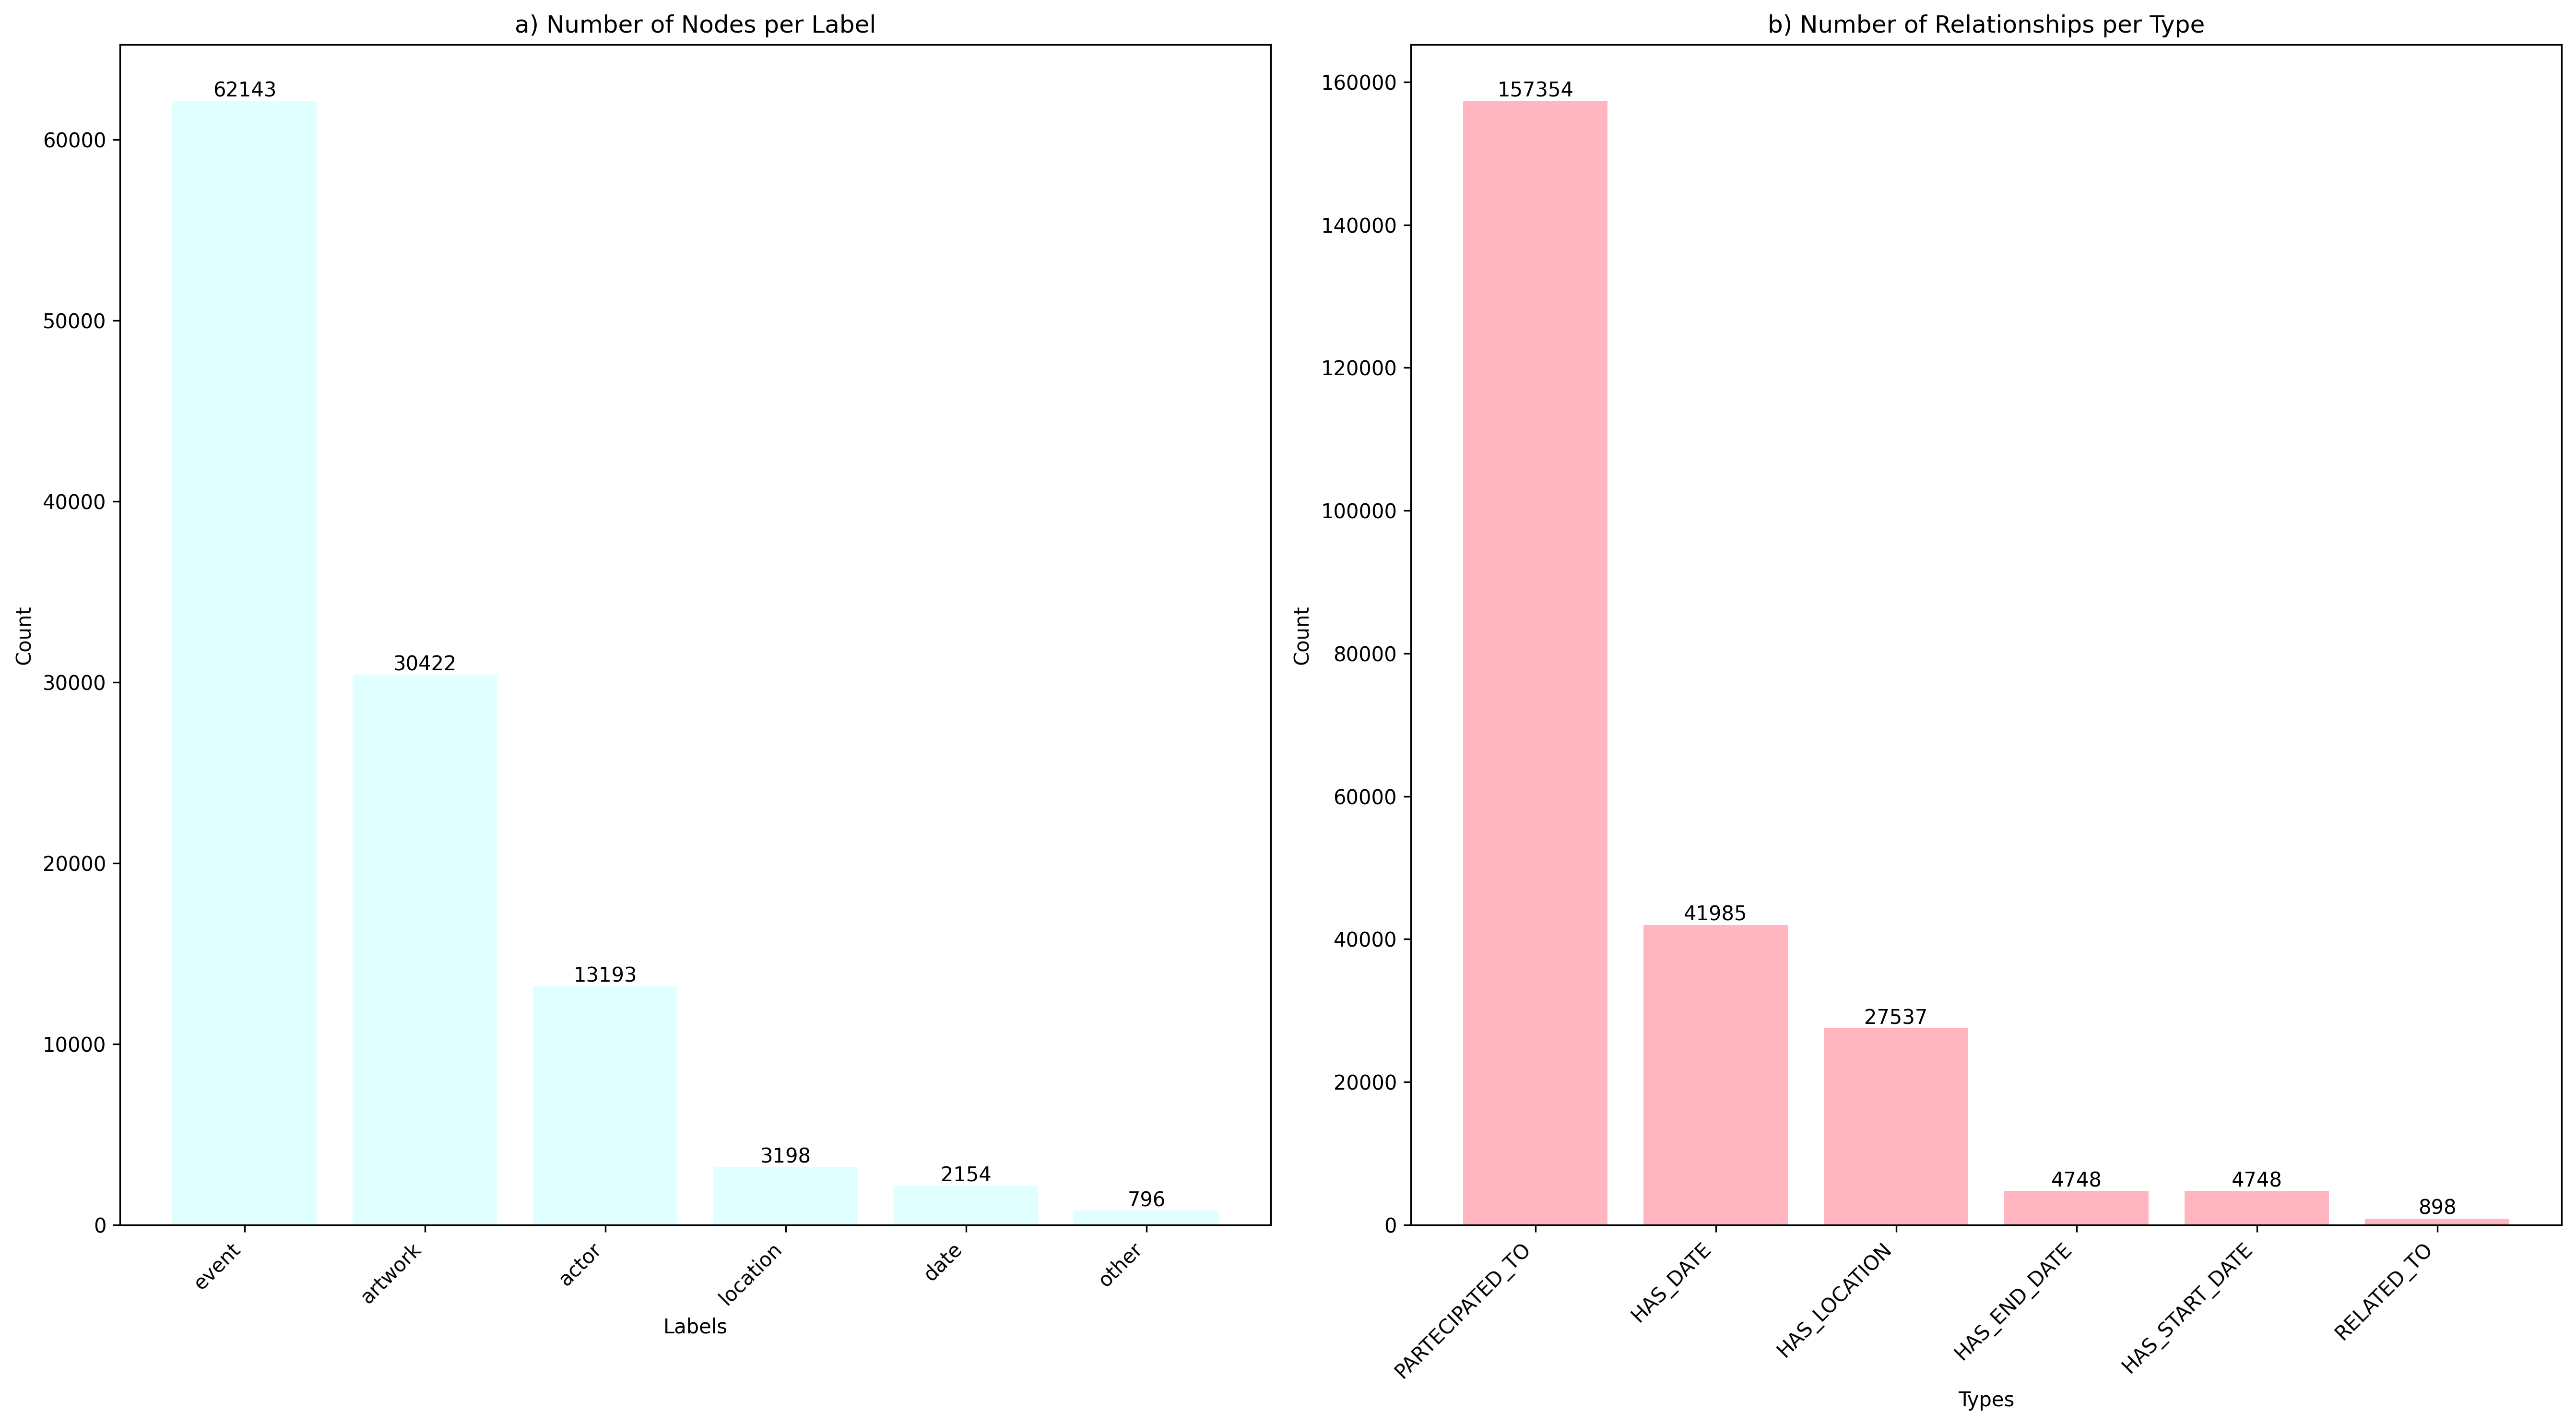

In [4]:
cleanNeo()
# Execute a query to get the number of nodes for each label
node_labels_query = "MATCH (n) RETURN labels(n) as labels, count(n) as count"
node_labels_result = run_cypher_query(node_labels_query,calctime=True)

# Execute a query to get the number of relationships for each type
relationship_types_query = "MATCH ()-[r]->() RETURN type(r) as type, count(r) as count"
relationship_types_result = run_cypher_query(relationship_types_query,calctime=True)

# Plot number of nodes for each label
node_labels_data = {}
for result in node_labels_result:
    labels = result.value('labels')
    count = result.value('count')
    for label in labels:
        if label in node_labels_data:
            node_labels_data[label] += count
        else:
            node_labels_data[label] = count

# Plot number of relationships for each type
relationship_types_data = {}
for result in relationship_types_result:
    relationship_type = result.value('type')
    count = result.value('count')
    relationship_types_data[relationship_type] = count

os.makedirs(PLOT_FOLDER, exist_ok=True)
file_name = 'combined_bar_charts.png' #change here the file name if needed

plt.figure(figsize=(18, 10), dpi=300)

plt.subplot(1, 2, 1)
plot_bar_chart(node_labels_data, 'a) Number of Nodes per Label', 'Labels', 'Count', color='lightcyan', label_rotation=True)

plt.subplot(1, 2, 2)
plot_bar_chart(relationship_types_data, 'b) Number of Relationships per Type', 'Types', 'Count', color='lightpink', label_rotation=True)

plt.subplots_adjust(right=0.85)  # Increase the margin on the right side
plt.tight_layout()
plt.savefig(f'{PLOT_FOLDER}{file_name}', dpi=300) #change dpi accordingly
plt.show()

<h2>First Projection: from Knowledge Graph to bipartite Graph</h2>

With the following cell we connect to our Neo4j database and collect artworks, events and actors nodes with their relationsip. Also this cell is to be played with the Neo4j database active.
We then create a netwokx graph directly in python to perform transformation directly on the notebook.

In [ ]:
query = "MATCH (n:artwork)-[r]-(e:event)-[r2]-(a:actor) RETURN *"
result = generalQuery(query)

G = nx.Graph()

for record in tqdm(result):
    artwork_node = record["n"]
    artwork_id = artwork_node['artwork_id']
    event_node = record["e"]
    event_id = event_node['event_id']
    actor_node = record["a"]
    actor_id = dict_hash(dict(actor_node))
    relationship_1 = record["r"]
    relationship_2 = record["r2"]

    # Add nodes and edges to the NetworkX graph
    G.add_node(artwork_id, label='artwork', properties=artwork_node._properties)    
    G.add_node(event_id, label="event", properties=event_node._properties)
    G.add_node(actor_id, label="actor", properties=actor_node._properties)
    G.nodes[actor_id]['actor_id'] = actor_id
    G.add_edge(artwork_id, event_id, label=relationship_1.type, direction='forward')
    G.add_edge(event_id, actor_id, label=relationship_2.type, direction='reverse')

nodes_and_edges(G)
countLabelsData(G)

os.makedirs(GRAPH_FOLDER, exist_ok=True)
graph_pickle = 'initial_graph.pickle'
# save graph object to file
pickle.dump(G, open(f'{GRAPH_FOLDER}{graph_pickle}', 'wb'))

In [34]:
# load graph object from file
G = pickle.load(open(f'{GRAPH_FOLDER}{graph_pickle}', 'rb'))

Nodes: 94845
Edges: 124348


(94845, 124348)

Once we collected the nodes that we need, we actually refactor our graph transforming each event to which both an artwork and a actor participated into a directed relationship (actor)-[:DEALT_WITH]->(artwork).  

In [35]:
from pyvis.network import Network
# Create a copy of the original graph
subgraph = G.copy()

# List to store nodes to be removed
nodes_to_remove = []

# Identify and remove event nodes
for node in tqdm(list(subgraph.nodes()), desc='Refactoring artwork-[]-event-[]-actors -> artwork-[]-actors'):
    if subgraph.nodes[node]['label'] == 'event':
        # Find connected actor and artwork nodes
        neighbors = list(subgraph.neighbors(node))
        actor_nodes = [n for n in neighbors if subgraph.nodes[n]['label'] == 'actor']
        artwork_nodes = [n for n in neighbors if subgraph.nodes[n]['label'] == 'artwork']
        
        # Add the actor-artwork relationships
        for actor in actor_nodes:
            for artwork in artwork_nodes:
                subgraph.add_edge(actor, artwork, label='dealt_with', direction='forward')
        
        # Add the event node to nodes_to_remove list
        nodes_to_remove.append(node)

# Remove the nodes
subgraph.remove_nodes_from(nodes_to_remove)
nodes,edges = nodes_and_edges(subgraph)

# Set titles for remaining nodes
for node in tqdm(subgraph.nodes(), desc='Setting titles'):
    if subgraph.nodes[node]['label'] == 'actor':
        name = subgraph.nodes[node]['properties']['name']
        subgraph.nodes[node]['title'] = f"Actor: {name} (ID: {node})"
    elif subgraph.nodes[node]['label'] == 'artwork':
        lotTitle = subgraph.nodes[node]['properties']['lotTitle']
        subgraph.nodes[node]['title'] = f"Artwork: {lotTitle} (ID: {node})"
        
subgraph_pickle = 'actor_artworks.pickle'
countLabelsData(subgraph)
pickle.dump(subgraph, open(f'{GRAPH_FOLDER}{subgraph_pickle}', 'wb'))

Refactoring artwork-[]-event-[]-actors -> artwork-[]-actors:   0%|          | 0/94845 [00:00<?, ?it/s]

Nodes: 43425
Edges: 71037


Setting titles:   0%|          | 0/43425 [00:00<?, ?it/s]

<h2>Cleaning of duplicate names</h2>

The following cells will leverage similarity.py

In [ ]:
removePatterns(subgraph) #this function will replace specific patterns with empty strings, in order to reduce the complexity of the string 

print('Merging Identical Names')
count = 0
for name in tqdm([subgraph.nodes[node]['properties']['name'] for node in subgraph.nodes if subgraph.nodes[node]['label']=='actor']):
    _,count = merge_nodes_same_name(subgraph,name, count)
print(f'Nodes merged: {count}')
print('')

print('Calculating Similar Nodes')
similar_nodes, mergesraw = find_similar_nodes(subgraph, merges, threshold=0.93)
for node1, node2, similarity in similar_nodes:
    print(f"Nodes {subgraph.nodes[node1]['properties']['name']} and {subgraph.nodes[node2]['properties']['name']} are similar with similarity {similarity:.2f}")
print('')

In [37]:
print(f'Nodes merged: {count}')
pickle.dump(similar_nodes, open(f'{DATASET_FOLDER}similar_nodes.pickle', 'wb'))
pickle.dump(mergesraw, open(f'{DATASET_FOLDER}mergesraw.pickle', 'wb'))
pickle.dump(subgraph, open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','wb'))

Nodes merged: 687


In [ ]:
similar_nodes = pickle.load(open(f'{DATASET_FOLDER}similar_nodes.pickle','rb'))
mergeswaw = pickle.load(open(f'{DATASET_FOLDER}mergesraw.pickle'))
subgraph = pickle.load(open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','rb'))
excls, count = similarityCheckRemoval(similar_nodes,subgraph)

In [39]:
print('Nodes merged:',count)

Nodes merged: 98


In [ ]:
#process some merge based on some manually checked names
sub, merges = checkManual(mergesraw,subgraph)
pickle.dump(sub,open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','wb'))
print('Nodes merged:',count)

In [ ]:
sub = pickle.load(open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','rb'))

The following cells will clean the data

In [42]:
#remove nodes that are entities recognition mistakes 
print('Graph before processing:')
nodes_and_edges(sub)
countLabelsData(sub)
remove_nodes_by_regex_and_label(sub)
count = changeLabel(sub)
mergingDuples(sub)
sub,count = mergingNodes(sub,MERGINGS)
removeErrArtwork(sub)
print('Graph after processing:')
nodes_and_edges(sub)
countLabelsData(sub)
pickle.dump(sub,open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','wb'))

The following cell will set a title on each node with its name and node id for eventual visualisation and display the bar chart with the top 20 highest degree nodes.

Sotheby's Degree -> 19850
Christie's Degree -> 11587
the Tuyet Nguyet Degree -> 656
Wou Kiuan Degree -> 273
Daniel Cordier Collection Degree -> 253
N Koutoulakis Degree -> 211
Collection Mrs Degree -> 205
the Junkunc Collection Degree -> 185
European private collection Degree -> 159
Charles Ede Degree -> 147
Hôtel Drouot Degree -> 135
Royal Athena Degree -> 135
Sotheby Parke-Bernet Degree -> 133
Edric van Vredenburgh Degree -> 119
PROPERTY FROM A SWISS PRIVATE COLLECTION Degree -> 99
Plesch Degree -> 98
PROPERTY FROM A MANHATTAN PRIVATE COLLECTION Degree -> 98
Rudolf Schmidt Degree -> 94
E Borowski Degree -> 90
The Groppi Collection Degree -> 87


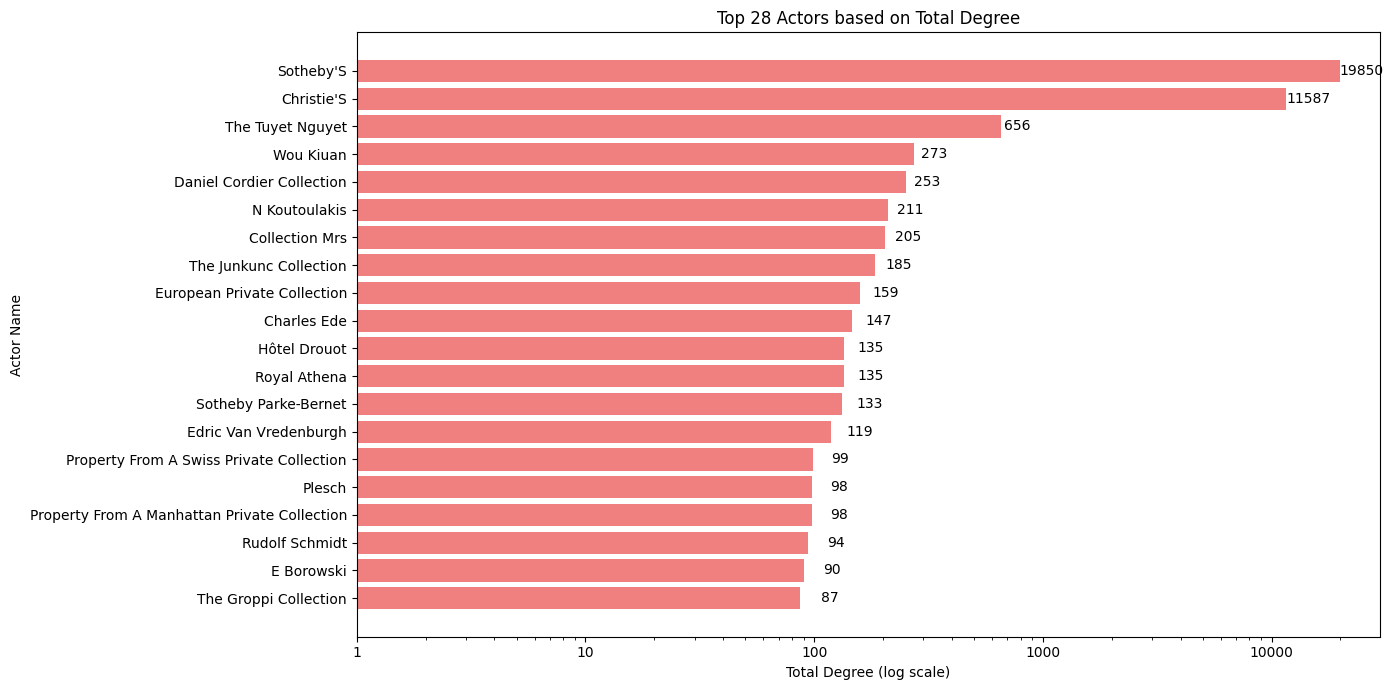

In [42]:
sub = pickle.load(open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','rb'))
for node in tqdm(sub.nodes(), desc='Setting titles'):
    if sub.nodes[node]['label'] == 'actor':
        name = sub.nodes[node]['properties']['name']
        sub.nodes[node]['title'] = f"Actor: {name} (ID: {node})"
    elif sub.nodes[node]['label'] == 'artwork':
        lotTitle = sub.nodes[node]['properties']['lotTitle']
        sub.nodes[node]['title'] = f"Artwork: {lotTitle} (ID: {node})"
barDegree(sub,num=20)

<h2>Second Projection: from bipartite to a one-mode undirected weighted graph (actors)-[:SHARES_ARTWORK]-(actors)</h2>

The following cell will operate the projection directly in python

In [43]:
# Create a new directed graph to hold the adjusted edges
actors_actors = nx.DiGraph()
# Sort nodes by degree in descending order
sorted_nodes = sorted(sub.nodes(), key=lambda x: sub.degree(x), reverse=True)
# Create a new undirected subgraph for actor sharing artwork
shared_artwork_subgraph = nx.Graph()
# Create a subgraph excluding the highest degree nodes "Christie's" and "Sotheby's"
subgraph_excluded = sub.subgraph(sorted_nodes[2:])
# Iterate through the 'actor' nodes in the original subgraph
for actor in tqdm(subgraph_excluded.nodes(),desc='Processing nodes'):
    if sub.nodes[actor]['label'] == 'actor':
        # Get the 'artwork' neighbors of the current 'actor'
        actor_neighbors = [neighbor for neighbor in subgraph_excluded.neighbors(actor) if subgraph_excluded.nodes[neighbor]['label'] == 'artwork']
        # Create edges between the 'actor' and 'artwork' neighbors
        for artwork in actor_neighbors:
            shared_actors = [neighbor for neighbor in subgraph_excluded.neighbors(artwork) if neighbor != actor and subgraph_excluded.nodes[neighbor]['label'] == 'actor']
            for shared_actor in shared_actors:
                # Add the start node as 'actor' and the end node as 'actor' in the adjusted graph
                actors_actors.add_node(actor, **subgraph_excluded.nodes[actor])
                actors_actors.add_node(shared_actor, **subgraph_excluded.nodes[shared_actor])
                # Add the edge between actors with weight based on the number of shared artworks
                shared_artworks_count = len([neighbor for neighbor in subgraph_excluded.neighbors(artwork) if subgraph_excluded.nodes[neighbor]['label'] == 'actor'])
                actors_actors.add_edge(actor, shared_actor, weight=shared_artworks_count)

# Convert the directed graph to an undirected graph
actors_actors = actors_actors.to_undirected()
# Find all connected components in the undirected graph
connected_components = list(nx.connected_components(actors_actors))
# Find the largest connected component
largest_connected_component = max(connected_components, key=len)
print(len(largest_connected_component))
# Create a subgraph containing only the largest connected component
largest_subgraph = actors_actors.subgraph(largest_connected_component)
adjusted_graph = largest_subgraph.copy()
nodes_and_edges(adjusted_graph)
countLabelsData(adjusted_graph)
#save largest connected component graph actors->actors
file_name = 'llc_actors_actors'
pickle.dump(adjusted_graph, open(f'{GRAPH_FOLDER}{file_name}.pickle', 'wb'))
nx.write_gexf(adjusted_graph, f"{GRAPH_FOLDER}{file_name}.gexf")

Processing nodes:   0%|          | 0/41509 [00:00<?, ?it/s]

6159


With the following cell we calculate all the relevant measures of the actor-actor connected graph

In [1]:
adjusted_graph = pickle.load(open(f'{GRAPH_FOLDER}llc_actors_actors.pickle', 'rb'))

In [2]:
resulting_values = dict()
if 'Nodes' not in resulting_values:
    node_count = adjusted_graph.number_of_nodes()
    print('Nodes:', node_count)
    resulting_values['Nodes'] = node_count
pR()

if 'Relationships' not in resulting_values:
    num_rels = adjusted_graph.number_of_edges()
    print('Relationships:',num_rels)
    resulting_values['Relationships'] = num_rels
pR()
    
if 'Average Degree (AD)' not in resulting_values:
    # Average Degree
    avg_degree = sum(dict(adjusted_graph.degree()).values()) / node_count
    print("Average Degree (AD):", avg_degree)
    resulting_values['Average Degree (AD)'] = avg_degree
pR()
    
if 'Degree Centrality (DC)' not in resulting_values:
    #Average Degree Centrality
    degree_centrality = nx.degree_centrality(adjusted_graph)
    resulting_values['Degree Centrality (DC)'] = degree_centrality
if 'Average Degree Centrality (ADC)' not in resulting_values:
    average_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
    print(f'Average Degree Centrality (ADC): {average_degree_centrality}')
    resulting_values['Average Degree Centrality (ADC)'] = average_degree_centrality
pR()
    
if 'Eigenvector Centrality (EC)' not in resulting_values:
    eigenvector_centrality = nx.eigenvector_centrality(adjusted_graph, weight='weight')
    resulting_values['Eigenvector Centrality (EC)'] = eigenvector_centrality
if 'Average Eigenvector Centrality (AE)' not in resulting_values:
    #Average Eigenvector Centrality
    average_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
    print(f'Average Eigenvector Centrality (AE): {average_eigenvector_centrality}')
    resulting_values['Average Eigenvector Centrality (AE)'] = average_eigenvector_centrality
pR()

if 'Betweennes Centrality (BC)' not in resulting_values:
    betweenness_centrality = nx.betweenness_centrality(adjusted_graph,weight='weight')
    resulting_values['Betweenness Centrality (BC)'] = betweenness_centrality
if 'Average Betweenness Centrality (AB)' not in resulting_values:
    average_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    print(f'Average Betweenness Centrality (AB): {average_betweenness_centrality}')
    resulting_values['Average Betweennes Centrality (AB)'] = average_betweenness_centrality
pR()

if 'Closeness Centrality (CC)' not in resulting_values:
    closeness_centrality = nx.closeness_centrality(adjusted_graph)
    resulting_values['Closeness Centrality (CC)'] = closeness_centrality
if 'Average Closeness Centrality (AC)' not in resulting_values:        
    #Average Closeness Centrality
    average_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
    print(f'Average Closeness Centrality (AC): {average_closeness_centrality}')
    resulting_values['Average Closeness Centrality (AC)'] = average_closeness_centrality
pR()

resulting_values = {
    'Nodes': node_count,
    'Relationships': num_rels,
    'Average Degree (AD)': avg_degree,
    'Average Degree Centrality (ADC)': average_degree_centrality,
    'Average Eigenvector Centrality (AE)': average_eigenvector_centrality,
    'Average Betweenness Centrality (AB)': average_betweenness_centrality,
    'Average Closeness Centrality (AC)': average_closeness_centrality,
}

Nodes: 6159
Nodes  :  6159
Relationships: 22390
Relationships  :  22390
Average Degree (AD): 7.2706608215619415
Average Degree (AD)  :  7.2706608215619415
Average Degree Centrality (ADC): 0.0011806854208446793
Average Degree Centrality (ADC)  :  0.0011806854208446793
Average Eigenvector Centrality (AE): 0.0011625709740004026
Average Eigenvector Centrality (AE)  :  0.0011625709740004026
Average Betweenness Centrality (AB): 0.0007339603878900597
Average Betweennes Centrality (AB)  :  0.0007339603878900597
Average Closeness Centrality (AC): 0.21227627664092816
Average Closeness Centrality (AC)  :  0.21227627664092816


In [4]:
if 'Average Path Length (APL)' not in resulting_values:
    # Average Path Length (L)
    avg_path_length = nx.average_shortest_path_length(adjusted_graph)
    print("Average Path Length (APL):", avg_path_length)
    resulting_values['Average Path Length (APL)'] = avg_path_length
pR()

if 'Average Clustering Coefficient (ACC)' not in resulting_values:        
    # Average Clustering Coefficient (C)
    avg_clustering_coefficient = nx.average_clustering(adjusted_graph)
    print("Average Clustering Coefficient (ACC):", avg_clustering_coefficient)
    resulting_values['Average Clustering Coefficient (ACC)'] = avg_clustering_coefficient
pR()

if "Graph Edge Density (GED)" not in resulting_values:
    #Graph Edge Density (Dns)
    graph_edge_density = 2 * num_rels / (node_count * (node_count - 1))
    print("Graph Edge Density (GED):", graph_edge_density)
    resulting_values["Graph Edge Density (GED)"] = graph_edge_density
pR()

if 'Graph Diameter (GD)' not in resulting_values:
    # Graph Diameter (Dmt)
    graph_diameter = nx.diameter(adjusted_graph)
    print("Graph Diameter (GD):", graph_diameter)
    resulting_values['Graph Diameter (GD)'] = graph_diameter
pR()


resulting_values.update({
    'Average Path Length (APL)': avg_path_length,
    'Average Clustering Coefficient (ACC)': avg_clustering_coefficient,
    'Graph Edge Density (GED)': graph_edge_density,
    'Graph Diameter (GD)': graph_diameter,
    'Degree Centrality (DC)': degree_centrality,
    'Eigenvector Centrality (EC)': eigenvector_centrality,
    'Betweenness Centrality (BC)': betweenness_centrality,
    'Closeness Centrality (CC)': closeness_centrality
})

Average Path Length (APL): 4.8147509847965795
Average Path Length (APL)  :  4.8147509847965795
Average Clustering Coefficient (ACC): 0.7161060131509057
Average Clustering Coefficient (ACC)  :  0.7161060131509057
Graph Edge Density (GED): 0.0011806854208447454
Graph Edge Density (GED)  :  0.0011806854208447454
Graph Diameter (GD): 14
Graph Diameter (GD)  :  14


In [ ]:
#We save the resulting_values in order to avoid long calulcation if not needed for following operations

pickle.dump(resulting_values, open(f'{DATASET_FOLDER}resulting_values.pickle', 'wb'))

In [ ]:
resulting_values = pickle.load(open('resulting_values.pickle', 'rb'))

In [8]:
degree_centrality = resulting_values['Degree Centrality (DC)']
eigenvector_centrality =  resulting_values['Eigenvector Centrality (EC)']
betweenness_centrality = resulting_values['Betweenness Centrality (BC)']
closeness_centrality = resulting_values['Closeness Centrality (CC)']

statistics = {'Degree Centrality (DC)': degree_centrality,
    'Eigenvector Centrality (EC)': eigenvector_centrality,
    'Betweenness Centrality (BC)': betweenness_centrality,
    'Closeness Centrality (CC)': closeness_centrality}

The following cell we display scatter plots with Pearson's r

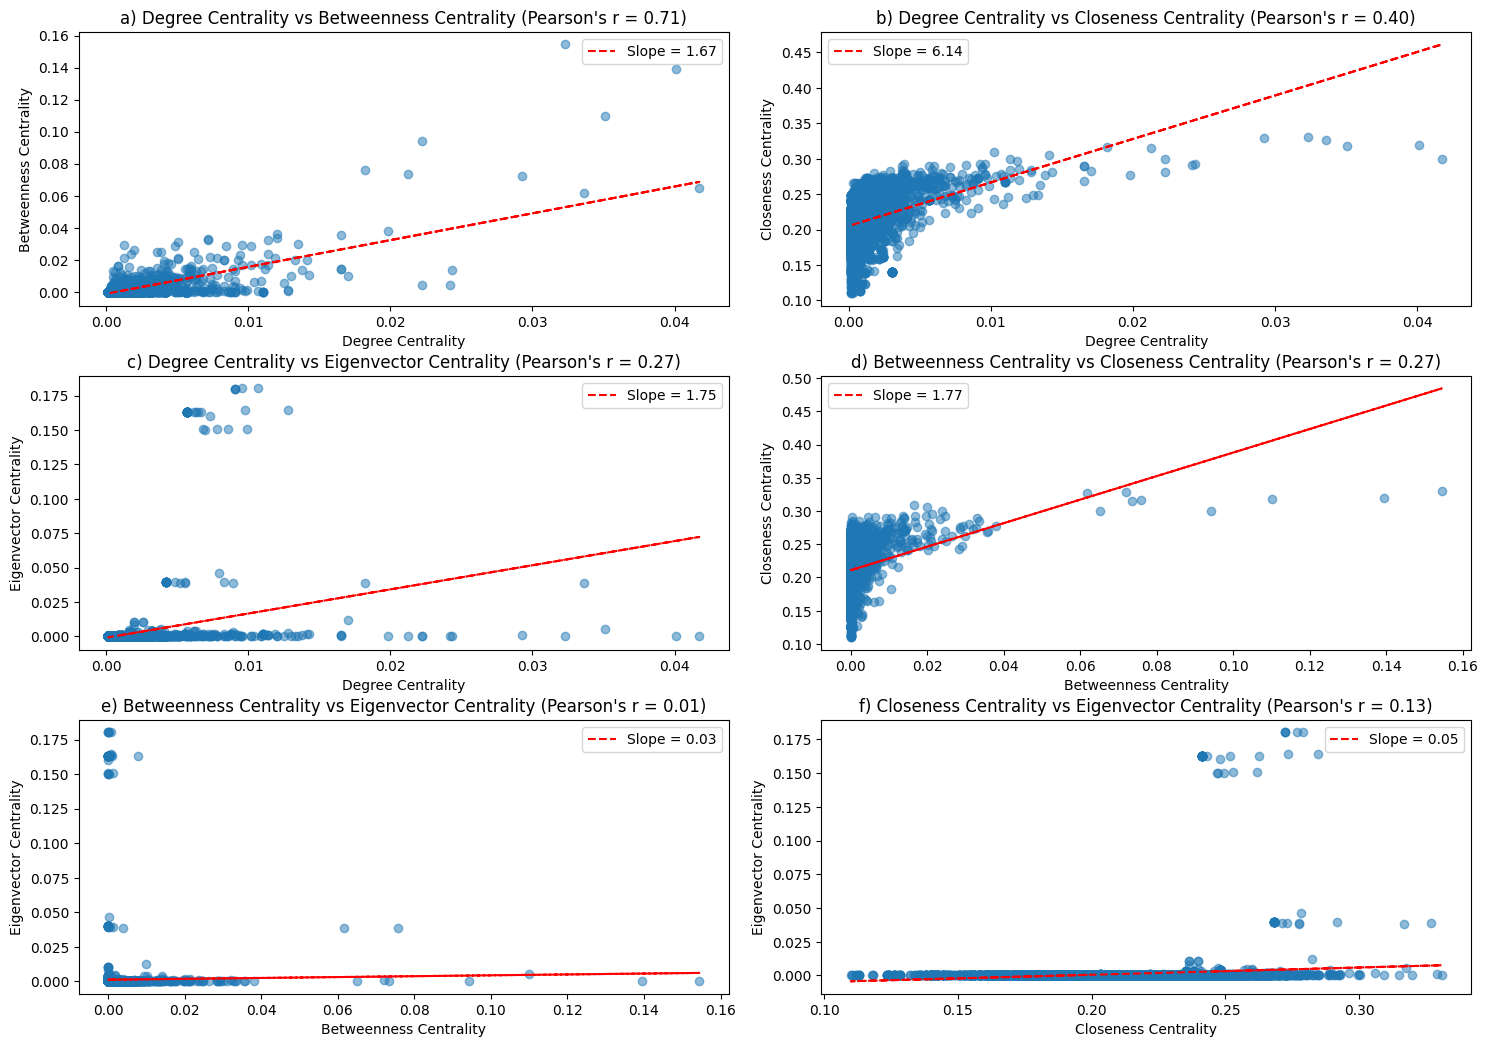

In [14]:
plt.figure(figsize=(15, 12))

degree_values = np.array([degree_centrality[node] for node in adjusted_graph.nodes()])
betweenness_values = np.array([betweenness_centrality[node] for node in adjusted_graph.nodes()])
closeness_values = np.array([closeness_centrality[node] for node in adjusted_graph.nodes()])
eigenvector_values = np.array([eigenvector_centrality[node] for node in adjusted_graph.nodes()])


plot_scatter(degree_values, betweenness_values, "Degree Centrality", "Betweenness Centrality", 321, 'a')
plot_scatter(degree_values, closeness_values, "Degree Centrality", "Closeness Centrality", 322, 'b')
plot_scatter(degree_values, eigenvector_values, "Degree Centrality", "Eigenvector Centrality", 323, 'c')
plot_scatter(betweenness_values, closeness_values, "Betweenness Centrality", "Closeness Centrality", 324, 'd')
plot_scatter(betweenness_values, eigenvector_values, "Betweenness Centrality", "Eigenvector Centrality", 325, 'e')
plot_scatter(closeness_values, eigenvector_values, "Closeness Centrality", "Eigenvector Centrality", 326, 'f')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Save the figure before displaying it
plt.savefig(f"{PLOTS_FOLDER}centralitiescomparisons.png", dpi=300)

# Display the plot
plt.show()


ACTOR-ACTOR CONNECTED GRAPH
-----------------------------------------
Number of nodes: 6159
Number of edges: 22390
Network density: 0.0011806854208447454
Global clustering coefficient: 0.3121113434693635
-----------------------------------------
-----------------------------------------
Pearson's r for Degree Centrality (DC) vs Eigenvector Centrality (EC) -> 0.26831783776096924
Null hypothesis: False
Significant difference: True
Pearson's r for Degree Centrality (DC) vs Betweenness Centrality (BC) -> 0.7131876974781715
Null hypothesis: False
Significant difference: True
Pearson's r for Degree Centrality (DC) vs Closeness Centrality (CC) -> 0.3976455521422856
Null hypothesis: False
Significant difference: True
-----------------------------------------
-----------------------------------------
Pearson's r for Eigenvector Centrality (EC) vs Degree Centrality (DC) -> 0.26831783776096924
Null hypothesis: False
Significant difference: True
Pearson's r for Eigenvector Centrality (EC) vs Betwe

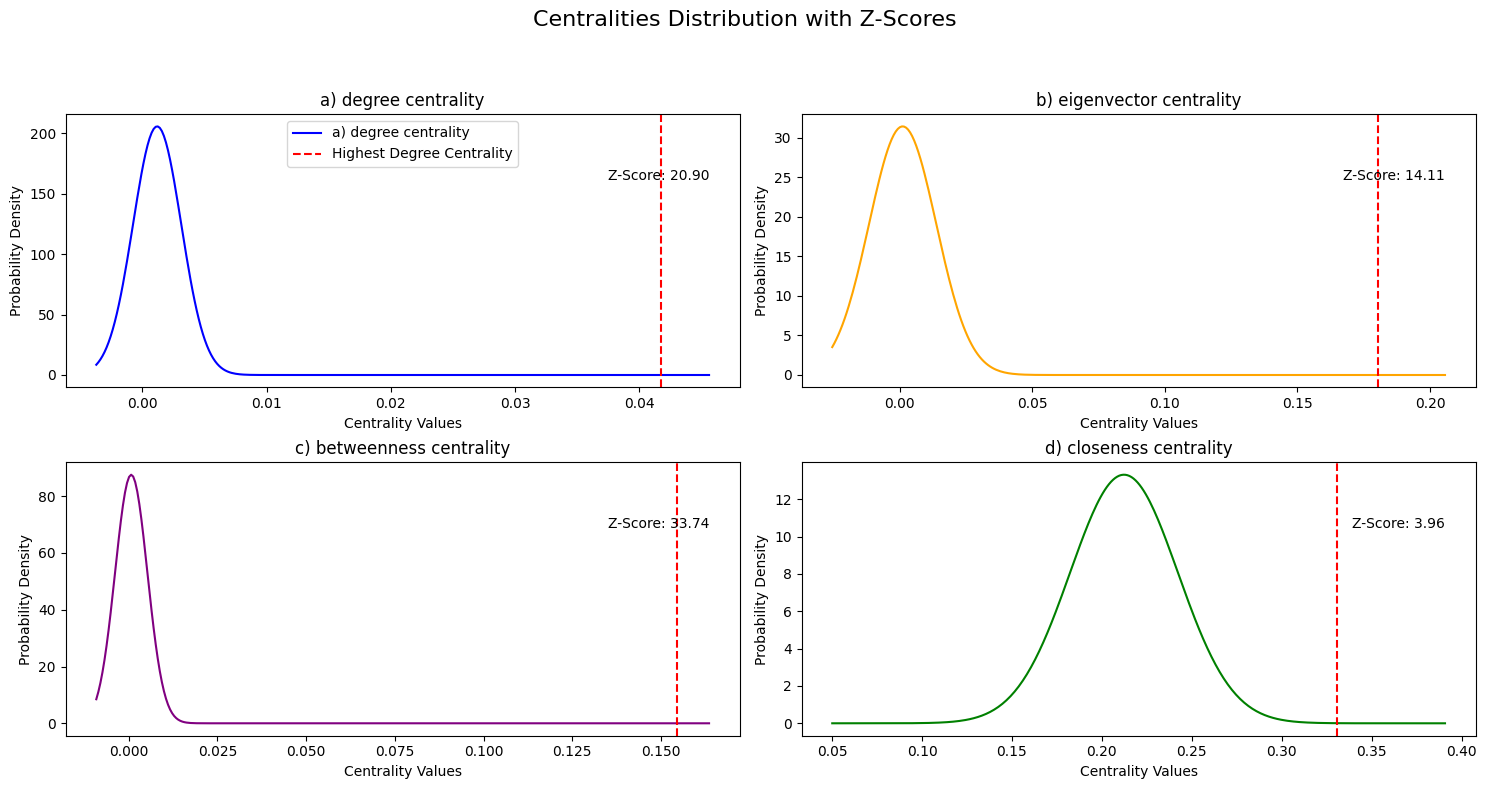

In [22]:
statistics_graph(statistics,adjusted_graph)

In [28]:
# Print top nodes based on centrality measures
topeig = print_top_nodes(eigenvector_centrality, "Eigenvector", adjusted_graph, num_top_nodes=50)
print("\n")
topbet = print_top_nodes(betweenness_centrality, "Betweenness", adjusted_graph, num_top_nodes=50)
print("\n")
topclos = print_top_nodes(closeness_centrality, "Closeness", adjusted_graph, num_top_nodes=50)
print('\n')
topdeg = print_top_nodes(degree_centrality, "Degree", adjusted_graph, num_top_nodes=50)

d0a501c3a44d50246975fc1500d88fd66ba1979f3007a4354b76b0521cec93076d73ec39301502fdf8e9df07ed76af5a4ba7ba3f40f9ed05a160e44eb238466a
ecb72c0bf1dc9799dcf03e415fddd9a7b0bfa9b4acfef0e5cd4ae3e00d6b3be57486a4a9ac98f58cf900db1dd57d189a008d1a88a48304e02cc5e739e3cb9a45
Top 50 nodes based on Eigenvector centrality:
Node       Score      Label               
aa10f...   0.180      Vermeule            
a8566...   0.180      American Journal of Archaeology
39645...   0.180      Adolf Michaelis     
950f1...   0.180      Michaelis           
06a32...   0.165      Gavin Hamilton      
45532...   0.164      Salomon Reinach     
ec288...   0.163      Archäologischer Anzeiger
345df...   0.163      Ann Arbor           
b5697...   0.163      California Private Collection
c541b...   0.163      Georg Lippold       
87aac...   0.163      Whittall Collection 
7115d...   0.163      the Ancient Marbles 
a93d7...   0.163      Greek Sculpture and Roman Taste
fa5de...   0.163      Legendary Hollywood Decorator
cd934..

In [96]:

# Read centrality data from dictionaries
degree_df = read_centrality_data(topdeg)
betweenness_df = read_centrality_data(topbet)
eigenvector_df = read_centrality_data(topeig)
closeness_df = read_centrality_data(topclos)

# Find common nodes
common_nodes = find_common_nodes(closeness_df,degree_df, betweenness_df)

# Create a new DataFrame with common nodes
common_nodes_df = pd.DataFrame({'Label': list(common_nodes)})

# Merge common nodes with each centrality measure with different suffixes
common_nodes_df = pd.merge(common_nodes_df, closeness_df, on='Label').rename(columns={'Score':'Closeness'})
common_nodes_df = pd.merge(common_nodes_df, degree_df, on='Label').rename(columns={'Score':'Degree'})
common_nodes_df = pd.merge(common_nodes_df, betweenness_df, on='Label').rename(columns={'Score':'Betweenness'})

# Order the DataFrame based on Degree Score in descending order
common_nodes_df = common_nodes_df.sort_values(by='Closeness', ascending=False)
common_nodes_df[['Label','Closeness','Degree', 'Betweenness']]

Label Closeness Degree  \
10                               Sotheby Parke-Bernet     0.331  0.032   
1                                        Royal Athena     0.329  0.029   
12                                       Parke-Bernet     0.327  0.034   
13                                       Hôtel Drouot     0.320  0.040   
4                         European private collection     0.317  0.035   
15                                              Spink     0.317  0.018   
14                                            Bonhams     0.315  0.021   
2   THE DEVOTED CLASSICI THE PRIVATE COLLECTION OF...     0.309  0.010   
5    PROPERTY FROM A NEW YORK CITY PRIVATE COLLECTION     0.306  0.014   
9                                         Charles Ede     0.300  0.022   
3                                      Collection Mrs     0.300  0.042   
11                                        Robin Symes     0.300  0.011   
17                                            Ariadne     0.296  0.012   
0                                            J-D Cahn     0.292  0.010   
8                                    Merton D Simpson     0.288  0.009   
7                                       N Koutoulakis     0.285  0.012   
6                                   Fortuna Fine Arts     0.284  0.011   
16                                      Mathias Komor     0.278  0.010   

   Betweenness  
10       0.154  
1        0.072  
12       0.062  
13       0.139  
4        0.110  
15       0.076  
14       0.073  
2        0.016  
5        0.020  
9        0.094  
3        0.065  
11       0.024  
17       0.021  
0        0.017  
8        0.023  
7        0.033  
6        0.017  
16       0.029